In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier

In [297]:
data_train = pd.read_csv('./train.csv')

In [298]:
print(f"Duplicated rows: {data_train.duplicated(keep=False).sum()}")
print(f"Duplicated rows without target: {data_train.drop(['Survived'], axis=1).duplicated(keep=False).sum()}")

Duplicated rows: 0
Duplicated rows without target: 0


In [299]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [300]:
data_train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [301]:
y = data_train['Survived']
data_train_id = data_train['PassengerId']

In [302]:
relatives = data_train.SibSp + data_train.Parch
data_train['Relatives'] = relatives

In [303]:
data_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Relatives  
0      0         A/5 21171   7.2500   NaN        S          1  
1      0          PC 17599  71.2833   C85        C          1  
2      0  STON/O2. 3101282   7.9250   NaN        S          0  
3      0            113803  53.1000  C123        S          1  
4      0            373450   8.0500   NaN        S          0

In [304]:
data_train['Is_Alone'] = data_train.Relatives == 0

In [305]:
data_train.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
data_train = data_train.reset_index(drop=True)

**Заполняем NaN-ы**

In [306]:
data_train[(data_train['Embarked'].notna()) & (data_train['Sex'] == 'female')].groupby('Embarked').Fare.mean()

Embarked
C    75.169805
Q    12.634958
S    38.740929
Name: Fare, dtype: float64

In [307]:
data_train.loc[data_train['Embarked'].isna(), 'Embarked'] = 'C'

In [308]:
data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'C') & 
           (data_train['Pclass'] == 1), 'Age'] = 36.052632

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 1), 'Age'] = 33.456522
           
data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'C') & 
           (data_train['Pclass'] == 1), 'Age'] = 40.111111
           
data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 1), 'Age'] = 41.897188

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'Q') & 
           (data_train['Pclass'] == 2), 'Age'] = 30.0
           
data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 2), 'Age'] = 29.719697

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'C') & 
           (data_train['Pclass'] == 2), 'Age'] = 25.937500

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 2), 'Age'] = 30.875889

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'C') & 
           (data_train['Pclass'] == 3), 'Age'] = 14.062500

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'Q') & 
           (data_train['Pclass'] == 3), 'Age'] = 22.85

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'female')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 3), 'Age'] = 23.223684

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'C') & 
           (data_train['Pclass'] == 3), 'Age'] = 25.0168

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'Q') & 
           (data_train['Pclass'] == 3), 'Age'] = 28.142857

data_train.loc[(data_train['Age'].isna()) & (data_train['Sex'] == 'male')  & (data_train['Embarked'] == 'S') & 
           (data_train['Pclass'] == 3), 'Age'] = 26.574766

In [309]:
data_train.loc[(data_train['Fare'] == 0) & (data_train['Sex'] == 'male') & (data_train['Embarked'] == 'S') & 
               (data_train['Pclass'] == 1), 'Fare'] = data_train[(data_train['Sex'] == 'male') & 
                                                                 (data_train['Embarked'] == 'S') & 
                                                                 (data_train['Pclass'] == 1)].Fare.mean()

data_train.loc[(data_train['Fare'] == 0) & (data_train['Sex'] == 'male') & (data_train['Embarked'] == 'S') & 
               (data_train['Pclass'] == 2), 'Fare'] = data_train[(data_train['Sex'] == 'male') & 
                                                                 (data_train['Embarked'] == 'S') & 
                                                                 (data_train['Pclass'] == 2)].Fare.mean()

data_train.loc[(data_train['Fare'] == 0) & (data_train['Sex'] == 'male') & (data_train['Embarked'] == 'S') & 
               (data_train['Pclass'] == 3), 'Fare'] = data_train[(data_train['Sex'] == 'male') & 
                                                                 (data_train['Embarked'] == 'S') & 
                                                                 (data_train['Pclass'] == 3)].Fare.mean()

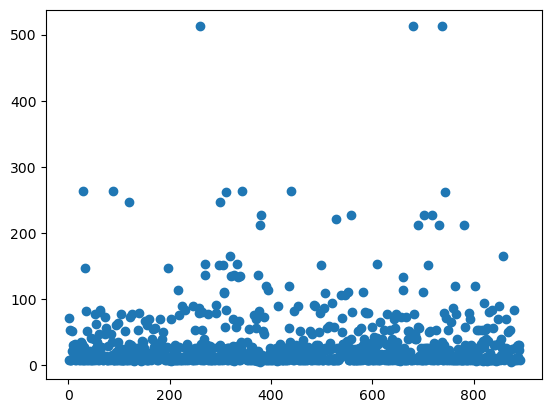

In [310]:
x = data_train_id.to_list()
y_1 = data_train.Fare.to_list()
plt.scatter(x, y_1)

In [311]:
data_train.loc[data_train.Fare > 400, 'Fare'] = data_train[(data_train.Fare < 400) & (data_train.Embarked == 'C') & 
                                                           (data_train.Pclass == 1) & (data_train.Age > 34) & 
                                                           (data_train.Age < 37)].Fare.mean() + 1

In [312]:
data_train.loc[(data_train.Relatives > 9), 'Relatives'] = data_train[(data_train.Relatives < 9)].Relatives.max()

In [313]:
data_train['Fare_Category'] = pd.cut(data_train['Fare'], bins=[0, 40, 100, 170, 270], 
                                     labels=['Low', 'Mid', 'High_Mid', 'High'])

In [314]:
data_train = data_train.astype({'Age': np.int64})
data_train = data_train.astype({'Fare': np.int64})

In [315]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Pclass         891 non-null    int64   
 1   Sex            891 non-null    object  
 2   Age            891 non-null    int64   
 3   Fare           891 non-null    int64   
 4   Embarked       891 non-null    object  
 5   Relatives      891 non-null    int64   
 6   Is_Alone       891 non-null    bool    
 7   Fare_Category  891 non-null    category
dtypes: bool(1), category(1), int64(4), object(2)
memory usage: 43.8+ KB


In [316]:
data_train[data_train.Fare_Category.isna()]

Empty DataFrame
Columns: [Pclass, Sex, Age, Fare, Embarked, Relatives, Is_Alone, Fare_Category]
Index: []

In [317]:
real_cols = ['Age', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked', 'Relatives', 'Is_Alone', 'Fare_Category']

In [67]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [573]:
scaler = StandardScaler()
scaler_real_cols = pd.DataFrame(scaler.fit_transform(data_train[real_cols]), columns=scaler.get_feature_names_out())

#robust = RobustScaler()
#robust_real_cols = pd.DataFrame(robust.fit_transform(real_cols), columns=robust.get_feature_names_out())

In [68]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [575]:
#ohe = OneHotEncoder()
label = LabelEncoder()
#one_hot_cat_cols = pd.DataFrame(ohe.fit_transform(cat_cols).toarray(), columns=ohe.get_feature_names_out())
#label_cat_cols = pd.DataFrame(label.fit_transform(cat_cols).toarray(), columns=label.get_feature_names_out())
label_cat_cols = data_train[cat_cols].apply(LabelEncoder().fit_transform)

In [576]:
X = pd.concat([data_train[real_cols], label_cat_cols], axis='columns')

In [577]:
X

Age  Fare  Pclass  Sex  Embarked  Relatives
0     22     7       2    1         2          1
1     38    71       0    0         0          1
2     26     7       2    0         2          0
3     35    53       0    0         2          1
4     35     8       2    1         2          0
..   ...   ...     ...  ...       ...        ...
886   27    13       1    1         2          0
887   19    30       0    0         2          0
888   23    23       2    0         2          3
889   26    30       0    1         0          0
890   32     7       2    1         1          0

[891 rows x 6 columns]

In [69]:
from sklearn.model_selection import train_test_split

In [579]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifier, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

**KNN** 5 min

In [110]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'p': range(1, 3),
              'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', 'manhattan', 'nan-euclidean']}
grid_knn = GridSearchCV(knn, params_knn, n_jobs=-1, verbose=2, scoring='accuracy')
grid_knn.fit(X, y)

Fitting 5 folds for each of 70400 candidates, totalling 352000 fits


KeyboardInterrupt: 

In [ ]:
grid_knn.best_params_

In [ ]:
grid_knn.best_score_

In [ ]:
knn = KNeighborsClassifier(algorithm='brute', leaf_size=2, metric='cityblock', n_neighbors=27, p=1, weights='uniform')
knn.fit(X, y)

In [117]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



In [118]:
print(accuracy_score(y_test, y_pred))

0.7877094972067039


**LOGREGRESSION** 1.5 min

In [254]:
logistic = LogisticRegression()
params_log = {'penalty': [None, 'l1', 'l2', 'elasticnet'],
              'fit_intercept': [True, False],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'C': np.arange(0.1, 2.1, 0.1),
              'max_iter': [100, 200, 250, 300, 400, 500, 600, 700, 750, 800, 900, 1000],
              'multi_class': ['auto', 'ovr', 'multinomial']}
grid_log = GridSearchCV(logistic, params_log, n_jobs=-1, verbose=2, scoring='accuracy')
grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 34560 candidates, totalling 172800 fits


C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
88800 fits failed out of a total of 172800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblin

C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.80194031        nan 0.80194031 ...        nan        nan        nan]
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 250, 300, 400, 500, 600, 700,
                                      750, 800, 900, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy', verbose=2)

In [257]:
grid_log.best_params_

{'C': 0.1,
 'fit_intercept': True,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [258]:
grid_log.best_score_

0.8089727174234216

In [259]:
logistic = LogisticRegression(C=0.1, fit_intercept=True, max_iter=100, multi_class='multinomial', penalty='l2', solver='lbfgs')
logistic.fit(X, y)

LogisticRegression(C=0.1, multi_class='multinomial')

In [260]:
y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [261]:
print(f1_score(y_test, y_pred))

0.7445255474452556


**LogRegressionCV** 3 min

In [320]:
log_cv = LogisticRegressionCV()
params_log_cv = {'penalty': ['l1', 'l2', 'elasticnet'],
                 'fit_intercept': [True, False],
                 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'cv': np.arange(4, 11),
                 'max_iter': [100, 200, 250, 300, 400, 500, 500, 700, 750, 800, 900, 1000],
                 'multi_class': ['auto', 'ovr', 'multinomial']}
grid_log_cv = GridSearchCV(log_cv, params_log_cv, n_jobs=-1, verbose=2, scoring='accuracy')
grid_log_cv.fit(X, y)

Fitting 5 folds for each of 9072 candidates, totalling 45360 fits


C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
27720 fits failed out of a total of 45360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2520 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\markc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueErro

GridSearchCV(estimator=LogisticRegressionCV(), n_jobs=-1,
             param_grid={'cv': array([ 4,  5,  6,  7,  8,  9, 10]),
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 250, 300, 400, 500, 500, 700,
                                      750, 800, 900, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy', verbose=2)

In [321]:
grid_log_cv.best_params_

{'cv': 8,
 'fit_intercept': True,
 'max_iter': 100,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'sag'}

In [322]:
grid_log_cv.best_score_

0.8036407005209968

In [323]:
log_cv = LogisticRegressionCV(cv=8, fit_intercept=True, max_iter=100, 
                              multi_class='auto',  penalty='l2', solver='sag')
log_cv.fit(X, y)

LogisticRegressionCV(cv=8, solver='sag')

In [324]:
y_pred = log_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



In [325]:
print(f1_score(y_test, y_pred))

0.7596899224806202


**SVM** 6 min

In [371]:
svm = SVC()
params_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto'],
              'coef0': np.arange(0.0, 2.1, 0.1),
             'C': np.arange(0.1, 3.1, 0.1),
             'degree': range(1, 6)}
grid_svm = GridSearchCV(svm, params_svm, n_jobs=-1, verbose=2, scoring='accuracy')
grid_svm.fit(X, y)

Fitting 5 folds for each of 25200 candidates, totalling 126000 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ]),
                         'coef0': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'degree': range(1, 6), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [372]:
grid_svm.best_params_

{'C': 1.1,
 'coef0': 0.30000000000000004,
 'degree': 4,
 'gamma': 'auto',
 'kernel': 'poly'}

In [373]:
grid_svm.best_score_

0.8271608813006089

In [374]:
svm = SVC(C=1.1, coef0=0.3, degree=4, gamma='auto', kernel='poly')
svm.fit(X, y)

SVC(C=1.1, coef0=0.3, degree=4, gamma='auto', kernel='poly')

In [375]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       110
           1       0.83      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



In [376]:
print(f1_score(y_test, y_pred))

0.7751937984496124


**RandomForest** 7 min

In [581]:
params_rnd_for = {'n_estimators': range(40, 91),
                  'min_samples_split': np.arange(2, 11),
                  'min_samples_leaf': np.arange(2, 11),
                  'criterion': ['gini', 'entropy', 'log_loss']}
grid_rnd_for = GridSearchCV(rnd_for, params_rnd_for, n_jobs=-1, verbose=2, scoring='accuracy')
grid_rnd_for.fit(X, y)

Fitting 5 folds for each of 12393 candidates, totalling 61965 fits


GridSearchCV(estimator=RandomForestClassifier(criterion='log_loss',
                                              min_samples_leaf=2,
                                              min_samples_split=6,
                                              n_estimators=50),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': range(40, 91)},
             scoring='accuracy', verbose=2)

In [582]:
grid_rnd_for.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 58}

In [583]:
grid_rnd_for.best_score_

0.8451446864603603

In [584]:
rnd_for = RandomForestClassifier(criterion='gini', min_samples_leaf=2, min_samples_split=6, n_estimators=58)
rnd_for.fit(X, y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=6, n_estimators=58)

In [585]:
y_pred = rnd_for.predict(X_test)

In [586]:
print(f1_score(y_test, y_pred))

0.890625


**Stacking**

In [110]:
stacking = StackingClassifier(
    estimators=[
        ("knn", knn),
        ("log_cv", log_cv),
        ("svm", svm),
        ("rnd_for", rnd_for)
    ],
    final_estimator=rnd_for,
    n_jobs=-1
)
stacking.fit(X, y)

StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(algorithm='brute',
                                                     leaf_size=2,
                                                     metric='cityblock',
                                                     n_neighbors=27, p=1)),
                               ('log_cv',
                                LogisticRegressionCV(cv=7, solver='liblinear')),
                               ('svm',
                                SVC(C=0.6, coef0=1.1, degree=4, gamma='auto',
                                    kernel='poly')),
                               ('rnd_for',
                                RandomForestClassifier(criterion='log_loss',
                                                       min_samples_leaf=2,
                                                       min_samples_split=7,
                                                       n_estimators=69))],
                   final_estimator=RandomForestClassifier(criterion='log_loss',
                                                          min_samples_leaf=2,
                                                          min_samples_split=7,
                                                          n_estimators=69),
                   n_jobs=-1)

**CatBoost**

In [318]:
cat_cols_boost = ["Pclass", 'Sex', 'Embarked', 'Relatives', 'Is_Alone', 'Fare_Category']

In [319]:
data_train.head()

Pclass     Sex  Age  Fare Embarked  Relatives  Is_Alone Fare_Category
0       3    male   22     7        S          1     False           Low
1       1  female   38    71        C          1     False           Mid
2       3  female   26     7        S          0      True           Low
3       1  female   35    53        S          1     False           Mid
4       3    male   35     8        S          0      True           Low

In [320]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(data_train, y, stratify=y, test_size=0.2)

In [321]:
catboost = CatBoostClassifier(cat_features=cat_cols_boost, eval_metric='Accuracy')

In [322]:
PARAMS = {
    "n_estimators": [1000, 2000, 3000],
    #"learning_rate": [0.01, 0.05, 0.003, 0.1, 0.5],
    "max_depth": [3, 4, 5, 6, 7, 8, 9],
    #"l2_leaf_reg": [0.1, 0.2, 0.3, 0.4, 1.0, 2.0, 3.0, 4.0]
    #"subsample": np.arange(),
    #"grow_policy": ['SymmetricTree', 'Depthwise', 'Lossguide'], 
    #"random_strength": [1, 2, 5],
    #"min_data_in_leaf": [1, 2, 5, 10, 15]
}
catboost.grid_search(PARAMS, data_train, y, cv=5, refit=True, verbose=True)

0:	learn: 0.7921348	test: 0.7988827	best: 0.7988827 (0)	total: 6.51ms	remaining: 6.51s
1:	learn: 0.7935393	test: 0.7932961	best: 0.7988827 (0)	total: 13.7ms	remaining: 6.83s
2:	learn: 0.8047753	test: 0.7709497	best: 0.7988827 (0)	total: 20.6ms	remaining: 6.83s
3:	learn: 0.8047753	test: 0.7709497	best: 0.7988827 (0)	total: 25.5ms	remaining: 6.36s
4:	learn: 0.8160112	test: 0.7877095	best: 0.7988827 (0)	total: 30.5ms	remaining: 6.07s
5:	learn: 0.8160112	test: 0.7877095	best: 0.7988827 (0)	total: 35.7ms	remaining: 5.91s
6:	learn: 0.8103933	test: 0.7821229	best: 0.7988827 (0)	total: 40.8ms	remaining: 5.78s
7:	learn: 0.8103933	test: 0.7877095	best: 0.7988827 (0)	total: 45.7ms	remaining: 5.66s
8:	learn: 0.8075843	test: 0.7821229	best: 0.7988827 (0)	total: 50.7ms	remaining: 5.58s
9:	learn: 0.8047753	test: 0.7821229	best: 0.7988827 (0)	total: 55.3ms	remaining: 5.47s
10:	learn: 0.8047753	test: 0.7821229	best: 0.7988827 (0)	total: 60ms	remaining: 5.4s
11:	learn: 0.8103933	test: 0.7877095	best: 0.

115:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (48)	total: 653ms	remaining: 4.97s
116:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 660ms	remaining: 4.98s
117:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 666ms	remaining: 4.98s
118:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 672ms	remaining: 4.97s
119:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 678ms	remaining: 4.97s
120:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 685ms	remaining: 4.97s
121:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 691ms	remaining: 4.97s
122:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 697ms	remaining: 4.97s
123:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 701ms	remaining: 4.95s
124:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 706ms	remaining: 4.94s
125:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 710ms	remaining: 4.92s
126:	learn: 0.8300562

232:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (48)	total: 1.27s	remaining: 4.2s
233:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (48)	total: 1.28s	remaining: 4.2s
234:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.29s	remaining: 4.19s
235:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.29s	remaining: 4.18s
236:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.3s	remaining: 4.18s
237:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.3s	remaining: 4.17s
238:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.31s	remaining: 4.17s
239:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.31s	remaining: 4.16s
240:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.32s	remaining: 4.16s
241:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.32s	remaining: 4.15s
242:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.33s	remaining: 4.14s
243:	learn: 0.8398876	tes

351:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.89s	remaining: 3.48s
352:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.9s	remaining: 3.48s
353:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.9s	remaining: 3.47s
354:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.91s	remaining: 3.46s
355:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.91s	remaining: 3.46s
356:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.92s	remaining: 3.45s
357:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.92s	remaining: 3.45s
358:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.93s	remaining: 3.44s
359:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.93s	remaining: 3.44s
360:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.94s	remaining: 3.43s
361:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 1.95s	remaining: 3.43s
362:	learn: 

468:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.52s	remaining: 2.85s
469:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.53s	remaining: 2.85s
470:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.53s	remaining: 2.85s
471:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.54s	remaining: 2.84s
472:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.54s	remaining: 2.83s
473:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.55s	remaining: 2.83s
474:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.55s	remaining: 2.82s
475:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.56s	remaining: 2.82s
476:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.56s	remaining: 2.81s
477:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.57s	remaining: 2.81s
478:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.58s	remaining: 2.8s
479:	learn:

586:	learn: 0.8665730	test: 0.8324022	best: 0.8435754 (422)	total: 3.13s	remaining: 2.2s
587:	learn: 0.8665730	test: 0.8324022	best: 0.8435754 (422)	total: 3.13s	remaining: 2.19s
588:	learn: 0.8665730	test: 0.8324022	best: 0.8435754 (422)	total: 3.14s	remaining: 2.19s
589:	learn: 0.8665730	test: 0.8324022	best: 0.8435754 (422)	total: 3.14s	remaining: 2.18s
590:	learn: 0.8693820	test: 0.8324022	best: 0.8435754 (422)	total: 3.15s	remaining: 2.18s
591:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.15s	remaining: 2.17s
592:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.16s	remaining: 2.17s
593:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.16s	remaining: 2.16s
594:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.17s	remaining: 2.15s
595:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.17s	remaining: 2.15s
596:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.18s	remaining: 2.14s
597:	learn:

707:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.74s	remaining: 1.54s
708:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.75s	remaining: 1.54s
709:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.76s	remaining: 1.53s
710:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.76s	remaining: 1.53s
711:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.77s	remaining: 1.52s
712:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.77s	remaining: 1.52s
713:	learn: 0.8750000	test: 0.8435754	best: 0.8435754 (422)	total: 3.78s	remaining: 1.51s
714:	learn: 0.8764045	test: 0.8435754	best: 0.8435754 (422)	total: 3.78s	remaining: 1.51s
715:	learn: 0.8778090	test: 0.8379888	best: 0.8435754 (422)	total: 3.79s	remaining: 1.5s
716:	learn: 0.8778090	test: 0.8379888	best: 0.8435754 (422)	total: 3.79s	remaining: 1.5s
717:	learn: 0.8764045	test: 0.8435754	best: 0.8435754 (422)	total: 3.8s	remaining: 1.49s
718:	learn: 0

822:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.38s	remaining: 942ms
823:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.38s	remaining: 937ms
824:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.39s	remaining: 931ms
825:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.4s	remaining: 926ms
826:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.4s	remaining: 921ms
827:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.41s	remaining: 916ms
828:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.42s	remaining: 911ms
829:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.42s	remaining: 906ms
830:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.43s	remaining: 900ms
831:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.43s	remaining: 895ms
832:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.44s	remaining: 890ms
833:	learn: 

922:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 4.99s	remaining: 416ms
923:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 4.99s	remaining: 411ms
924:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5s	remaining: 405ms
925:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5s	remaining: 400ms
926:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.01s	remaining: 394ms
927:	learn: 0.8876404	test: 0.8491620	best: 0.8491620 (751)	total: 5.01s	remaining: 389ms
928:	learn: 0.8876404	test: 0.8491620	best: 0.8491620 (751)	total: 5.02s	remaining: 384ms
929:	learn: 0.8876404	test: 0.8491620	best: 0.8491620 (751)	total: 5.02s	remaining: 378ms
930:	learn: 0.8876404	test: 0.8491620	best: 0.8491620 (751)	total: 5.03s	remaining: 373ms
931:	learn: 0.8876404	test: 0.8491620	best: 0.8491620 (751)	total: 5.04s	remaining: 367ms
932:	learn: 0.8862360	test: 0.8435754	best: 0.8491620 (751)	total: 5.04s	remaining: 362ms
933:	learn: 0.88

22:	learn: 0.8160112	test: 0.7988827	best: 0.7988827 (0)	total: 129ms	remaining: 11s
23:	learn: 0.8103933	test: 0.7988827	best: 0.7988827 (0)	total: 133ms	remaining: 10.9s
24:	learn: 0.8117978	test: 0.7988827	best: 0.7988827 (0)	total: 138ms	remaining: 10.9s
25:	learn: 0.8146067	test: 0.7988827	best: 0.7988827 (0)	total: 143ms	remaining: 10.9s
26:	learn: 0.8174157	test: 0.7988827	best: 0.7988827 (0)	total: 150ms	remaining: 11s
27:	learn: 0.8174157	test: 0.7988827	best: 0.7988827 (0)	total: 156ms	remaining: 11s
28:	learn: 0.8174157	test: 0.7988827	best: 0.7988827 (0)	total: 161ms	remaining: 10.9s
29:	learn: 0.8174157	test: 0.7988827	best: 0.7988827 (0)	total: 166ms	remaining: 10.9s
30:	learn: 0.8188202	test: 0.7988827	best: 0.7988827 (0)	total: 172ms	remaining: 10.9s
31:	learn: 0.8188202	test: 0.7988827	best: 0.7988827 (0)	total: 177ms	remaining: 10.9s
32:	learn: 0.8188202	test: 0.7988827	best: 0.7988827 (0)	total: 184ms	remaining: 11s
33:	learn: 0.8174157	test: 0.7988827	best: 0.798882

133:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 750ms	remaining: 10.4s
134:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 756ms	remaining: 10.4s
135:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 761ms	remaining: 10.4s
136:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 768ms	remaining: 10.4s
137:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (48)	total: 774ms	remaining: 10.4s
138:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 782ms	remaining: 10.5s
139:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 787ms	remaining: 10.5s
140:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 792ms	remaining: 10.4s
141:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 798ms	remaining: 10.4s
142:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 803ms	remaining: 10.4s
143:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (48)	total: 808ms	remaining: 10.4s
144:	learn: 0.8328652

235:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.36s	remaining: 10.1s
236:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.36s	remaining: 10.1s
237:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.37s	remaining: 10.1s
238:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.37s	remaining: 10.1s
239:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.38s	remaining: 10.1s
240:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.38s	remaining: 10.1s
241:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.39s	remaining: 10.1s
242:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.4s	remaining: 10.1s
243:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.4s	remaining: 10.1s
244:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.41s	remaining: 10.1s
245:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (48)	total: 1.41s	remaining: 10.1s
246:	learn: 0.8398876	t

346:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.96s	remaining: 9.35s
347:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.97s	remaining: 9.35s
348:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.97s	remaining: 9.34s
349:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.98s	remaining: 9.33s
350:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.99s	remaining: 9.33s
351:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 1.99s	remaining: 9.32s
352:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 2s	remaining: 9.31s
353:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 2s	remaining: 9.31s
354:	learn: 0.8441011	test: 0.8379888	best: 0.8379888 (346)	total: 2.01s	remaining: 9.3s
355:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.01s	remaining: 9.29s
356:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.02s	remaining: 9.29s
357:	learn: 0.845

453:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.57s	remaining: 8.75s
454:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.58s	remaining: 8.75s
455:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.58s	remaining: 8.74s
456:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.59s	remaining: 8.73s
457:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.59s	remaining: 8.73s
458:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.6s	remaining: 8.72s
459:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (422)	total: 2.6s	remaining: 8.72s
460:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (422)	total: 2.61s	remaining: 8.72s
461:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (422)	total: 2.62s	remaining: 8.71s
462:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.62s	remaining: 8.71s
463:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (422)	total: 2.63s	remaining: 8.7s
464:	learn: 0

554:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.21s	remaining: 8.36s
555:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.21s	remaining: 8.35s
556:	learn: 0.8595506	test: 0.8324022	best: 0.8435754 (422)	total: 3.22s	remaining: 8.35s
557:	learn: 0.8595506	test: 0.8324022	best: 0.8435754 (422)	total: 3.23s	remaining: 8.35s
558:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.24s	remaining: 8.35s
559:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.24s	remaining: 8.34s
560:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.25s	remaining: 8.34s
561:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.26s	remaining: 8.34s
562:	learn: 0.8595506	test: 0.8379888	best: 0.8435754 (422)	total: 3.27s	remaining: 8.33s
563:	learn: 0.8637640	test: 0.8379888	best: 0.8435754 (422)	total: 3.27s	remaining: 8.33s
564:	learn: 0.8637640	test: 0.8379888	best: 0.8435754 (422)	total: 3.28s	remaining: 8.32s
565:	learn

653:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.83s	remaining: 7.89s
654:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.84s	remaining: 7.88s
655:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.85s	remaining: 7.88s
656:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.85s	remaining: 7.87s
657:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.86s	remaining: 7.87s
658:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.87s	remaining: 7.87s
659:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.87s	remaining: 7.87s
660:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.88s	remaining: 7.87s
661:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.89s	remaining: 7.86s
662:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.9s	remaining: 7.86s
663:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (422)	total: 3.9s	remaining: 7.86s
664:	learn: 

752:	learn: 0.8778090	test: 0.8435754	best: 0.8491620 (751)	total: 4.45s	remaining: 7.37s
753:	learn: 0.8792135	test: 0.8435754	best: 0.8491620 (751)	total: 4.46s	remaining: 7.36s
754:	learn: 0.8806180	test: 0.8435754	best: 0.8491620 (751)	total: 4.46s	remaining: 7.36s
755:	learn: 0.8806180	test: 0.8435754	best: 0.8491620 (751)	total: 4.47s	remaining: 7.35s
756:	learn: 0.8792135	test: 0.8435754	best: 0.8491620 (751)	total: 4.47s	remaining: 7.35s
757:	learn: 0.8792135	test: 0.8435754	best: 0.8491620 (751)	total: 4.48s	remaining: 7.34s
758:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (751)	total: 4.49s	remaining: 7.34s
759:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (751)	total: 4.49s	remaining: 7.33s
760:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (751)	total: 4.5s	remaining: 7.33s
761:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (751)	total: 4.51s	remaining: 7.32s
762:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (751)	total: 4.51s	remaining: 7.32s
763:	learn:

852:	learn: 0.8848315	test: 0.8324022	best: 0.8491620 (751)	total: 5.09s	remaining: 6.84s
853:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 5.09s	remaining: 6.83s
854:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 5.1s	remaining: 6.83s
855:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 5.11s	remaining: 6.83s
856:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 5.11s	remaining: 6.82s
857:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 5.12s	remaining: 6.81s
858:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.13s	remaining: 6.81s
859:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.13s	remaining: 6.8s
860:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.14s	remaining: 6.8s
861:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.14s	remaining: 6.79s
862:	learn: 0.8862360	test: 0.8491620	best: 0.8491620 (751)	total: 5.15s	remaining: 6.78s
863:	learn: 0

952:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.7s	remaining: 6.27s
953:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.71s	remaining: 6.26s
954:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.72s	remaining: 6.25s
955:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.72s	remaining: 6.25s
956:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.73s	remaining: 6.24s
957:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.73s	remaining: 6.24s
958:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.74s	remaining: 6.23s
959:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.74s	remaining: 6.22s
960:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (946)	total: 5.75s	remaining: 6.21s
961:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (946)	total: 5.75s	remaining: 6.21s
962:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (946)	total: 5.76s	remaining: 6.2s
963:	learn: 

1067:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 6.32s	remaining: 5.51s
1068:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 6.32s	remaining: 5.51s
1069:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.33s	remaining: 5.5s
1070:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.33s	remaining: 5.49s
1071:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.34s	remaining: 5.49s
1072:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.35s	remaining: 5.48s
1073:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.35s	remaining: 5.48s
1074:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.36s	remaining: 5.47s
1075:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.36s	remaining: 5.46s
1076:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.37s	remaining: 5.46s
1077:	learn: 0.8918539	test: 0.8435754	best: 0.8547486 (946)	total: 6.37s	remaining: 5.45s


1178:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.93s	remaining: 4.83s
1179:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.94s	remaining: 4.82s
1180:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.95s	remaining: 4.82s
1181:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.96s	remaining: 4.81s
1182:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.96s	remaining: 4.81s
1183:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.97s	remaining: 4.8s
1184:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.97s	remaining: 4.79s
1185:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.98s	remaining: 4.79s
1186:	learn: 0.8974719	test: 0.8491620	best: 0.8547486 (946)	total: 6.98s	remaining: 4.78s
1187:	learn: 0.8974719	test: 0.8491620	best: 0.8547486 (946)	total: 6.99s	remaining: 4.78s
1188:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 7s	remaining: 4.77s
118

1286:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.58s	remaining: 4.2s
1287:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.59s	remaining: 4.2s
1288:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.6s	remaining: 4.19s
1289:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.6s	remaining: 4.18s
1290:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.61s	remaining: 4.18s
1291:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.62s	remaining: 4.17s
1292:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.62s	remaining: 4.17s
1293:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.63s	remaining: 4.16s
1294:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.64s	remaining: 4.16s
1295:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.64s	remaining: 4.15s
1296:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.65s	remaining: 4.15s
129

1388:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.21s	remaining: 3.61s
1389:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.22s	remaining: 3.6s
1390:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.22s	remaining: 3.6s
1391:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.23s	remaining: 3.6s
1392:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.24s	remaining: 3.59s
1393:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.24s	remaining: 3.58s
1394:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (946)	total: 8.25s	remaining: 3.58s
1395:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 8.25s	remaining: 3.57s
1396:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 8.26s	remaining: 3.56s
1397:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 8.27s	remaining: 3.56s
1398:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 8.27s	remaining: 3.55s
13

1499:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.84s	remaining: 2.94s
1500:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.84s	remaining: 2.94s
1501:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.85s	remaining: 2.93s
1502:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.85s	remaining: 2.93s
1503:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.86s	remaining: 2.92s
1504:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.87s	remaining: 2.92s
1505:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.87s	remaining: 2.91s
1506:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.88s	remaining: 2.9s
1507:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.88s	remaining: 2.9s
1508:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.88s	remaining: 2.89s
1509:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.89s	remaini

1610:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.46s	remaining: 2.28s
1611:	learn: 0.9087079	test: 0.8547486	best: 0.8603352 (1462)	total: 9.46s	remaining: 2.28s
1612:	learn: 0.9087079	test: 0.8547486	best: 0.8603352 (1462)	total: 9.47s	remaining: 2.27s
1613:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.48s	remaining: 2.27s
1614:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.48s	remaining: 2.26s
1615:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.49s	remaining: 2.25s
1616:	learn: 0.9087079	test: 0.8547486	best: 0.8603352 (1462)	total: 9.49s	remaining: 2.25s
1617:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.5s	remaining: 2.24s
1618:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.5s	remaining: 2.24s
1619:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.51s	remaining: 2.23s
1620:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.51s	remaini

1725:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.6s
1726:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.59s
1727:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.59s
1728:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.58s
1729:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.58s
1730:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.57s
1731:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.56s
1732:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.56s
1733:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.55s
1734:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remaining: 1.55s
1735:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 10.1s	remain

1840:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 926ms
1841:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 920ms
1842:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 914ms
1843:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 909ms
1844:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 903ms
1845:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.7s	remaining: 897ms
1846:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.8s	remaining: 891ms
1847:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.8s	remaining: 885ms
1848:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.8s	remaining: 879ms
1849:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.8s	remaining: 873ms
1850:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.8s	remai

1945:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 315ms
1946:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 309ms
1947:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 304ms
1948:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 298ms
1949:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 292ms
1950:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 286ms
1951:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 280ms
1952:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 274ms
1953:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 268ms
1954:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remaining: 263ms
1955:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11.4s	remai

60:	learn: 0.8300562	test: 0.8044693	best: 0.8268156 (48)	total: 323ms	remaining: 15.6s
61:	learn: 0.8300562	test: 0.8044693	best: 0.8268156 (48)	total: 329ms	remaining: 15.6s
62:	learn: 0.8300562	test: 0.8044693	best: 0.8268156 (48)	total: 331ms	remaining: 15.4s
63:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 336ms	remaining: 15.4s
64:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (48)	total: 341ms	remaining: 15.4s
65:	learn: 0.8258427	test: 0.8268156	best: 0.8268156 (48)	total: 347ms	remaining: 15.4s
66:	learn: 0.8272472	test: 0.8268156	best: 0.8268156 (48)	total: 352ms	remaining: 15.4s
67:	learn: 0.8272472	test: 0.8268156	best: 0.8268156 (48)	total: 357ms	remaining: 15.4s
68:	learn: 0.8258427	test: 0.8268156	best: 0.8268156 (48)	total: 363ms	remaining: 15.4s
69:	learn: 0.8258427	test: 0.8268156	best: 0.8268156 (48)	total: 368ms	remaining: 15.4s
70:	learn: 0.8258427	test: 0.8268156	best: 0.8268156 (48)	total: 373ms	remaining: 15.4s
71:	learn: 0.8272472	test: 0.826

170:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 933ms	remaining: 15.4s
171:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 940ms	remaining: 15.5s
172:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 946ms	remaining: 15.5s
173:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 951ms	remaining: 15.5s
174:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (48)	total: 957ms	remaining: 15.4s
175:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 962ms	remaining: 15.4s
176:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 967ms	remaining: 15.4s
177:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 972ms	remaining: 15.4s
178:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 978ms	remaining: 15.4s
179:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 983ms	remaining: 15.4s
180:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (48)	total: 991ms	remaining: 15.4s
181:	learn: 0.8356742

276:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.55s	remaining: 15.2s
277:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.55s	remaining: 15.2s
278:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.56s	remaining: 15.2s
279:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.56s	remaining: 15.2s
280:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.57s	remaining: 15.2s
281:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.57s	remaining: 15.2s
282:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.58s	remaining: 15.2s
283:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.59s	remaining: 15.2s
284:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.59s	remaining: 15.2s
285:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.6s	remaining: 15.2s
286:	learn: 0.8412921	test: 0.8324022	best: 0.8324022 (256)	total: 1.6s	remaining: 15.2s
287:	learn: 

387:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.16s	remaining: 14.5s
388:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.16s	remaining: 14.5s
389:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.17s	remaining: 14.5s
390:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.17s	remaining: 14.5s
391:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.18s	remaining: 14.5s
392:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.18s	remaining: 14.5s
393:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.19s	remaining: 14.5s
394:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.19s	remaining: 14.5s
395:	learn: 0.8455056	test: 0.8379888	best: 0.8379888 (346)	total: 2.2s	remaining: 14.5s
396:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.21s	remaining: 14.5s
397:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (346)	total: 2.21s	remaining: 14.5s
398:	learn:

503:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.78s	remaining: 13.8s
504:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.79s	remaining: 13.8s
505:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.79s	remaining: 13.8s
506:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.8s	remaining: 13.8s
507:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.81s	remaining: 13.8s
508:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.81s	remaining: 13.8s
509:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.82s	remaining: 13.7s
510:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.82s	remaining: 13.7s
511:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.83s	remaining: 13.8s
512:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.84s	remaining: 13.8s
513:	learn: 0.8581461	test: 0.8379888	best: 0.8435754 (422)	total: 2.85s	remaining: 13.8s
514:	learn:

602:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.4s	remaining: 13.5s
603:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.41s	remaining: 13.5s
604:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.42s	remaining: 13.5s
605:	learn: 0.8693820	test: 0.8324022	best: 0.8435754 (422)	total: 3.42s	remaining: 13.5s
606:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.43s	remaining: 13.5s
607:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.44s	remaining: 13.5s
608:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.44s	remaining: 13.5s
609:	learn: 0.8693820	test: 0.8324022	best: 0.8435754 (422)	total: 3.45s	remaining: 13.5s
610:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.46s	remaining: 13.5s
611:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.46s	remaining: 13.5s
612:	learn: 0.8693820	test: 0.8379888	best: 0.8435754 (422)	total: 3.47s	remaining: 13.5s
613:	learn:

716:	learn: 0.8778090	test: 0.8379888	best: 0.8435754 (422)	total: 4.04s	remaining: 12.8s
717:	learn: 0.8764045	test: 0.8435754	best: 0.8435754 (422)	total: 4.04s	remaining: 12.8s
718:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.05s	remaining: 12.8s
719:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.05s	remaining: 12.8s
720:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.06s	remaining: 12.8s
721:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.06s	remaining: 12.8s
722:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.07s	remaining: 12.8s
723:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.07s	remaining: 12.8s
724:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.08s	remaining: 12.8s
725:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.08s	remaining: 12.8s
726:	learn: 0.8778090	test: 0.8435754	best: 0.8435754 (422)	total: 4.09s	remaining: 12.8s
727:	learn

837:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.68s	remaining: 12.1s
838:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.69s	remaining: 12.1s
839:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.7s	remaining: 12.1s
840:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.7s	remaining: 12.1s
841:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.71s	remaining: 12.1s
842:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.71s	remaining: 12.1s
843:	learn: 0.8848315	test: 0.8379888	best: 0.8491620 (751)	total: 4.72s	remaining: 12.1s
844:	learn: 0.8848315	test: 0.8435754	best: 0.8491620 (751)	total: 4.72s	remaining: 12s
845:	learn: 0.8848315	test: 0.8324022	best: 0.8491620 (751)	total: 4.73s	remaining: 12s
846:	learn: 0.8848315	test: 0.8324022	best: 0.8491620 (751)	total: 4.73s	remaining: 12s
847:	learn: 0.8848315	test: 0.8324022	best: 0.8491620 (751)	total: 4.74s	remaining: 12s
848:	learn: 0.884831

948:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (946)	total: 5.3s	remaining: 11.5s
949:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.31s	remaining: 11.5s
950:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.32s	remaining: 11.5s
951:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.32s	remaining: 11.4s
952:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (946)	total: 5.33s	remaining: 11.4s
953:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.33s	remaining: 11.4s
954:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.34s	remaining: 11.4s
955:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.34s	remaining: 11.4s
956:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.35s	remaining: 11.4s
957:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.35s	remaining: 11.4s
958:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (946)	total: 5.36s	remaining: 11.4s
959:	learn:

1057:	learn: 0.8904494	test: 0.8491620	best: 0.8547486 (946)	total: 5.91s	remaining: 10.9s
1058:	learn: 0.8904494	test: 0.8491620	best: 0.8547486 (946)	total: 5.92s	remaining: 10.9s
1059:	learn: 0.8904494	test: 0.8491620	best: 0.8547486 (946)	total: 5.93s	remaining: 10.8s
1060:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.93s	remaining: 10.8s
1061:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.94s	remaining: 10.8s
1062:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.94s	remaining: 10.8s
1063:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.95s	remaining: 10.8s
1064:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.95s	remaining: 10.8s
1065:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.96s	remaining: 10.8s
1066:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.96s	remaining: 10.8s
1067:	learn: 0.8918539	test: 0.8491620	best: 0.8547486 (946)	total: 5.97s	remaining: 10.8s

1171:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.54s	remaining: 10.2s
1172:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.54s	remaining: 10.2s
1173:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.55s	remaining: 10.2s
1174:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.55s	remaining: 10.2s
1175:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.56s	remaining: 10.2s
1176:	learn: 0.8960674	test: 0.8435754	best: 0.8547486 (946)	total: 6.56s	remaining: 10.2s
1177:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.57s	remaining: 10.2s
1178:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.57s	remaining: 10.2s
1179:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.58s	remaining: 10.1s
1180:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.58s	remaining: 10.1s
1181:	learn: 0.8960674	test: 0.8491620	best: 0.8547486 (946)	total: 6.59s	remaining: 10.1s

1286:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.15s	remaining: 9.52s
1287:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.16s	remaining: 9.51s
1288:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.16s	remaining: 9.51s
1289:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.17s	remaining: 9.5s
1290:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.17s	remaining: 9.49s
1291:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.18s	remaining: 9.49s
1292:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.18s	remaining: 9.48s
1293:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.19s	remaining: 9.48s
1294:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.19s	remaining: 9.47s
1295:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.2s	remaining: 9.46s
1296:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (946)	total: 7.2s	remaining: 9.46s
12

1399:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.78s	remaining: 8.89s
1400:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.78s	remaining: 8.88s
1401:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.79s	remaining: 8.88s
1402:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.79s	remaining: 8.87s
1403:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.8s	remaining: 8.86s
1404:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (946)	total: 7.8s	remaining: 8.86s
1405:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (946)	total: 7.81s	remaining: 8.85s
1406:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (946)	total: 7.82s	remaining: 8.85s
1407:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (946)	total: 7.82s	remaining: 8.84s
1408:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (946)	total: 7.83s	remaining: 8.84s
1409:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (946)	total: 7.83s	remaining: 8.83s
1

1509:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.39s	remaining: 8.28s
1510:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.4s	remaining: 8.28s
1511:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.4s	remaining: 8.27s
1512:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.41s	remaining: 8.26s
1513:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.41s	remaining: 8.26s
1514:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.42s	remaining: 8.25s
1515:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.43s	remaining: 8.25s
1516:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.43s	remaining: 8.24s
1517:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.44s	remaining: 8.24s
1518:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.44s	remaining: 8.23s
1519:	learn: 0.9058989	test: 0.8547486	best: 0.8603352 (1462)	total: 8.45s	remaini

1617:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.02s	remaining: 7.71s
1618:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.03s	remaining: 7.7s
1619:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.04s	remaining: 7.7s
1620:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.04s	remaining: 7.69s
1621:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.05s	remaining: 7.68s
1622:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.05s	remaining: 7.68s
1623:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.06s	remaining: 7.67s
1624:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.06s	remaining: 7.67s
1625:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.07s	remaining: 7.66s
1626:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.07s	remaining: 7.66s
1627:	learn: 0.9101124	test: 0.8547486	best: 0.8603352 (1462)	total: 9.08s	remaini

1723:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.65s	remaining: 7.14s
1724:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.65s	remaining: 7.13s
1725:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.66s	remaining: 7.13s
1726:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.66s	remaining: 7.12s
1727:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.67s	remaining: 7.12s
1728:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.68s	remaining: 7.11s
1729:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.68s	remaining: 7.11s
1730:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.69s	remaining: 7.1s
1731:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.69s	remaining: 7.1s
1732:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.7s	remaining: 7.09s
1733:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (1462)	total: 9.71s	remainin

1831:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.55s
1832:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.55s
1833:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.54s
1834:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.54s
1835:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.53s
1836:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.53s
1837:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.52s
1838:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.51s
1839:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.51s
1840:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remaining: 6.5s
1841:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (1462)	total: 10.3s	remain

1945:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.91s
1946:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.9s
1947:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.9s
1948:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.89s
1949:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.89s
1950:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.88s
1951:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 10.9s	remaining: 5.88s
1952:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11s	remaining: 5.87s
1953:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11s	remaining: 5.87s
1954:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11s	remaining: 5.86s
1955:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 11s	remaining: 5.86

2043:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.39s
2044:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.38s
2045:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.38s
2046:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.37s
2047:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.36s
2048:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.36s
2049:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.5s	remaining: 5.35s
2050:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.6s	remaining: 5.35s
2051:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.6s	remaining: 5.34s
2052:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.6s	remaining: 5.33s
2053:	learn: 0.9143258	test: 0.8547486	best: 0.8603352 (1462)	total: 11.6s	remai

2158:	learn: 0.9157303	test: 0.8547486	best: 0.8603352 (1462)	total: 12.1s	remaining: 4.73s
2159:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.73s
2160:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.72s
2161:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.71s
2162:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.71s
2163:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.7s
2164:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.7s
2165:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.69s
2166:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.69s
2167:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaining: 4.68s
2168:	learn: 0.9171348	test: 0.8547486	best: 0.8603352 (1462)	total: 12.2s	remaini

2269:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.11s
2270:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.1s
2271:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.09s
2272:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.09s
2273:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.08s
2274:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.08s
2275:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.07s
2276:	learn: 0.9185393	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.07s
2277:	learn: 0.9199438	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.06s
2278:	learn: 0.9199438	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remaining: 4.05s
2279:	learn: 0.9199438	test: 0.8547486	best: 0.8603352 (1462)	total: 12.8s	remain

2378:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.5s
2379:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.49s
2380:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.48s
2381:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.48s
2382:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.47s
2383:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.47s
2384:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.46s
2385:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.46s
2386:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.45s
2387:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.4s	remaining: 3.45s
2388:	learn: 0.9213483	test: 0.8547486	best: 0.8603352 (1462)	total: 13.5s	remain

2486:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.89s
2487:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.88s
2488:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.88s
2489:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.87s
2490:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.87s
2491:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.86s
2492:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14s	remaining: 2.86s
2493:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14.1s	remaining: 2.85s
2494:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14.1s	remaining: 2.85s
2495:	learn: 0.9255618	test: 0.8491620	best: 0.8603352 (1462)	total: 14.1s	remaining: 2.84s
2496:	learn: 0.9283708	test: 0.8491620	best: 0.8603352 (1462)	total: 14.1s	remaining: 2.83s
24

2594:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.6s	remaining: 2.29s
2595:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.6s	remaining: 2.28s
2596:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.27s
2597:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.27s
2598:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.26s
2599:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.26s
2600:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.25s
2601:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.25s
2602:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.24s
2603:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remaining: 2.23s
2604:	learn: 0.9297753	test: 0.8435754	best: 0.8603352 (1462)	total: 14.7s	remai

2703:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.67s
2704:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.66s
2705:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.66s
2706:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.65s
2707:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.65s
2708:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.64s
2709:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.64s
2710:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.63s
2711:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.63s
2712:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remaining: 1.62s
2713:	learn: 0.9311798	test: 0.8491620	best: 0.8603352 (1462)	total: 15.3s	remai

2811:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.06s
2812:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.05s
2813:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.05s
2814:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.04s
2815:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.04s
2816:	learn: 0.9353933	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.03s
2817:	learn: 0.9367978	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.03s
2818:	learn: 0.9367978	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.02s
2819:	learn: 0.9367978	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.02s
2820:	learn: 0.9367978	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remaining: 1.01s
2821:	learn: 0.9367978	test: 0.8547486	best: 0.8603352 (1462)	total: 15.9s	remai

2923:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 429ms
2924:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 423ms
2925:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 417ms
2926:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 412ms
2927:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 406ms
2928:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 400ms
2929:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 395ms
2930:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 389ms
2931:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 383ms
2932:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remaining: 378ms
2933:	learn: 0.9367978	test: 0.8491620	best: 0.8603352 (1462)	total: 16.5s	remai

23:	learn: 0.8216292	test: 0.8212291	best: 0.8212291 (15)	total: 185ms	remaining: 7.52s
24:	learn: 0.8216292	test: 0.8212291	best: 0.8212291 (15)	total: 193ms	remaining: 7.51s
25:	learn: 0.8272472	test: 0.8100559	best: 0.8212291 (15)	total: 201ms	remaining: 7.53s
26:	learn: 0.8286517	test: 0.8100559	best: 0.8212291 (15)	total: 210ms	remaining: 7.56s
27:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 217ms	remaining: 7.53s
28:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 221ms	remaining: 7.39s
29:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 227ms	remaining: 7.33s
30:	learn: 0.8314607	test: 0.8100559	best: 0.8212291 (15)	total: 231ms	remaining: 7.22s
31:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 238ms	remaining: 7.2s
32:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 245ms	remaining: 7.17s
33:	learn: 0.8300562	test: 0.8100559	best: 0.8212291 (15)	total: 251ms	remaining: 7.14s
34:	learn: 0.8300562	test: 0.8100

116:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (47)	total: 830ms	remaining: 6.26s
117:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (47)	total: 834ms	remaining: 6.23s
118:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (47)	total: 841ms	remaining: 6.22s
119:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (47)	total: 848ms	remaining: 6.22s
120:	learn: 0.8342697	test: 0.8268156	best: 0.8268156 (47)	total: 854ms	remaining: 6.2s
121:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (47)	total: 861ms	remaining: 6.2s
122:	learn: 0.8356742	test: 0.8268156	best: 0.8268156 (47)	total: 868ms	remaining: 6.18s
123:	learn: 0.8370787	test: 0.8268156	best: 0.8268156 (47)	total: 874ms	remaining: 6.17s
124:	learn: 0.8370787	test: 0.8268156	best: 0.8268156 (47)	total: 881ms	remaining: 6.17s
125:	learn: 0.8370787	test: 0.8268156	best: 0.8268156 (47)	total: 887ms	remaining: 6.15s
126:	learn: 0.8370787	test: 0.8268156	best: 0.8268156 (47)	total: 896ms	remaining: 6.16s
127:	learn: 0.8370787	t

233:	learn: 0.8455056	test: 0.8324022	best: 0.8324022 (216)	total: 1.67s	remaining: 5.48s
234:	learn: 0.8455056	test: 0.8324022	best: 0.8324022 (216)	total: 1.68s	remaining: 5.48s
235:	learn: 0.8455056	test: 0.8324022	best: 0.8324022 (216)	total: 1.69s	remaining: 5.48s
236:	learn: 0.8469101	test: 0.8324022	best: 0.8324022 (216)	total: 1.7s	remaining: 5.48s
237:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.71s	remaining: 5.47s
238:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.72s	remaining: 5.47s
239:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.73s	remaining: 5.46s
240:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.73s	remaining: 5.46s
241:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.74s	remaining: 5.46s
242:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.75s	remaining: 5.46s
243:	learn: 0.8469101	test: 0.8379888	best: 0.8379888 (237)	total: 1.76s	remaining: 5.45s
244:	learn:

336:	learn: 0.8581461	test: 0.8324022	best: 0.8379888 (237)	total: 2.52s	remaining: 4.96s
337:	learn: 0.8581461	test: 0.8324022	best: 0.8379888 (237)	total: 2.53s	remaining: 4.96s
338:	learn: 0.8581461	test: 0.8324022	best: 0.8379888 (237)	total: 2.54s	remaining: 4.95s
339:	learn: 0.8581461	test: 0.8324022	best: 0.8379888 (237)	total: 2.55s	remaining: 4.95s
340:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.56s	remaining: 4.94s
341:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.57s	remaining: 4.94s
342:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.57s	remaining: 4.93s
343:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.58s	remaining: 4.92s
344:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.59s	remaining: 4.91s
345:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.6s	remaining: 4.91s
346:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.6s	remaining: 4.9s
347:	learn: 0

443:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.37s	remaining: 4.22s
444:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.38s	remaining: 4.22s
445:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.39s	remaining: 4.21s
446:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.4s	remaining: 4.2s
447:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.4s	remaining: 4.2s
448:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.41s	remaining: 4.19s
449:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.42s	remaining: 4.18s
450:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.43s	remaining: 4.17s
451:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.43s	remaining: 4.16s
452:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.44s	remaining: 4.16s
453:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.45s	remaining: 4.15s
454:	learn: 0.

543:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.22s	remaining: 3.53s
544:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.22s	remaining: 3.53s
545:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.24s	remaining: 3.52s
546:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.25s	remaining: 3.52s
547:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.25s	remaining: 3.51s
548:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.26s	remaining: 3.5s
549:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.27s	remaining: 3.49s
550:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.28s	remaining: 3.49s
551:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.29s	remaining: 3.48s
552:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.29s	remaining: 3.47s
553:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.3s	remaining: 3.46s
554:	learn: 

652:	learn: 0.8988764	test: 0.8491620	best: 0.8547486 (476)	total: 5.07s	remaining: 2.7s
653:	learn: 0.8988764	test: 0.8491620	best: 0.8547486 (476)	total: 5.08s	remaining: 2.69s
654:	learn: 0.8988764	test: 0.8491620	best: 0.8547486 (476)	total: 5.09s	remaining: 2.68s
655:	learn: 0.9002809	test: 0.8491620	best: 0.8547486 (476)	total: 5.1s	remaining: 2.67s
656:	learn: 0.8988764	test: 0.8491620	best: 0.8547486 (476)	total: 5.11s	remaining: 2.67s
657:	learn: 0.8988764	test: 0.8491620	best: 0.8547486 (476)	total: 5.11s	remaining: 2.66s
658:	learn: 0.8988764	test: 0.8547486	best: 0.8547486 (476)	total: 5.12s	remaining: 2.65s
659:	learn: 0.9002809	test: 0.8547486	best: 0.8547486 (476)	total: 5.13s	remaining: 2.64s
660:	learn: 0.9002809	test: 0.8547486	best: 0.8547486 (476)	total: 5.14s	remaining: 2.63s
661:	learn: 0.9002809	test: 0.8547486	best: 0.8547486 (476)	total: 5.14s	remaining: 2.63s
662:	learn: 0.8988764	test: 0.8547486	best: 0.8547486 (476)	total: 5.15s	remaining: 2.62s
663:	learn: 

759:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.93s	remaining: 1.87s
760:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.93s	remaining: 1.86s
761:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.94s	remaining: 1.85s
762:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.95s	remaining: 1.85s
763:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.96s	remaining: 1.84s
764:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (476)	total: 5.96s	remaining: 1.83s
765:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (476)	total: 5.97s	remaining: 1.82s
766:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (476)	total: 5.98s	remaining: 1.82s
767:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (476)	total: 5.99s	remaining: 1.81s
768:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (476)	total: 5.99s	remaining: 1.8s
769:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (476)	total: 6s	remaining: 1.79s
770:	learn: 0.

860:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.76s	remaining: 1.09s
861:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.76s	remaining: 1.08s
862:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.77s	remaining: 1.07s
863:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.78s	remaining: 1.07s
864:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.79s	remaining: 1.06s
865:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.79s	remaining: 1.05s
866:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.8s	remaining: 1.04s
867:	learn: 0.9129213	test: 0.8603352	best: 0.8603352 (804)	total: 6.81s	remaining: 1.03s
868:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.82s	remaining: 1.03s
869:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.82s	remaining: 1.02s
870:	learn: 0.9115169	test: 0.8603352	best: 0.8603352 (804)	total: 6.83s	remaining: 1.01s
871:	learn:

970:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.6s	remaining: 227ms
971:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.61s	remaining: 219ms
972:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.61s	remaining: 211ms
973:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.62s	remaining: 203ms
974:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.63s	remaining: 196ms
975:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.64s	remaining: 188ms
976:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.64s	remaining: 180ms
977:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.65s	remaining: 172ms
978:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.66s	remaining: 164ms
979:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.67s	remaining: 156ms
980:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.67s	remaining: 149ms
981:	learn:

85:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 601ms	remaining: 13.4s
86:	learn: 0.8300562	test: 0.8268156	best: 0.8268156 (47)	total: 608ms	remaining: 13.4s
87:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 614ms	remaining: 13.3s
88:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 622ms	remaining: 13.4s
89:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 630ms	remaining: 13.4s
90:	learn: 0.8328652	test: 0.8268156	best: 0.8268156 (47)	total: 638ms	remaining: 13.4s
91:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 645ms	remaining: 13.4s
92:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 652ms	remaining: 13.4s
93:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 660ms	remaining: 13.4s
94:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 667ms	remaining: 13.4s
95:	learn: 0.8314607	test: 0.8268156	best: 0.8268156 (47)	total: 673ms	remaining: 13.4s
96:	learn: 0.8314607	test: 0.826

205:	learn: 0.8426966	test: 0.8268156	best: 0.8268156 (47)	total: 1.43s	remaining: 12.5s
206:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.44s	remaining: 12.4s
207:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.44s	remaining: 12.4s
208:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.45s	remaining: 12.4s
209:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.46s	remaining: 12.4s
210:	learn: 0.8441011	test: 0.8268156	best: 0.8268156 (47)	total: 1.46s	remaining: 12.4s
211:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.47s	remaining: 12.4s
212:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.48s	remaining: 12.4s
213:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.48s	remaining: 12.4s
214:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.49s	remaining: 12.4s
215:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.5s	remaining: 12.4s
216:	learn: 0.8412921	

322:	learn: 0.8567416	test: 0.8268156	best: 0.8379888 (237)	total: 2.29s	remaining: 11.9s
323:	learn: 0.8567416	test: 0.8268156	best: 0.8379888 (237)	total: 2.3s	remaining: 11.9s
324:	learn: 0.8567416	test: 0.8268156	best: 0.8379888 (237)	total: 2.3s	remaining: 11.9s
325:	learn: 0.8567416	test: 0.8268156	best: 0.8379888 (237)	total: 2.31s	remaining: 11.9s
326:	learn: 0.8567416	test: 0.8268156	best: 0.8379888 (237)	total: 2.32s	remaining: 11.9s
327:	learn: 0.8539326	test: 0.8268156	best: 0.8379888 (237)	total: 2.32s	remaining: 11.8s
328:	learn: 0.8539326	test: 0.8268156	best: 0.8379888 (237)	total: 2.33s	remaining: 11.8s
329:	learn: 0.8553371	test: 0.8268156	best: 0.8379888 (237)	total: 2.34s	remaining: 11.8s
330:	learn: 0.8581461	test: 0.8324022	best: 0.8379888 (237)	total: 2.34s	remaining: 11.8s
331:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.35s	remaining: 11.8s
332:	learn: 0.8567416	test: 0.8324022	best: 0.8379888 (237)	total: 2.36s	remaining: 11.8s
333:	learn: 

436:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.13s	remaining: 11.2s
437:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.14s	remaining: 11.2s
438:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.15s	remaining: 11.2s
439:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.15s	remaining: 11.2s
440:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.16s	remaining: 11.2s
441:	learn: 0.8792135	test: 0.8491620	best: 0.8491620 (391)	total: 3.17s	remaining: 11.2s
442:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.18s	remaining: 11.2s
443:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.19s	remaining: 11.2s
444:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.19s	remaining: 11.2s
445:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.2s	remaining: 11.1s
446:	learn: 0.8806180	test: 0.8491620	best: 0.8491620 (391)	total: 3.21s	remaining: 11.1s
447:	learn:

554:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 3.98s	remaining: 10.4s
555:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 3.99s	remaining: 10.4s
556:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (476)	total: 4s	remaining: 10.4s
557:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (476)	total: 4.01s	remaining: 10.4s
558:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (476)	total: 4.01s	remaining: 10.3s
559:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.02s	remaining: 10.3s
560:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.03s	remaining: 10.3s
561:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.03s	remaining: 10.3s
562:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.04s	remaining: 10.3s
563:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.05s	remaining: 10.3s
564:	learn: 0.8876404	test: 0.8547486	best: 0.8547486 (476)	total: 4.05s	remaining: 10.3s
565:	learn: 0

663:	learn: 0.9002809	test: 0.8547486	best: 0.8547486 (476)	total: 4.8s	remaining: 9.66s
664:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.81s	remaining: 9.65s
665:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.81s	remaining: 9.64s
666:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.82s	remaining: 9.63s
667:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.83s	remaining: 9.63s
668:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.84s	remaining: 9.62s
669:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.84s	remaining: 9.61s
670:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.85s	remaining: 9.61s
671:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.86s	remaining: 9.6s
672:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.86s	remaining: 9.59s
673:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (476)	total: 4.87s	remaining: 9.58s
674:	learn: 

783:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.64s	remaining: 8.75s
784:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.65s	remaining: 8.74s
785:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.65s	remaining: 8.73s
786:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.66s	remaining: 8.72s
787:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.67s	remaining: 8.72s
788:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.67s	remaining: 8.71s
789:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.68s	remaining: 8.7s
790:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.69s	remaining: 8.69s
791:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.7s	remaining: 8.69s
792:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.7s	remaining: 8.68s
793:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (476)	total: 5.71s	remaining: 8.67s
794:	learn: 0

898:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.49s	remaining: 7.95s
899:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.5s	remaining: 7.94s
900:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.5s	remaining: 7.93s
901:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.51s	remaining: 7.92s
902:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.52s	remaining: 7.92s
903:	learn: 0.9115169	test: 0.8715084	best: 0.8715084 (887)	total: 6.52s	remaining: 7.91s
904:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.53s	remaining: 7.9s
905:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.54s	remaining: 7.89s
906:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.54s	remaining: 7.88s
907:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.55s	remaining: 7.88s
908:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.56s	remaining: 7.87s
909:	learn: 0

1013:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.33s	remaining: 7.13s
1014:	learn: 0.9171348	test: 0.8715084	best: 0.8715084 (887)	total: 7.34s	remaining: 7.12s
1015:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.35s	remaining: 7.12s
1016:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.35s	remaining: 7.11s
1017:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.36s	remaining: 7.1s
1018:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.37s	remaining: 7.09s
1019:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.37s	remaining: 7.08s
1020:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.38s	remaining: 7.08s
1021:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.39s	remaining: 7.07s
1022:	learn: 0.9185393	test: 0.8715084	best: 0.8715084 (887)	total: 7.39s	remaining: 7.06s
1023:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.4s	remaining: 7.05s
1

1127:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.16s	remaining: 6.31s
1128:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.17s	remaining: 6.3s
1129:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.17s	remaining: 6.29s
1130:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.18s	remaining: 6.29s
1131:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.19s	remaining: 6.28s
1132:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.2s	remaining: 6.27s
1133:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.21s	remaining: 6.27s
1134:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.21s	remaining: 6.26s
1135:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.22s	remaining: 6.25s
1136:	learn: 0.9227528	test: 0.8603352	best: 0.8715084 (887)	total: 8.23s	remaining: 6.25s
1137:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.24s	remaining: 6.24s
1

1241:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9s	remaining: 5.49s
1242:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9s	remaining: 5.48s
1243:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.01s	remaining: 5.48s
1244:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.02s	remaining: 5.47s
1245:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.03s	remaining: 5.46s
1246:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.03s	remaining: 5.45s
1247:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.04s	remaining: 5.45s
1248:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.05s	remaining: 5.44s
1249:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.06s	remaining: 5.43s
1250:	learn: 0.9255618	test: 0.8603352	best: 0.8715084 (887)	total: 9.06s	remaining: 5.43s
1251:	learn: 0.9269663	test: 0.8603352	best: 0.8715084 (887)	total: 9.07s	remaining: 5.42s
1252:

1355:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.82s	remaining: 4.66s
1356:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.83s	remaining: 4.66s
1357:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.84s	remaining: 4.65s
1358:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.84s	remaining: 4.64s
1359:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.85s	remaining: 4.63s
1360:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.86s	remaining: 4.63s
1361:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.87s	remaining: 4.62s
1362:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.87s	remaining: 4.61s
1363:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.88s	remaining: 4.61s
1364:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.89s	remaining: 4.6s
1365:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 9.9s	remaining: 4.59s
1

1471:	learn: 0.9311798	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.83s
1472:	learn: 0.9311798	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.83s
1473:	learn: 0.9311798	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.82s
1474:	learn: 0.9311798	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.81s
1475:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.8s
1476:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.79s
1477:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.79s
1478:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.78s
1479:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.7s	remaining: 3.77s
1480:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.8s	remaining: 3.77s
1481:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.8s	remaining: 3.76s


1588:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.98s
1589:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.97s
1590:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.96s
1591:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.96s
1592:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.95s
1593:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.5s	remaining: 2.94s
1594:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.6s	remaining: 2.93s
1595:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.6s	remaining: 2.93s
1596:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.6s	remaining: 2.92s
1597:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.6s	remaining: 2.91s
1598:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.6s	remaining: 2.9s


1693:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.23s
1694:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.23s
1695:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.22s
1696:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.21s
1697:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.2s
1698:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.19s
1699:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.19s
1700:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.18s
1701:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.17s
1702:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.17s
1703:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.4s	remaining: 2.16s


1807:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.4s
1808:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.39s
1809:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.39s
1810:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.38s
1811:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.37s
1812:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.36s
1813:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.2s	remaining: 1.36s
1814:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.3s	remaining: 1.35s
1815:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.3s	remaining: 1.34s
1816:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 13.3s	remaining: 1.34s
1817:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 13.3s	remaining: 1.33s


1920:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14s	remaining: 577ms
1921:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14s	remaining: 570ms
1922:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14s	remaining: 562ms
1923:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 555ms
1924:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 548ms
1925:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 541ms
1926:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 533ms
1927:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 526ms
1928:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 519ms
1929:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 511ms
1930:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.1s	remaining: 504ms
1931:

41:	learn: 0.8272472	test: 0.8100559	best: 0.8212291 (15)	total: 275ms	remaining: 19.4s
42:	learn: 0.8272472	test: 0.8100559	best: 0.8212291 (15)	total: 281ms	remaining: 19.4s
43:	learn: 0.8272472	test: 0.8100559	best: 0.8212291 (15)	total: 287ms	remaining: 19.3s
44:	learn: 0.8286517	test: 0.8044693	best: 0.8212291 (15)	total: 294ms	remaining: 19.3s
45:	learn: 0.8300562	test: 0.8044693	best: 0.8212291 (15)	total: 300ms	remaining: 19.3s
46:	learn: 0.8300562	test: 0.8044693	best: 0.8212291 (15)	total: 307ms	remaining: 19.3s
47:	learn: 0.8230337	test: 0.8268156	best: 0.8268156 (47)	total: 314ms	remaining: 19.3s
48:	learn: 0.8272472	test: 0.8268156	best: 0.8268156 (47)	total: 320ms	remaining: 19.3s
49:	learn: 0.8272472	test: 0.8044693	best: 0.8268156 (47)	total: 327ms	remaining: 19.3s
50:	learn: 0.8272472	test: 0.8044693	best: 0.8268156 (47)	total: 334ms	remaining: 19.3s
51:	learn: 0.8272472	test: 0.8044693	best: 0.8268156 (47)	total: 341ms	remaining: 19.3s
52:	learn: 0.8272472	test: 0.804

163:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.1s	remaining: 19.1s
164:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.11s	remaining: 19.1s
165:	learn: 0.8398876	test: 0.8100559	best: 0.8268156 (47)	total: 1.12s	remaining: 19.1s
166:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.12s	remaining: 19.1s
167:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.13s	remaining: 19.1s
168:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.14s	remaining: 19.1s
169:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.15s	remaining: 19.1s
170:	learn: 0.8398876	test: 0.8268156	best: 0.8268156 (47)	total: 1.15s	remaining: 19.1s
171:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.16s	remaining: 19.1s
172:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.17s	remaining: 19.1s
173:	learn: 0.8412921	test: 0.8268156	best: 0.8268156 (47)	total: 1.17s	remaining: 19.1s
174:	learn: 0.8412921	

268:	learn: 0.8483146	test: 0.8212291	best: 0.8379888 (237)	total: 1.93s	remaining: 19.6s
269:	learn: 0.8483146	test: 0.8212291	best: 0.8379888 (237)	total: 1.93s	remaining: 19.6s
270:	learn: 0.8483146	test: 0.8212291	best: 0.8379888 (237)	total: 1.94s	remaining: 19.6s
271:	learn: 0.8483146	test: 0.8212291	best: 0.8379888 (237)	total: 1.95s	remaining: 19.5s
272:	learn: 0.8497191	test: 0.8212291	best: 0.8379888 (237)	total: 1.96s	remaining: 19.6s
273:	learn: 0.8497191	test: 0.8268156	best: 0.8379888 (237)	total: 1.96s	remaining: 19.5s
274:	learn: 0.8511236	test: 0.8268156	best: 0.8379888 (237)	total: 1.97s	remaining: 19.5s
275:	learn: 0.8511236	test: 0.8268156	best: 0.8379888 (237)	total: 1.98s	remaining: 19.5s
276:	learn: 0.8511236	test: 0.8268156	best: 0.8379888 (237)	total: 1.98s	remaining: 19.5s
277:	learn: 0.8511236	test: 0.8268156	best: 0.8379888 (237)	total: 1.99s	remaining: 19.5s
278:	learn: 0.8511236	test: 0.8268156	best: 0.8379888 (237)	total: 2s	remaining: 19.5s
279:	learn: 0

382:	learn: 0.8679775	test: 0.8435754	best: 0.8435754 (375)	total: 2.76s	remaining: 18.9s
383:	learn: 0.8693820	test: 0.8435754	best: 0.8435754 (375)	total: 2.77s	remaining: 18.9s
384:	learn: 0.8679775	test: 0.8379888	best: 0.8435754 (375)	total: 2.77s	remaining: 18.8s
385:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (375)	total: 2.78s	remaining: 18.8s
386:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (375)	total: 2.79s	remaining: 18.8s
387:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (375)	total: 2.79s	remaining: 18.8s
388:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (375)	total: 2.8s	remaining: 18.8s
389:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (375)	total: 2.81s	remaining: 18.8s
390:	learn: 0.8721910	test: 0.8435754	best: 0.8435754 (375)	total: 2.81s	remaining: 18.8s
391:	learn: 0.8735955	test: 0.8491620	best: 0.8491620 (391)	total: 2.82s	remaining: 18.8s
392:	learn: 0.8735955	test: 0.8491620	best: 0.8491620 (391)	total: 2.83s	remaining: 18.8s
393:	learn:

495:	learn: 0.8848315	test: 0.8491620	best: 0.8547486 (476)	total: 3.6s	remaining: 18.2s
496:	learn: 0.8848315	test: 0.8547486	best: 0.8547486 (476)	total: 3.6s	remaining: 18.1s
497:	learn: 0.8848315	test: 0.8491620	best: 0.8547486 (476)	total: 3.61s	remaining: 18.1s
498:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.62s	remaining: 18.1s
499:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.62s	remaining: 18.1s
500:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.63s	remaining: 18.1s
501:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.64s	remaining: 18.1s
502:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.64s	remaining: 18.1s
503:	learn: 0.8862360	test: 0.8491620	best: 0.8547486 (476)	total: 3.65s	remaining: 18.1s
504:	learn: 0.8876404	test: 0.8491620	best: 0.8547486 (476)	total: 3.66s	remaining: 18.1s
505:	learn: 0.8876404	test: 0.8435754	best: 0.8547486 (476)	total: 3.66s	remaining: 18.1s
506:	learn: 

588:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (476)	total: 4.24s	remaining: 17.3s
589:	learn: 0.8890449	test: 0.8547486	best: 0.8547486 (476)	total: 4.24s	remaining: 17.3s
590:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.25s	remaining: 17.3s
591:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.26s	remaining: 17.3s
592:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.26s	remaining: 17.3s
593:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.27s	remaining: 17.3s
594:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.28s	remaining: 17.3s
595:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.29s	remaining: 17.3s
596:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.29s	remaining: 17.3s
597:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.3s	remaining: 17.3s
598:	learn: 0.8904494	test: 0.8547486	best: 0.8547486 (476)	total: 4.31s	remaining: 17.3s
599:	learn:

703:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.07s	remaining: 16.5s
704:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (476)	total: 5.08s	remaining: 16.5s
705:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (476)	total: 5.09s	remaining: 16.5s
706:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (476)	total: 5.1s	remaining: 16.5s
707:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (476)	total: 5.1s	remaining: 16.5s
708:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.11s	remaining: 16.5s
709:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.12s	remaining: 16.5s
710:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.12s	remaining: 16.5s
711:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.13s	remaining: 16.5s
712:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.14s	remaining: 16.5s
713:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (476)	total: 5.15s	remaining: 16.5s
714:	learn: 

811:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.89s	remaining: 15.9s
812:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.9s	remaining: 15.9s
813:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.9s	remaining: 15.8s
814:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.91s	remaining: 15.8s
815:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.92s	remaining: 15.8s
816:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.92s	remaining: 15.8s
817:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.93s	remaining: 15.8s
818:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.95s	remaining: 15.8s
819:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.96s	remaining: 15.8s
820:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.96s	remaining: 15.8s
821:	learn: 0.9115169	test: 0.8547486	best: 0.8603352 (804)	total: 5.97s	remaining: 15.8s
822:	learn: 

918:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.71s	remaining: 15.2s
919:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.72s	remaining: 15.2s
920:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.72s	remaining: 15.2s
921:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.73s	remaining: 15.2s
922:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.75s	remaining: 15.2s
923:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.75s	remaining: 15.2s
924:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.76s	remaining: 15.2s
925:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.77s	remaining: 15.2s
926:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.78s	remaining: 15.2s
927:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.79s	remaining: 15.2s
928:	learn: 0.9115169	test: 0.8659218	best: 0.8715084 (887)	total: 6.79s	remaining: 15.1s
929:	learn

1024:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.53s	remaining: 14.5s
1025:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.54s	remaining: 14.5s
1026:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.54s	remaining: 14.5s
1027:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.55s	remaining: 14.5s
1028:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.56s	remaining: 14.5s
1029:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.56s	remaining: 14.5s
1030:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.57s	remaining: 14.5s
1031:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.58s	remaining: 14.4s
1032:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.58s	remaining: 14.4s
1033:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.59s	remaining: 14.4s
1034:	learn: 0.9199438	test: 0.8715084	best: 0.8715084 (887)	total: 7.6s	remaining: 14.4s


1142:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.36s	remaining: 13.6s
1143:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.37s	remaining: 13.6s
1144:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.37s	remaining: 13.6s
1145:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.38s	remaining: 13.6s
1146:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.39s	remaining: 13.5s
1147:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.39s	remaining: 13.5s
1148:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.4s	remaining: 13.5s
1149:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.41s	remaining: 13.5s
1150:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.41s	remaining: 13.5s
1151:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.42s	remaining: 13.5s
1152:	learn: 0.9241573	test: 0.8603352	best: 0.8715084 (887)	total: 8.43s	remaining: 13.5s


1260:	learn: 0.9269663	test: 0.8603352	best: 0.8715084 (887)	total: 9.19s	remaining: 12.7s
1261:	learn: 0.9269663	test: 0.8603352	best: 0.8715084 (887)	total: 9.2s	remaining: 12.7s
1262:	learn: 0.9269663	test: 0.8603352	best: 0.8715084 (887)	total: 9.2s	remaining: 12.7s
1263:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.21s	remaining: 12.6s
1264:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.22s	remaining: 12.6s
1265:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.22s	remaining: 12.6s
1266:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.23s	remaining: 12.6s
1267:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.23s	remaining: 12.6s
1268:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.24s	remaining: 12.6s
1269:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.25s	remaining: 12.6s
1270:	learn: 0.9269663	test: 0.8547486	best: 0.8715084 (887)	total: 9.26s	remaining: 12.6s
1

1375:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10s	remaining: 11.8s
1376:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10s	remaining: 11.8s
1377:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10s	remaining: 11.8s
1378:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1379:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1380:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1381:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1382:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1383:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1384:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1385:	learn: 0.9297753	test: 0.8547486	best: 0.8715084 (887)	total: 10.1s	remaining: 11.8s
1386:

1482:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.9s	remaining: 11.1s
1483:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.9s	remaining: 11.1s
1484:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.9s	remaining: 11.1s
1485:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.9s	remaining: 11.1s
1486:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 10.9s	remaining: 11.1s
1487:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1488:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1489:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1490:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1491:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1492:	learn: 0.9325843	test: 0.8547486	best: 0.8715084 (887)	total: 11s	remaining: 11.1s
1493:	learn

1579:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.7s	remaining: 10.5s
1580:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.7s	remaining: 10.5s
1581:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.7s	remaining: 10.5s
1582:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.7s	remaining: 10.5s
1583:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.7s	remaining: 10.5s
1584:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s
1585:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s
1586:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s
1587:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s
1588:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s
1589:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 11.8s	remaining: 10.5s

1688:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.5s	remaining: 9.73s
1689:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.5s	remaining: 9.73s
1690:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.72s
1691:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.71s
1692:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.7s
1693:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.7s
1694:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.69s
1695:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.68s
1696:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.68s
1697:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.67s
1698:	learn: 0.9367978	test: 0.8547486	best: 0.8715084 (887)	total: 12.6s	remaining: 9.66s
1

1792:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (887)	total: 13.4s	remaining: 9.01s
1793:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (887)	total: 13.4s	remaining: 9.01s
1794:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (887)	total: 13.4s	remaining: 9s
1795:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.4s	remaining: 8.99s
1796:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.4s	remaining: 8.98s
1797:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.4s	remaining: 8.98s
1798:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (887)	total: 13.4s	remaining: 8.97s
1799:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.4s	remaining: 8.96s
1800:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.4s	remaining: 8.95s
1801:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.5s	remaining: 8.95s
1802:	learn: 0.9382022	test: 0.8547486	best: 0.8715084 (887)	total: 13.5s	remaining: 8.94s
18

1899:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.2s	remaining: 8.24s
1900:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.2s	remaining: 8.23s
1901:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.23s
1902:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.22s
1903:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.21s
1904:	learn: 0.9396067	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.2s
1905:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.2s
1906:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.19s
1907:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.18s
1908:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.18s
1909:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 14.3s	remaining: 8.17s
1

2004:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.47s
2005:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.47s
2006:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.46s
2007:	learn: 0.9410112	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.46s
2008:	learn: 0.9424157	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.45s
2009:	learn: 0.9424157	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.44s
2010:	learn: 0.9424157	test: 0.8603352	best: 0.8715084 (887)	total: 15.1s	remaining: 7.43s
2011:	learn: 0.9424157	test: 0.8547486	best: 0.8715084 (887)	total: 15.1s	remaining: 7.42s
2012:	learn: 0.9424157	test: 0.8547486	best: 0.8715084 (887)	total: 15.1s	remaining: 7.42s
2013:	learn: 0.9424157	test: 0.8547486	best: 0.8715084 (887)	total: 15.1s	remaining: 7.41s
2014:	learn: 0.9424157	test: 0.8547486	best: 0.8715084 (887)	total: 15.1s	remaining: 7.4s


2105:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.75s
2106:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.75s
2107:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.74s
2108:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.73s
2109:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.72s
2110:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.71s
2111:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 15.9s	remaining: 6.71s
2112:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16s	remaining: 6.7s
2113:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16s	remaining: 6.69s
2114:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16s	remaining: 6.68s
2115:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16s	remaining: 6.67s
2116:	le

2211:	learn: 0.9452247	test: 0.8547486	best: 0.8715084 (887)	total: 16.7s	remaining: 5.96s
2212:	learn: 0.9452247	test: 0.8547486	best: 0.8715084 (887)	total: 16.7s	remaining: 5.95s
2213:	learn: 0.9452247	test: 0.8547486	best: 0.8715084 (887)	total: 16.7s	remaining: 5.94s
2214:	learn: 0.9452247	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.94s
2215:	learn: 0.9452247	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.93s
2216:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.92s
2217:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.91s
2218:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.91s
2219:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.9s
2220:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.89s
2221:	learn: 0.9466292	test: 0.8547486	best: 0.8715084 (887)	total: 16.8s	remaining: 5.88s


2325:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.09s
2326:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.08s
2327:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.08s
2328:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.07s
2329:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.06s
2330:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.05s
2331:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.04s
2332:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.04s
2333:	learn: 0.9522472	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.03s
2334:	learn: 0.9522472	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.02s
2335:	learn: 0.9522472	test: 0.8547486	best: 0.8715084 (887)	total: 17.6s	remaining: 5.01s

2440:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.21s
2441:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.2s
2442:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.2s
2443:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.19s
2444:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.18s
2445:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.17s
2446:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.16s
2447:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.16s
2448:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.15s
2449:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.4s	remaining: 4.14s
2450:	learn: 0.9508427	test: 0.8547486	best: 0.8715084 (887)	total: 18.5s	remaining: 4.13s
2

2554:	learn: 0.9522472	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.35s
2555:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.34s
2556:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.33s
2557:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.32s
2558:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.31s
2559:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.31s
2560:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.2s	remaining: 3.3s
2561:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.3s	remaining: 3.29s
2562:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.3s	remaining: 3.28s
2563:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.3s	remaining: 3.28s
2564:	learn: 0.9536517	test: 0.8547486	best: 0.8715084 (887)	total: 19.3s	remaining: 3.27s


2666:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.5s
2667:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.5s
2668:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.49s
2669:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.48s
2670:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.47s
2671:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.46s
2672:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.46s
2673:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.45s
2674:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.44s
2675:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.44s
2676:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (887)	total: 20.1s	remaining: 2.43s
2

2780:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.64s
2781:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.64s
2782:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.63s
2783:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.62s
2784:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.61s
2785:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.61s
2786:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.6s
2787:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.59s
2788:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.58s
2789:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.58s
2790:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (887)	total: 20.9s	remaining: 1.57s


2894:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 787ms
2895:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 780ms
2896:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 772ms
2897:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 765ms
2898:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 757ms
2899:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.7s	remaining: 750ms
2900:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.8s	remaining: 742ms
2901:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.8s	remaining: 735ms
2902:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.8s	remaining: 727ms
2903:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.8s	remaining: 720ms
2904:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (887)	total: 21.8s	remaining: 712ms

10:	learn: 0.8300562	test: 0.8156425	best: 0.8324022 (0)	total: 81.3ms	remaining: 7.31s
11:	learn: 0.8244382	test: 0.8156425	best: 0.8324022 (0)	total: 90.6ms	remaining: 7.46s
12:	learn: 0.8216292	test: 0.8212291	best: 0.8324022 (0)	total: 99ms	remaining: 7.52s
13:	learn: 0.8244382	test: 0.8156425	best: 0.8324022 (0)	total: 107ms	remaining: 7.54s
14:	learn: 0.8258427	test: 0.8156425	best: 0.8324022 (0)	total: 115ms	remaining: 7.55s
15:	learn: 0.8286517	test: 0.8156425	best: 0.8324022 (0)	total: 124ms	remaining: 7.6s
16:	learn: 0.8286517	test: 0.8100559	best: 0.8324022 (0)	total: 132ms	remaining: 7.62s
17:	learn: 0.8314607	test: 0.8156425	best: 0.8324022 (0)	total: 140ms	remaining: 7.63s
18:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 148ms	remaining: 7.63s
19:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 156ms	remaining: 7.65s
20:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 164ms	remaining: 7.66s
21:	learn: 0.8328652	test: 0.8212291	best: 

108:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 921ms	remaining: 7.53s
109:	learn: 0.8370787	test: 0.8268156	best: 0.8324022 (0)	total: 931ms	remaining: 7.54s
110:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 940ms	remaining: 7.52s
111:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 949ms	remaining: 7.52s
112:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 957ms	remaining: 7.51s
113:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 966ms	remaining: 7.51s
114:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 975ms	remaining: 7.51s
115:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 985ms	remaining: 7.51s
116:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 994ms	remaining: 7.5s
117:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 1s	remaining: 7.49s
118:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 1.01s	remaining: 7.49s
119:	learn: 0.8384831	test: 0.826815

212:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.75s	remaining: 6.48s
213:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.76s	remaining: 6.46s
214:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.77s	remaining: 6.46s
215:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.78s	remaining: 6.45s
216:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.79s	remaining: 6.45s
217:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.79s	remaining: 6.44s
218:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.8s	remaining: 6.44s
219:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.81s	remaining: 6.43s
220:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.82s	remaining: 6.42s
221:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.83s	remaining: 6.41s
222:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.84s	remaining: 6.4s
223:	learn: 

315:	learn: 0.8778090	test: 0.8491620	best: 0.8491620 (307)	total: 2.62s	remaining: 5.68s
316:	learn: 0.8778090	test: 0.8491620	best: 0.8491620 (307)	total: 2.63s	remaining: 5.67s
317:	learn: 0.8764045	test: 0.8491620	best: 0.8491620 (307)	total: 2.64s	remaining: 5.67s
318:	learn: 0.8764045	test: 0.8491620	best: 0.8491620 (307)	total: 2.65s	remaining: 5.66s
319:	learn: 0.8778090	test: 0.8491620	best: 0.8491620 (307)	total: 2.67s	remaining: 5.66s
320:	learn: 0.8778090	test: 0.8491620	best: 0.8491620 (307)	total: 2.67s	remaining: 5.66s
321:	learn: 0.8778090	test: 0.8491620	best: 0.8491620 (307)	total: 2.68s	remaining: 5.65s
322:	learn: 0.8834270	test: 0.8435754	best: 0.8491620 (307)	total: 2.69s	remaining: 5.64s
323:	learn: 0.8834270	test: 0.8435754	best: 0.8491620 (307)	total: 2.7s	remaining: 5.63s
324:	learn: 0.8834270	test: 0.8435754	best: 0.8491620 (307)	total: 2.71s	remaining: 5.63s
325:	learn: 0.8820225	test: 0.8435754	best: 0.8491620 (307)	total: 2.72s	remaining: 5.62s
326:	learn:

412:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.47s	remaining: 4.93s
413:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.47s	remaining: 4.92s
414:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.48s	remaining: 4.91s
415:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.49s	remaining: 4.9s
416:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.5s	remaining: 4.89s
417:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.51s	remaining: 4.88s
418:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.52s	remaining: 4.87s
419:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.52s	remaining: 4.87s
420:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.53s	remaining: 4.86s
421:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.54s	remaining: 4.85s
422:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.55s	remaining: 4.84s
423:	learn: 

508:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.3s	remaining: 4.15s
509:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.31s	remaining: 4.14s
510:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.32s	remaining: 4.13s
511:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.33s	remaining: 4.12s
512:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.33s	remaining: 4.12s
513:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.34s	remaining: 4.11s
514:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.35s	remaining: 4.1s
515:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.36s	remaining: 4.09s
516:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.37s	remaining: 4.08s
517:	learn: 0.9073034	test: 0.8491620	best: 0.8491620 (307)	total: 4.38s	remaining: 4.07s
518:	learn: 0.9101124	test: 0.8435754	best: 0.8491620 (307)	total: 4.39s	remaining: 4.07s
519:	learn: 

600:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.17s	remaining: 3.43s
601:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.18s	remaining: 3.42s
602:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.19s	remaining: 3.42s
603:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.2s	remaining: 3.41s
604:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.21s	remaining: 3.4s
605:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.22s	remaining: 3.39s
606:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.23s	remaining: 3.38s
607:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.23s	remaining: 3.37s
608:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.24s	remaining: 3.37s
609:	learn: 0.9199438	test: 0.8435754	best: 0.8491620 (307)	total: 5.25s	remaining: 3.36s
610:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.26s	remaining: 3.35s
611:	learn: 

709:	learn: 0.9227528	test: 0.8547486	best: 0.8547486 (709)	total: 6.24s	remaining: 2.55s
710:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.25s	remaining: 2.54s
711:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.26s	remaining: 2.53s
712:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.27s	remaining: 2.52s
713:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.28s	remaining: 2.51s
714:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.29s	remaining: 2.5s
715:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.29s	remaining: 2.5s
716:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.3s	remaining: 2.49s
717:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.31s	remaining: 2.48s
718:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.32s	remaining: 2.47s
719:	learn: 0.9241573	test: 0.8547486	best: 0.8547486 (709)	total: 6.33s	remaining: 2.46s
720:	learn: 0

804:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.11s	remaining: 1.72s
805:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.12s	remaining: 1.71s
806:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.13s	remaining: 1.71s
807:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.14s	remaining: 1.7s
808:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.15s	remaining: 1.69s
809:	learn: 0.9297753	test: 0.8603352	best: 0.8603352 (788)	total: 7.16s	remaining: 1.68s
810:	learn: 0.9297753	test: 0.8603352	best: 0.8603352 (788)	total: 7.17s	remaining: 1.67s
811:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.18s	remaining: 1.66s
812:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.18s	remaining: 1.65s
813:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.19s	remaining: 1.64s
814:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.2s	remaining: 1.64s
815:	learn: 

898:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.95s	remaining: 893ms
899:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.96s	remaining: 884ms
900:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.96s	remaining: 875ms
901:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.97s	remaining: 866ms
902:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.98s	remaining: 857ms
903:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.99s	remaining: 848ms
904:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8s	remaining: 839ms
905:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.01s	remaining: 831ms
906:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.01s	remaining: 822ms
907:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.02s	remaining: 813ms
908:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.03s	remaining: 804ms
909:	learn: 0

990:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (934)	total: 8.79s	remaining: 79.9ms
991:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (934)	total: 8.8s	remaining: 71ms
992:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (934)	total: 8.81s	remaining: 62.1ms
993:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.82s	remaining: 53.2ms
994:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.83s	remaining: 44.4ms
995:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.84s	remaining: 35.5ms
996:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.85s	remaining: 26.6ms
997:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.86s	remaining: 17.7ms
998:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.86s	remaining: 8.87ms
999:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.87s	remaining: 0us

bestTest = 0.8659217877
bestIteration = 934

6:	loss: 0.8659218	best: 0.8715084 (3)	total: 1m 2

90:	learn: 0.8398876	test: 0.8156425	best: 0.8324022 (0)	total: 772ms	remaining: 16.2s
91:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 781ms	remaining: 16.2s
92:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 789ms	remaining: 16.2s
93:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (0)	total: 797ms	remaining: 16.2s
94:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 805ms	remaining: 16.1s
95:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 811ms	remaining: 16.1s
96:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 819ms	remaining: 16.1s
97:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 828ms	remaining: 16.1s
98:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 838ms	remaining: 16.1s
99:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 845ms	remaining: 16.1s
100:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	total: 854ms	remaining: 16.1s
101:	learn: 0.8384831	test: 0.8212291	best

196:	learn: 0.8511236	test: 0.8435754	best: 0.8435754 (196)	total: 1.63s	remaining: 14.9s
197:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.64s	remaining: 14.9s
198:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.64s	remaining: 14.9s
199:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.64s	remaining: 14.8s
200:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.65s	remaining: 14.8s
201:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.66s	remaining: 14.8s
202:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.67s	remaining: 14.8s
203:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.67s	remaining: 14.7s
204:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.68s	remaining: 14.7s
205:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.69s	remaining: 14.7s
206:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.7s	remaining: 14.7s
207:	learn:

294:	learn: 0.8665730	test: 0.8379888	best: 0.8435754 (196)	total: 2.48s	remaining: 14.3s
295:	learn: 0.8665730	test: 0.8379888	best: 0.8435754 (196)	total: 2.48s	remaining: 14.3s
296:	learn: 0.8665730	test: 0.8379888	best: 0.8435754 (196)	total: 2.49s	remaining: 14.3s
297:	learn: 0.8665730	test: 0.8379888	best: 0.8435754 (196)	total: 2.5s	remaining: 14.3s
298:	learn: 0.8665730	test: 0.8379888	best: 0.8435754 (196)	total: 2.51s	remaining: 14.3s
299:	learn: 0.8679775	test: 0.8379888	best: 0.8435754 (196)	total: 2.52s	remaining: 14.3s
300:	learn: 0.8679775	test: 0.8435754	best: 0.8435754 (196)	total: 2.53s	remaining: 14.3s
301:	learn: 0.8693820	test: 0.8435754	best: 0.8435754 (196)	total: 2.54s	remaining: 14.3s
302:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.54s	remaining: 14.3s
303:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.55s	remaining: 14.2s
304:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.56s	remaining: 14.2s
305:	learn:

390:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.33s	remaining: 13.7s
391:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.33s	remaining: 13.7s
392:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.34s	remaining: 13.7s
393:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.35s	remaining: 13.7s
394:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.37s	remaining: 13.7s
395:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.38s	remaining: 13.7s
396:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.39s	remaining: 13.7s
397:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.4s	remaining: 13.7s
398:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.41s	remaining: 13.7s
399:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.42s	remaining: 13.7s
400:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (307)	total: 3.43s	remaining: 13.7s
401:	learn:

501:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.38s	remaining: 13.1s
502:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.39s	remaining: 13.1s
503:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.4s	remaining: 13.1s
504:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.41s	remaining: 13s
505:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.42s	remaining: 13s
506:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.42s	remaining: 13s
507:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.43s	remaining: 13s
508:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.44s	remaining: 13s
509:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.45s	remaining: 13s
510:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.46s	remaining: 13s
511:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.47s	remaining: 13s
512:	learn: 0.9030899	test:

597:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.21s	remaining: 12.2s
598:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.22s	remaining: 12.2s
599:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.23s	remaining: 12.2s
600:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.24s	remaining: 12.2s
601:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.25s	remaining: 12.2s
602:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.25s	remaining: 12.2s
603:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.26s	remaining: 12.2s
604:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.27s	remaining: 12.2s
605:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.28s	remaining: 12.1s
606:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.29s	remaining: 12.1s
607:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.3s	remaining: 12.1s
608:	learn:

691:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.05s	remaining: 11.4s
692:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.06s	remaining: 11.4s
693:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.07s	remaining: 11.4s
694:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.08s	remaining: 11.4s
695:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.08s	remaining: 11.4s
696:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.09s	remaining: 11.4s
697:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.1s	remaining: 11.4s
698:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.11s	remaining: 11.4s
699:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.12s	remaining: 11.4s
700:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.13s	remaining: 11.4s
701:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.14s	remaining: 11.4s
702:	learn:

783:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (709)	total: 6.89s	remaining: 10.7s
784:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (709)	total: 6.9s	remaining: 10.7s
785:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (709)	total: 6.91s	remaining: 10.7s
786:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (709)	total: 6.91s	remaining: 10.7s
787:	learn: 0.9283708	test: 0.8547486	best: 0.8547486 (709)	total: 6.92s	remaining: 10.6s
788:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.93s	remaining: 10.6s
789:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.94s	remaining: 10.6s
790:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.95s	remaining: 10.6s
791:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.96s	remaining: 10.6s
792:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.96s	remaining: 10.6s
793:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 6.97s	remaining: 10.6s
794:	learn:

893:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.92s	remaining: 9.8s
894:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.93s	remaining: 9.79s
895:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.94s	remaining: 9.78s
896:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.95s	remaining: 9.77s
897:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.96s	remaining: 9.77s
898:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.97s	remaining: 9.76s
899:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.98s	remaining: 9.75s
900:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.99s	remaining: 9.74s
901:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 7.99s	remaining: 9.73s
902:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8s	remaining: 9.72s
903:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.01s	remaining: 9.71s
904:	learn: 0.

991:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (934)	total: 8.77s	remaining: 8.91s
992:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (934)	total: 8.77s	remaining: 8.9s
993:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.78s	remaining: 8.89s
994:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.79s	remaining: 8.88s
995:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.8s	remaining: 8.87s
996:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.81s	remaining: 8.86s
997:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.81s	remaining: 8.85s
998:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.82s	remaining: 8.84s
999:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.83s	remaining: 8.83s
1000:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.84s	remaining: 8.82s
1001:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.85s	remaining: 8.81s
1002:	lear

1099:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.83s	remaining: 8.04s
1100:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.84s	remaining: 8.04s
1101:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.85s	remaining: 8.03s
1102:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.86s	remaining: 8.02s
1103:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.87s	remaining: 8.01s
1104:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.88s	remaining: 8s
1105:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.89s	remaining: 8s
1106:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.9s	remaining: 7.99s
1107:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.91s	remaining: 7.98s
1108:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.92s	remaining: 7.97s
1109:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.93s	remaining: 7.96s
1110:	

1196:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.29s
1197:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.28s
1198:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.27s
1199:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.26s
1200:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.26s
1201:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.25s
1202:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.24s
1203:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.23s
1204:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.9s	remaining: 7.22s
1205:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 11s	remaining: 7.21s
1206:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 11s	remaining: 7.21s
120

1296:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.9s	remaining: 6.46s
1297:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.9s	remaining: 6.45s
1298:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.9s	remaining: 6.44s
1299:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.9s	remaining: 6.43s
1300:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.43s
1301:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.43s
1302:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.42s
1303:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.41s
1304:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.4s
1305:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.39s
1306:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 12s	remaining: 6.39s
1307:	learn: 0

1397:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.58s
1398:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.58s
1399:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.57s
1400:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.56s
1401:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.55s
1402:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.54s
1403:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.53s
1404:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 13s	remaining: 5.52s
1405:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 13.1s	remaining: 5.51s
1406:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 13.1s	remaining: 5.5s
1407:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 13.1s	remaining: 5.5s
1408:	learn: 0.94

1498:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14s	remaining: 4.68s
1499:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14s	remaining: 4.67s
1500:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14s	remaining: 4.66s
1501:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14s	remaining: 4.66s
1502:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.65s
1503:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.64s
1504:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.63s
1505:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.62s
1506:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.61s
1507:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.6s
1508:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 14.1s	remaining: 4.59s
1509:	le

1606:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.69s
1607:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.68s
1608:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.67s
1609:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.66s
1610:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.65s
1611:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.64s
1612:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.63s
1613:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.1s	remaining: 3.62s
1614:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.2s	remaining: 3.61s
1615:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.2s	remaining: 3.61s
1616:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 15.2s	remaining: 3.6s


1712:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.1s	remaining: 2.7s
1713:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.1s	remaining: 2.69s
1714:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.68s
1715:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.67s
1716:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.67s
1717:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.66s
1718:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.65s
1719:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.64s
1720:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.63s
1721:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.62s
1722:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 16.2s	remaining: 2.61s


1805:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.82s
1806:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.81s
1807:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.8s
1808:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.79s
1809:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.78s
1810:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.78s
1811:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.77s
1812:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.76s
1813:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17s	remaining: 1.75s
1814:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17.1s	remaining: 1.74s
1815:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 17.1s	remaining: 1.73s
1816:	learn: 0.962

1898:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.8s	remaining: 948ms
1899:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.8s	remaining: 938ms
1900:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.8s	remaining: 929ms
1901:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.8s	remaining: 919ms
1902:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 910ms
1903:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 900ms
1904:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 891ms
1905:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 882ms
1906:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 872ms
1907:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 863ms
1908:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.9s	remaining: 853ms

1992:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 65.5ms
1993:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 56.2ms
1994:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 46.8ms
1995:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 37.5ms
1996:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 28.1ms
1997:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 18.7ms
1998:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 9.36ms
1999:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.7s	remaining: 0us

bestTest = 0.8659217877
bestIteration = 934

7:	loss: 0.8659218	best: 0.8715084 (3)	total: 1m 47s	remaining: 2m 54s
0:	learn: 0.8216292	test: 0.8324022	best: 0.8324022 (0)	total: 9.15ms	remaining: 27.5s
1:	learn: 0.8230337	test: 0.8156425	best: 0.8324022 (0)	total: 

107:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 958ms	remaining: 25.7s
108:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 968ms	remaining: 25.7s
109:	learn: 0.8370787	test: 0.8268156	best: 0.8324022 (0)	total: 978ms	remaining: 25.7s
110:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 989ms	remaining: 25.7s
111:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 1000ms	remaining: 25.8s
112:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 1.01s	remaining: 25.8s
113:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 1.02s	remaining: 25.9s
114:	learn: 0.8412921	test: 0.8268156	best: 0.8324022 (0)	total: 1.03s	remaining: 25.9s
115:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 1.04s	remaining: 25.8s
116:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 1.05s	remaining: 25.8s
117:	learn: 0.8398876	test: 0.8268156	best: 0.8324022 (0)	total: 1.06s	remaining: 25.8s
118:	learn: 0.8412921	test: 0.8

207:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.78s	remaining: 23.9s
208:	learn: 0.8525281	test: 0.8435754	best: 0.8435754 (196)	total: 1.79s	remaining: 23.9s
209:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.8s	remaining: 23.9s
210:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.8s	remaining: 23.8s
211:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.81s	remaining: 23.8s
212:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.82s	remaining: 23.8s
213:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.83s	remaining: 23.8s
214:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.83s	remaining: 23.8s
215:	learn: 0.8553371	test: 0.8435754	best: 0.8435754 (196)	total: 1.84s	remaining: 23.8s
216:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.85s	remaining: 23.8s
217:	learn: 0.8539326	test: 0.8435754	best: 0.8435754 (196)	total: 1.86s	remaining: 23.8s
218:	learn: 

301:	learn: 0.8693820	test: 0.8435754	best: 0.8435754 (196)	total: 2.63s	remaining: 23.5s
302:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.63s	remaining: 23.5s
303:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.64s	remaining: 23.5s
304:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.65s	remaining: 23.4s
305:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.66s	remaining: 23.4s
306:	learn: 0.8707865	test: 0.8435754	best: 0.8435754 (196)	total: 2.67s	remaining: 23.4s
307:	learn: 0.8721910	test: 0.8491620	best: 0.8491620 (307)	total: 2.68s	remaining: 23.4s
308:	learn: 0.8721910	test: 0.8491620	best: 0.8491620 (307)	total: 2.69s	remaining: 23.4s
309:	learn: 0.8764045	test: 0.8491620	best: 0.8491620 (307)	total: 2.71s	remaining: 23.5s
310:	learn: 0.8764045	test: 0.8491620	best: 0.8491620 (307)	total: 2.72s	remaining: 23.5s
311:	learn: 0.8764045	test: 0.8491620	best: 0.8491620 (307)	total: 2.73s	remaining: 23.5s
312:	learn

414:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.67s	remaining: 22.9s
415:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.68s	remaining: 22.9s
416:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.69s	remaining: 22.9s
417:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.7s	remaining: 22.8s
418:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.71s	remaining: 22.8s
419:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.71s	remaining: 22.8s
420:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.72s	remaining: 22.8s
421:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.73s	remaining: 22.8s
422:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.74s	remaining: 22.8s
423:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.75s	remaining: 22.8s
424:	learn: 0.8960674	test: 0.8435754	best: 0.8491620 (307)	total: 3.76s	remaining: 22.8s
425:	learn:

511:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.51s	remaining: 21.9s
512:	learn: 0.9030899	test: 0.8491620	best: 0.8491620 (307)	total: 4.53s	remaining: 21.9s
513:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.53s	remaining: 21.9s
514:	learn: 0.9044944	test: 0.8491620	best: 0.8491620 (307)	total: 4.54s	remaining: 21.9s
515:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.55s	remaining: 21.9s
516:	learn: 0.9058989	test: 0.8491620	best: 0.8491620 (307)	total: 4.56s	remaining: 21.9s
517:	learn: 0.9073034	test: 0.8491620	best: 0.8491620 (307)	total: 4.57s	remaining: 21.9s
518:	learn: 0.9101124	test: 0.8435754	best: 0.8491620 (307)	total: 4.58s	remaining: 21.9s
519:	learn: 0.9101124	test: 0.8435754	best: 0.8491620 (307)	total: 4.59s	remaining: 21.9s
520:	learn: 0.9101124	test: 0.8435754	best: 0.8491620 (307)	total: 4.59s	remaining: 21.9s
521:	learn: 0.9101124	test: 0.8435754	best: 0.8491620 (307)	total: 4.6s	remaining: 21.9s
522:	learn:

603:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.35s	remaining: 21.2s
604:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.36s	remaining: 21.2s
605:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.37s	remaining: 21.2s
606:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.37s	remaining: 21.2s
607:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.38s	remaining: 21.2s
608:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.39s	remaining: 21.2s
609:	learn: 0.9199438	test: 0.8435754	best: 0.8491620 (307)	total: 5.4s	remaining: 21.2s
610:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.41s	remaining: 21.2s
611:	learn: 0.9171348	test: 0.8435754	best: 0.8491620 (307)	total: 5.42s	remaining: 21.1s
612:	learn: 0.9185393	test: 0.8435754	best: 0.8491620 (307)	total: 5.43s	remaining: 21.1s
613:	learn: 0.9199438	test: 0.8435754	best: 0.8491620 (307)	total: 5.44s	remaining: 21.1s
614:	learn:

698:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.22s	remaining: 20.5s
699:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.23s	remaining: 20.5s
700:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.24s	remaining: 20.4s
701:	learn: 0.9213483	test: 0.8491620	best: 0.8491620 (307)	total: 6.25s	remaining: 20.4s
702:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.26s	remaining: 20.4s
703:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.27s	remaining: 20.4s
704:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.28s	remaining: 20.4s
705:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.29s	remaining: 20.4s
706:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.3s	remaining: 20.4s
707:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.31s	remaining: 20.4s
708:	learn: 0.9227528	test: 0.8491620	best: 0.8491620 (307)	total: 6.32s	remaining: 20.4s
709:	learn:

805:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.26s	remaining: 19.8s
806:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.27s	remaining: 19.8s
807:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.28s	remaining: 19.7s
808:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.29s	remaining: 19.7s
809:	learn: 0.9297753	test: 0.8603352	best: 0.8603352 (788)	total: 7.3s	remaining: 19.7s
810:	learn: 0.9297753	test: 0.8603352	best: 0.8603352 (788)	total: 7.3s	remaining: 19.7s
811:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.31s	remaining: 19.7s
812:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.32s	remaining: 19.7s
813:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.33s	remaining: 19.7s
814:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.34s	remaining: 19.7s
815:	learn: 0.9283708	test: 0.8603352	best: 0.8603352 (788)	total: 7.35s	remaining: 19.7s
816:	learn: 

900:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.11s	remaining: 18.9s
901:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.12s	remaining: 18.9s
902:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.13s	remaining: 18.9s
903:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.14s	remaining: 18.9s
904:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.15s	remaining: 18.9s
905:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.15s	remaining: 18.8s
906:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.16s	remaining: 18.8s
907:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.17s	remaining: 18.8s
908:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.18s	remaining: 18.8s
909:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.19s	remaining: 18.8s
910:	learn: 0.9311798	test: 0.8547486	best: 0.8603352 (788)	total: 8.2s	remaining: 18.8s
911:	learn:

998:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.96s	remaining: 17.9s
999:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.96s	remaining: 17.9s
1000:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.97s	remaining: 17.9s
1001:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.98s	remaining: 17.9s
1002:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 8.99s	remaining: 17.9s
1003:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9s	remaining: 17.9s
1004:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9.01s	remaining: 17.9s
1005:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9.01s	remaining: 17.9s
1006:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9.02s	remaining: 17.9s
1007:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9.03s	remaining: 17.8s
1008:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (934)	total: 9.04s	remaining: 17.8s
1009

1090:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.8s	remaining: 17.1s
1091:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.81s	remaining: 17.1s
1092:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.81s	remaining: 17.1s
1093:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.82s	remaining: 17.1s
1094:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.83s	remaining: 17.1s
1095:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.84s	remaining: 17.1s
1096:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.85s	remaining: 17.1s
1097:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.86s	remaining: 17.1s
1098:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.87s	remaining: 17.1s
1099:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.88s	remaining: 17.1s
1100:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (934)	total: 9.89s	remaining: 17.1s


1183:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1184:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1185:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1186:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1187:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1188:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1189:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1190:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1191:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.7s	remaining: 16.3s
1192:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.8s	remaining: 16.3s
1193:	learn: 0.9396067	test: 0.8547486	best: 0.8659218 (934)	total: 10.8s	remaining: 16.3s

1293:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.7s	remaining: 15.5s
1294:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.7s	remaining: 15.4s
1295:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.7s	remaining: 15.4s
1296:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.7s	remaining: 15.4s
1297:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1298:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1299:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1300:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1301:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1302:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s
1303:	learn: 0.9438202	test: 0.8547486	best: 0.8659218 (934)	total: 11.8s	remaining: 15.4s

1388:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1389:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1390:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1391:	learn: 0.9494382	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1392:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1393:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.6s
1394:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.6s	remaining: 14.5s
1395:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.7s	remaining: 14.5s
1396:	learn: 0.9480337	test: 0.8547486	best: 0.8659218 (934)	total: 12.7s	remaining: 14.5s
1397:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 12.7s	remaining: 14.5s
1398:	learn: 0.9466292	test: 0.8547486	best: 0.8659218 (934)	total: 12.7s	remaining: 14.5s

1502:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.6s	remaining: 13.6s
1503:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.6s
1504:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.6s
1505:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.6s
1506:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.6s
1507:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s
1508:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s
1509:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s
1510:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s
1511:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s
1512:	learn: 0.9536517	test: 0.8547486	best: 0.8659218 (934)	total: 13.7s	remaining: 13.5s

1596:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1597:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1598:	learn: 0.9550562	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1599:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1600:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1601:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1602:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.5s	remaining: 12.7s
1603:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.6s	remaining: 12.7s
1604:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.6s	remaining: 12.7s
1605:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.6s	remaining: 12.7s
1606:	learn: 0.9564607	test: 0.8491620	best: 0.8659218 (934)	total: 14.6s	remaining: 12.6s

1705:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.5s	remaining: 11.8s
1706:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.8s
1707:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.8s
1708:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.8s
1709:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.8s
1710:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s
1711:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s
1712:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s
1713:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s
1714:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s
1715:	learn: 0.9578652	test: 0.8491620	best: 0.8659218 (934)	total: 15.6s	remaining: 11.7s

1801:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.4s	remaining: 10.9s
1802:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.4s	remaining: 10.9s
1803:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.4s	remaining: 10.9s
1804:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.4s	remaining: 10.9s
1805:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.9s
1806:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.9s
1807:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.9s
1808:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.9s
1809:	learn: 0.9606742	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.8s
1810:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.8s
1811:	learn: 0.9620787	test: 0.8491620	best: 0.8659218 (934)	total: 16.5s	remaining: 10.8s

1895:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10.1s
1896:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10.1s
1897:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10.1s
1898:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10s
1899:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10s
1900:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10s
1901:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.3s	remaining: 10s
1902:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.4s	remaining: 10s
1903:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.4s	remaining: 9.99s
1904:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.4s	remaining: 9.98s
1905:	learn: 0.9662921	test: 0.8491620	best: 0.8659218 (934)	total: 17.4s	remaining: 9.97s
1906:	lea

1986:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.1s	remaining: 9.23s
1987:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.1s	remaining: 9.22s
1988:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.1s	remaining: 9.22s
1989:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.1s	remaining: 9.21s
1990:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.1s	remaining: 9.2s
1991:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.19s
1992:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.18s
1993:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.17s
1994:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.16s
1995:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.15s
1996:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 18.2s	remaining: 9.14s


2093:	learn: 0.9691011	test: 0.8435754	best: 0.8659218 (934)	total: 19.2s	remaining: 8.29s
2094:	learn: 0.9691011	test: 0.8435754	best: 0.8659218 (934)	total: 19.2s	remaining: 8.28s
2095:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.27s
2096:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.26s
2097:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.25s
2098:	learn: 0.9691011	test: 0.8435754	best: 0.8659218 (934)	total: 19.2s	remaining: 8.24s
2099:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.23s
2100:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.22s
2101:	learn: 0.9691011	test: 0.8491620	best: 0.8659218 (934)	total: 19.2s	remaining: 8.21s
2102:	learn: 0.9691011	test: 0.8435754	best: 0.8659218 (934)	total: 19.2s	remaining: 8.2s
2103:	learn: 0.9691011	test: 0.8435754	best: 0.8659218 (934)	total: 19.2s	remaining: 8.19s


2198:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.2s	remaining: 7.36s
2199:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.2s	remaining: 7.35s
2200:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.2s	remaining: 7.34s
2201:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.2s	remaining: 7.34s
2202:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.33s
2203:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.32s
2204:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.31s
2205:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.3s
2206:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.29s
2207:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.29s
2208:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 20.3s	remaining: 7.28s


2301:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.3s	remaining: 6.46s
2302:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.3s	remaining: 6.45s
2303:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.3s	remaining: 6.44s
2304:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.3s	remaining: 6.43s
2305:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.3s	remaining: 6.42s
2306:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.41s
2307:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.4s
2308:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.39s
2309:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.39s
2310:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.38s
2311:	learn: 0.9705056	test: 0.8491620	best: 0.8659218 (934)	total: 21.4s	remaining: 6.37s


2407:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.5s
2408:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.49s
2409:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.48s
2410:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.47s
2411:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.46s
2412:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.45s
2413:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.44s
2414:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.43s
2415:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.4s	remaining: 5.42s
2416:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.5s	remaining: 5.42s
2417:	learn: 0.9747191	test: 0.8491620	best: 0.8659218 (934)	total: 22.5s	remaining: 5.41s


2507:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.4s	remaining: 4.59s
2508:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.4s	remaining: 4.58s
2509:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.4s	remaining: 4.57s
2510:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.4s	remaining: 4.57s
2511:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.5s	remaining: 4.56s
2512:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.5s	remaining: 4.55s
2513:	learn: 0.9761236	test: 0.8435754	best: 0.8659218 (934)	total: 23.5s	remaining: 4.54s
2514:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.5s	remaining: 4.53s
2515:	learn: 0.9761236	test: 0.8435754	best: 0.8659218 (934)	total: 23.5s	remaining: 4.52s
2516:	learn: 0.9761236	test: 0.8491620	best: 0.8659218 (934)	total: 23.5s	remaining: 4.51s
2517:	learn: 0.9761236	test: 0.8435754	best: 0.8659218 (934)	total: 23.5s	remaining: 4.5s


2608:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.67s
2609:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.66s
2610:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.65s
2611:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.64s
2612:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.63s
2613:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.62s
2614:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.61s
2615:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.5s	remaining: 3.6s
2616:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.6s	remaining: 3.59s
2617:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.6s	remaining: 3.58s
2618:	learn: 0.9789326	test: 0.8491620	best: 0.8659218 (934)	total: 24.6s	remaining: 3.58s


2716:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.5s	remaining: 2.66s
2717:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.65s
2718:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.64s
2719:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.63s
2720:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.62s
2721:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.61s
2722:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.6s
2723:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.59s
2724:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.58s
2725:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.58s
2726:	learn: 0.9803371	test: 0.8491620	best: 0.8659218 (934)	total: 25.6s	remaining: 2.57s


2823:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.66s
2824:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.65s
2825:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.64s
2826:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.63s
2827:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.62s
2828:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.61s
2829:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.6s
2830:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.6s	remaining: 1.59s
2831:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.7s	remaining: 1.58s
2832:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.7s	remaining: 1.57s
2833:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 26.7s	remaining: 1.56s


2935:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 27.6s	remaining: 603ms
2936:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 593ms
2937:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 584ms
2938:	learn: 0.9831461	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 574ms
2939:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 565ms
2940:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 555ms
2941:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 546ms
2942:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 537ms
2943:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 527ms
2944:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 518ms
2945:	learn: 0.9845506	test: 0.8491620	best: 0.8659218 (934)	total: 27.7s	remaining: 508ms

43:	learn: 0.8398876	test: 0.7932961	best: 0.8324022 (0)	total: 461ms	remaining: 10s
44:	learn: 0.8384831	test: 0.7988827	best: 0.8324022 (0)	total: 475ms	remaining: 10.1s
45:	learn: 0.8412921	test: 0.7932961	best: 0.8324022 (0)	total: 503ms	remaining: 10.4s
46:	learn: 0.8398876	test: 0.7988827	best: 0.8324022 (0)	total: 513ms	remaining: 10.4s
47:	learn: 0.8412921	test: 0.7932961	best: 0.8324022 (0)	total: 525ms	remaining: 10.4s
48:	learn: 0.8441011	test: 0.7932961	best: 0.8324022 (0)	total: 537ms	remaining: 10.4s
49:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 547ms	remaining: 10.4s
50:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 558ms	remaining: 10.4s
51:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 564ms	remaining: 10.3s
52:	learn: 0.8441011	test: 0.7932961	best: 0.8324022 (0)	total: 576ms	remaining: 10.3s
53:	learn: 0.8426966	test: 0.7932961	best: 0.8324022 (0)	total: 589ms	remaining: 10.3s
54:	learn: 0.8426966	test: 0.7932961	best: 0.

141:	learn: 0.8511236	test: 0.8379888	best: 0.8379888 (141)	total: 1.53s	remaining: 9.23s
142:	learn: 0.8511236	test: 0.8379888	best: 0.8379888 (141)	total: 1.53s	remaining: 9.2s
143:	learn: 0.8525281	test: 0.8379888	best: 0.8379888 (141)	total: 1.54s	remaining: 9.18s
144:	learn: 0.8525281	test: 0.8379888	best: 0.8379888 (141)	total: 1.55s	remaining: 9.17s
145:	learn: 0.8525281	test: 0.8379888	best: 0.8379888 (141)	total: 1.56s	remaining: 9.15s
146:	learn: 0.8539326	test: 0.8379888	best: 0.8379888 (141)	total: 1.57s	remaining: 9.14s
147:	learn: 0.8539326	test: 0.8379888	best: 0.8379888 (141)	total: 1.58s	remaining: 9.12s
148:	learn: 0.8539326	test: 0.8379888	best: 0.8379888 (141)	total: 1.59s	remaining: 9.09s
149:	learn: 0.8539326	test: 0.8379888	best: 0.8379888 (141)	total: 1.6s	remaining: 9.07s
150:	learn: 0.8539326	test: 0.8379888	best: 0.8379888 (141)	total: 1.61s	remaining: 9.05s
151:	learn: 0.8553371	test: 0.8379888	best: 0.8379888 (141)	total: 1.62s	remaining: 9.03s
152:	learn: 

251:	learn: 0.8848315	test: 0.8379888	best: 0.8435754 (199)	total: 2.6s	remaining: 7.71s
252:	learn: 0.8848315	test: 0.8379888	best: 0.8435754 (199)	total: 2.6s	remaining: 7.68s
253:	learn: 0.8848315	test: 0.8379888	best: 0.8435754 (199)	total: 2.61s	remaining: 7.67s
254:	learn: 0.8848315	test: 0.8435754	best: 0.8435754 (199)	total: 2.62s	remaining: 7.66s
255:	learn: 0.8862360	test: 0.8379888	best: 0.8435754 (199)	total: 2.63s	remaining: 7.64s
256:	learn: 0.8862360	test: 0.8379888	best: 0.8435754 (199)	total: 2.64s	remaining: 7.63s
257:	learn: 0.8876404	test: 0.8379888	best: 0.8435754 (199)	total: 2.65s	remaining: 7.62s
258:	learn: 0.8876404	test: 0.8379888	best: 0.8435754 (199)	total: 2.66s	remaining: 7.61s
259:	learn: 0.8876404	test: 0.8379888	best: 0.8435754 (199)	total: 2.67s	remaining: 7.6s
260:	learn: 0.8904494	test: 0.8379888	best: 0.8435754 (199)	total: 2.68s	remaining: 7.59s
261:	learn: 0.8904494	test: 0.8379888	best: 0.8435754 (199)	total: 2.69s	remaining: 7.58s
262:	learn: 0

357:	learn: 0.9016854	test: 0.8491620	best: 0.8547486 (299)	total: 3.65s	remaining: 6.54s
358:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (299)	total: 3.66s	remaining: 6.53s
359:	learn: 0.9016854	test: 0.8547486	best: 0.8547486 (299)	total: 3.67s	remaining: 6.52s
360:	learn: 0.9030899	test: 0.8491620	best: 0.8547486 (299)	total: 3.68s	remaining: 6.51s
361:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (299)	total: 3.69s	remaining: 6.5s
362:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (299)	total: 3.7s	remaining: 6.49s
363:	learn: 0.9030899	test: 0.8547486	best: 0.8547486 (299)	total: 3.71s	remaining: 6.47s
364:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (299)	total: 3.71s	remaining: 6.46s
365:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (299)	total: 3.72s	remaining: 6.45s
366:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (299)	total: 3.73s	remaining: 6.44s
367:	learn: 0.9044944	test: 0.8547486	best: 0.8547486 (299)	total: 3.74s	remaining: 6.43s
368:	learn: 

456:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.71s	remaining: 5.59s
457:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.72s	remaining: 5.58s
458:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.73s	remaining: 5.58s
459:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.74s	remaining: 5.57s
460:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (395)	total: 4.75s	remaining: 5.56s
461:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.76s	remaining: 5.55s
462:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (395)	total: 4.77s	remaining: 5.54s
463:	learn: 0.9199438	test: 0.8603352	best: 0.8603352 (395)	total: 4.78s	remaining: 5.53s
464:	learn: 0.9199438	test: 0.8603352	best: 0.8603352 (395)	total: 4.79s	remaining: 5.51s
465:	learn: 0.9199438	test: 0.8603352	best: 0.8603352 (395)	total: 4.8s	remaining: 5.5s
466:	learn: 0.9199438	test: 0.8603352	best: 0.8603352 (395)	total: 4.81s	remaining: 5.49s
467:	learn: 

555:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.8s	remaining: 4.63s
556:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.81s	remaining: 4.62s
557:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.82s	remaining: 4.61s
558:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.83s	remaining: 4.6s
559:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.84s	remaining: 4.59s
560:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.85s	remaining: 4.58s
561:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.87s	remaining: 4.57s
562:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.88s	remaining: 4.56s
563:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.89s	remaining: 4.55s
564:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.9s	remaining: 4.54s
565:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.91s	remaining: 4.53s
566:	learn: 0

647:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.85s	remaining: 3.72s
648:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.86s	remaining: 3.71s
649:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.88s	remaining: 3.7s
650:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.88s	remaining: 3.69s
651:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.9s	remaining: 3.68s
652:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.91s	remaining: 3.67s
653:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.92s	remaining: 3.66s
654:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.93s	remaining: 3.65s
655:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.94s	remaining: 3.64s
656:	learn: 0.9367978	test: 0.8603352	best: 0.8659218 (602)	total: 6.95s	remaining: 3.63s
657:	learn: 0.9367978	test: 0.8659218	best: 0.8659218 (602)	total: 6.96s	remaining: 3.62s
658:	learn: 

748:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.89s	remaining: 2.65s
749:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.9s	remaining: 2.63s
750:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.92s	remaining: 2.62s
751:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.93s	remaining: 2.61s
752:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.94s	remaining: 2.6s
753:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.95s	remaining: 2.59s
754:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.96s	remaining: 2.58s
755:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.97s	remaining: 2.57s
756:	learn: 0.9410112	test: 0.8603352	best: 0.8659218 (602)	total: 7.98s	remaining: 2.56s
757:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.99s	remaining: 2.55s
758:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.01s	remaining: 2.54s
759:	learn: 

849:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 8.96s	remaining: 1.58s
850:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 8.97s	remaining: 1.57s
851:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 8.98s	remaining: 1.56s
852:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 8.99s	remaining: 1.55s
853:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9s	remaining: 1.54s
854:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.01s	remaining: 1.53s
855:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.02s	remaining: 1.52s
856:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9.03s	remaining: 1.51s
857:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9.04s	remaining: 1.5s
858:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9.05s	remaining: 1.49s
859:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9.06s	remaining: 1.48s
860:	learn: 0.

950:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10s	remaining: 516ms
951:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10s	remaining: 505ms
952:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10s	remaining: 495ms
953:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10s	remaining: 484ms
954:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 474ms
955:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 463ms
956:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 453ms
957:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 442ms
958:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 432ms
959:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 421ms
960:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 411ms
961:	learn: 0.9536

49:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 469ms	remaining: 18.3s
50:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 479ms	remaining: 18.3s
51:	learn: 0.8426966	test: 0.7988827	best: 0.8324022 (0)	total: 484ms	remaining: 18.1s
52:	learn: 0.8441011	test: 0.7932961	best: 0.8324022 (0)	total: 493ms	remaining: 18.1s
53:	learn: 0.8426966	test: 0.7932961	best: 0.8324022 (0)	total: 503ms	remaining: 18.1s
54:	learn: 0.8426966	test: 0.7932961	best: 0.8324022 (0)	total: 513ms	remaining: 18.1s
55:	learn: 0.8370787	test: 0.7988827	best: 0.8324022 (0)	total: 524ms	remaining: 18.2s
56:	learn: 0.8356742	test: 0.7988827	best: 0.8324022 (0)	total: 538ms	remaining: 18.3s
57:	learn: 0.8370787	test: 0.7988827	best: 0.8324022 (0)	total: 549ms	remaining: 18.4s
58:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 558ms	remaining: 18.4s
59:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 570ms	remaining: 18.4s
60:	learn: 0.8356742	test: 0.8212291	best: 

159:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.53s	remaining: 17.6s
160:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.54s	remaining: 17.6s
161:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.55s	remaining: 17.6s
162:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.58s	remaining: 17.8s
163:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.59s	remaining: 17.8s
164:	learn: 0.8609551	test: 0.8379888	best: 0.8379888 (141)	total: 1.6s	remaining: 17.8s
165:	learn: 0.8623596	test: 0.8379888	best: 0.8379888 (141)	total: 1.61s	remaining: 17.8s
166:	learn: 0.8651685	test: 0.8379888	best: 0.8379888 (141)	total: 1.63s	remaining: 17.8s
167:	learn: 0.8637640	test: 0.8379888	best: 0.8379888 (141)	total: 1.64s	remaining: 17.9s
168:	learn: 0.8637640	test: 0.8379888	best: 0.8379888 (141)	total: 1.65s	remaining: 17.8s
169:	learn: 0.8637640	test: 0.8379888	best: 0.8379888 (141)	total: 1.66s	remaining: 17.8s
170:	learn:

267:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.6s	remaining: 16.8s
268:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.62s	remaining: 16.8s
269:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.62s	remaining: 16.8s
270:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.63s	remaining: 16.8s
271:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.64s	remaining: 16.8s
272:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.65s	remaining: 16.8s
273:	learn: 0.8904494	test: 0.8435754	best: 0.8435754 (199)	total: 2.66s	remaining: 16.8s
274:	learn: 0.8918539	test: 0.8491620	best: 0.8491620 (274)	total: 2.67s	remaining: 16.8s
275:	learn: 0.8918539	test: 0.8491620	best: 0.8491620 (274)	total: 2.68s	remaining: 16.8s
276:	learn: 0.8918539	test: 0.8491620	best: 0.8491620 (274)	total: 2.69s	remaining: 16.8s
277:	learn: 0.8918539	test: 0.8491620	best: 0.8491620 (274)	total: 2.7s	remaining: 16.7s
278:	learn: 

369:	learn: 0.9058989	test: 0.8491620	best: 0.8547486 (299)	total: 3.68s	remaining: 16.2s
370:	learn: 0.9058989	test: 0.8491620	best: 0.8547486 (299)	total: 3.69s	remaining: 16.2s
371:	learn: 0.9058989	test: 0.8491620	best: 0.8547486 (299)	total: 3.7s	remaining: 16.2s
372:	learn: 0.9058989	test: 0.8491620	best: 0.8547486 (299)	total: 3.71s	remaining: 16.2s
373:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (299)	total: 3.73s	remaining: 16.2s
374:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (299)	total: 3.74s	remaining: 16.2s
375:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (299)	total: 3.75s	remaining: 16.2s
376:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.76s	remaining: 16.2s
377:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.77s	remaining: 16.2s
378:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.78s	remaining: 16.2s
379:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.79s	remaining: 16.2s
380:	learn:

468:	learn: 0.9213483	test: 0.8603352	best: 0.8603352 (395)	total: 4.74s	remaining: 15.5s
469:	learn: 0.9213483	test: 0.8603352	best: 0.8603352 (395)	total: 4.75s	remaining: 15.5s
470:	learn: 0.9213483	test: 0.8603352	best: 0.8603352 (395)	total: 4.76s	remaining: 15.5s
471:	learn: 0.9213483	test: 0.8603352	best: 0.8603352 (395)	total: 4.77s	remaining: 15.5s
472:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.79s	remaining: 15.4s
473:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.79s	remaining: 15.4s
474:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.8s	remaining: 15.4s
475:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.82s	remaining: 15.4s
476:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.83s	remaining: 15.4s
477:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.84s	remaining: 15.4s
478:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.85s	remaining: 15.4s
479:	learn:

569:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.81s	remaining: 14.6s
570:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.82s	remaining: 14.6s
571:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.83s	remaining: 14.6s
572:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.84s	remaining: 14.5s
573:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.85s	remaining: 14.5s
574:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.86s	remaining: 14.5s
575:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.87s	remaining: 14.5s
576:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.88s	remaining: 14.5s
577:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.89s	remaining: 14.5s
578:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.9s	remaining: 14.5s
579:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 5.91s	remaining: 14.5s
580:	learn:

671:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.83s	remaining: 13.5s
672:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.84s	remaining: 13.5s
673:	learn: 0.9382022	test: 0.8603352	best: 0.8659218 (602)	total: 6.85s	remaining: 13.5s
674:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.86s	remaining: 13.5s
675:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.87s	remaining: 13.5s
676:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.88s	remaining: 13.4s
677:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.89s	remaining: 13.4s
678:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.9s	remaining: 13.4s
679:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.91s	remaining: 13.4s
680:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.92s	remaining: 13.4s
681:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 6.93s	remaining: 13.4s
682:	learn:

771:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.91s	remaining: 12.6s
772:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.92s	remaining: 12.6s
773:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.94s	remaining: 12.6s
774:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.95s	remaining: 12.6s
775:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.96s	remaining: 12.6s
776:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.97s	remaining: 12.5s
777:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.98s	remaining: 12.5s
778:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 7.99s	remaining: 12.5s
779:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8s	remaining: 12.5s
780:	learn: 0.9424157	test: 0.8659218	best: 0.8659218 (602)	total: 8.02s	remaining: 12.5s
781:	learn: 0.9424157	test: 0.8659218	best: 0.8659218 (602)	total: 8.03s	remaining: 12.5s
782:	learn: 0

870:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 8.98s	remaining: 11.6s
871:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 8.99s	remaining: 11.6s
872:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.01s	remaining: 11.6s
873:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.02s	remaining: 11.6s
874:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.03s	remaining: 11.6s
875:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.04s	remaining: 11.6s
876:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.05s	remaining: 11.6s
877:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.07s	remaining: 11.6s
878:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.08s	remaining: 11.6s
879:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.09s	remaining: 11.6s
880:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.1s	remaining: 11.6s
881:	learn:

966:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10s	remaining: 10.7s
967:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
968:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
969:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
970:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
971:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
972:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
973:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
974:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.7s
975:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.1s	remaining: 10.6s
976:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.2s	remaining: 10.6s
977:	learn: 

1064:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.1s	remaining: 9.76s
1065:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.1s	remaining: 9.75s
1066:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.1s	remaining: 9.74s
1067:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.73s
1068:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.73s
1069:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.72s
1070:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.71s
1071:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.7s
1072:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.69s
1073:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.69s
1074:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.2s	remaining: 9.68s


1173:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (800)	total: 12.4s	remaining: 8.74s
1174:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (800)	total: 12.4s	remaining: 8.73s
1175:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (800)	total: 12.4s	remaining: 8.72s
1176:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 8.71s
1177:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 8.7s
1178:	learn: 0.9620787	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 8.69s
1179:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (800)	total: 12.5s	remaining: 8.68s
1180:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (800)	total: 12.5s	remaining: 8.67s
1181:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (800)	total: 12.5s	remaining: 8.65s
1182:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (800)	total: 12.5s	remaining: 8.64s
1183:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (800)	total: 12.5s	remaining: 8.64s


1275:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.76s
1276:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.75s
1277:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.74s
1278:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.73s
1279:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.72s
1280:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.7s	remaining: 7.71s
1281:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.8s	remaining: 7.7s
1282:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.8s	remaining: 7.69s
1283:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.8s	remaining: 7.68s
1284:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.8s	remaining: 7.67s
1285:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.8s	remaining: 7.66s


1383:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.66s
1384:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.65s
1385:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.64s
1386:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.63s
1387:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.61s
1388:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.6s
1389:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.59s
1390:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.58s
1391:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15s	remaining: 6.57s
1392:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.1s	remaining: 6.56s
1393:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.1s	remaining: 6.55s
1394:	learn: 0.970

1476:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16s	remaining: 5.67s
1477:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16s	remaining: 5.66s
1478:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16s	remaining: 5.65s
1479:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16s	remaining: 5.64s
1480:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.63s
1481:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.61s
1482:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.6s
1483:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.59s
1484:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.58s
1485:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.57s
1486:	learn: 0.9733146	test: 0.8603352	best: 0.8715084 (800)	total: 16.1s	remaining: 5.56s
1487:	le

1582:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.5s
1583:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.49s
1584:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.48s
1585:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.47s
1586:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.46s
1587:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.1s	remaining: 4.45s
1588:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.2s	remaining: 4.44s
1589:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.2s	remaining: 4.43s
1590:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.2s	remaining: 4.42s
1591:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.2s	remaining: 4.4s
1592:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.2s	remaining: 4.39s
1

1675:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.1s	remaining: 3.5s
1676:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.1s	remaining: 3.49s
1677:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.48s
1678:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.47s
1679:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.46s
1680:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.45s
1681:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.44s
1682:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.43s
1683:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.42s
1684:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.41s
1685:	learn: 0.9789326	test: 0.8603352	best: 0.8715084 (800)	total: 18.2s	remaining: 3.4s
1

1774:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.43s
1775:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.42s
1776:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.41s
1777:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.4s
1778:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.39s
1779:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.38s
1780:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.2s	remaining: 2.37s
1781:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.3s	remaining: 2.35s
1782:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.3s	remaining: 2.34s
1783:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.3s	remaining: 2.33s
1784:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 19.3s	remaining: 2.32s


1870:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.2s	remaining: 1.4s
1871:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.2s	remaining: 1.38s
1872:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.37s
1873:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.36s
1874:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.35s
1875:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.34s
1876:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.33s
1877:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.32s
1878:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.31s
1879:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.3s
1880:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20.3s	remaining: 1.29s
1

1971:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 303ms
1972:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 292ms
1973:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 281ms
1974:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 270ms
1975:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 260ms
1976:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 249ms
1977:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 238ms
1978:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 227ms
1979:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 216ms
1980:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 205ms
1981:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.4s	remaining: 195ms

74:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 743ms	remaining: 29s
75:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 754ms	remaining: 29s
76:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 764ms	remaining: 29s
77:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 776ms	remaining: 29.1s
78:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 786ms	remaining: 29.1s
79:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (0)	total: 798ms	remaining: 29.1s
80:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 808ms	remaining: 29.1s
81:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 815ms	remaining: 29s
82:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (0)	total: 825ms	remaining: 29s
83:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (0)	total: 835ms	remaining: 29s
84:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (0)	total: 845ms	remaining: 29s
85:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (0)	

177:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (141)	total: 1.83s	remaining: 29.1s
178:	learn: 0.8665730	test: 0.8379888	best: 0.8379888 (141)	total: 1.85s	remaining: 29.1s
179:	learn: 0.8665730	test: 0.8379888	best: 0.8379888 (141)	total: 1.86s	remaining: 29.1s
180:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.86s	remaining: 29.1s
181:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.87s	remaining: 29s
182:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.88s	remaining: 28.9s
183:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.89s	remaining: 28.9s
184:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.89s	remaining: 28.8s
185:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (141)	total: 1.9s	remaining: 28.7s
186:	learn: 0.8665730	test: 0.8379888	best: 0.8379888 (141)	total: 1.91s	remaining: 28.7s
187:	learn: 0.8665730	test: 0.8379888	best: 0.8379888 (141)	total: 1.91s	remaining: 28.6s
188:	learn: 0

277:	learn: 0.8918539	test: 0.8491620	best: 0.8491620 (274)	total: 2.89s	remaining: 28.3s
278:	learn: 0.8932584	test: 0.8491620	best: 0.8491620 (274)	total: 2.9s	remaining: 28.3s
279:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (274)	total: 2.91s	remaining: 28.3s
280:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (274)	total: 2.92s	remaining: 28.3s
281:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.93s	remaining: 28.3s
282:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.94s	remaining: 28.2s
283:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.95s	remaining: 28.2s
284:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.96s	remaining: 28.2s
285:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.97s	remaining: 28.2s
286:	learn: 0.8946629	test: 0.8435754	best: 0.8491620 (274)	total: 2.99s	remaining: 28.2s
287:	learn: 0.8932584	test: 0.8435754	best: 0.8491620 (274)	total: 3s	remaining: 28.2s
288:	learn: 0.

375:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (299)	total: 3.94s	remaining: 27.5s
376:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.94s	remaining: 27.5s
377:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.96s	remaining: 27.4s
378:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.96s	remaining: 27.4s
379:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 3.97s	remaining: 27.4s
380:	learn: 0.9073034	test: 0.8547486	best: 0.8547486 (299)	total: 3.98s	remaining: 27.4s
381:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 4s	remaining: 27.4s
382:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 4.01s	remaining: 27.4s
383:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 4.02s	remaining: 27.4s
384:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 4.03s	remaining: 27.4s
385:	learn: 0.9087079	test: 0.8547486	best: 0.8547486 (299)	total: 4.04s	remaining: 27.4s
386:	learn: 0

472:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 4.99s	remaining: 26.7s
473:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5s	remaining: 26.7s
474:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.01s	remaining: 26.7s
475:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.03s	remaining: 26.7s
476:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.04s	remaining: 26.6s
477:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.05s	remaining: 26.6s
478:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.06s	remaining: 26.6s
479:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.07s	remaining: 26.6s
480:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.08s	remaining: 26.6s
481:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.09s	remaining: 26.6s
482:	learn: 0.9227528	test: 0.8603352	best: 0.8603352 (395)	total: 5.1s	remaining: 26.6s
483:	learn: 0.

569:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.07s	remaining: 25.9s
570:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.08s	remaining: 25.9s
571:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.09s	remaining: 25.9s
572:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.1s	remaining: 25.9s
573:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.11s	remaining: 25.8s
574:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.12s	remaining: 25.8s
575:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.13s	remaining: 25.8s
576:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.14s	remaining: 25.8s
577:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.16s	remaining: 25.8s
578:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.16s	remaining: 25.8s
579:	learn: 0.9269663	test: 0.8603352	best: 0.8603352 (395)	total: 6.17s	remaining: 25.8s
580:	learn:

668:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.13s	remaining: 24.9s
669:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.14s	remaining: 24.8s
670:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.15s	remaining: 24.8s
671:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.16s	remaining: 24.8s
672:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.17s	remaining: 24.8s
673:	learn: 0.9382022	test: 0.8603352	best: 0.8659218 (602)	total: 7.18s	remaining: 24.8s
674:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.19s	remaining: 24.8s
675:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.2s	remaining: 24.8s
676:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.21s	remaining: 24.8s
677:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.22s	remaining: 24.7s
678:	learn: 0.9396067	test: 0.8603352	best: 0.8659218 (602)	total: 7.24s	remaining: 24.7s
679:	learn:

766:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.17s	remaining: 23.8s
767:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.18s	remaining: 23.8s
768:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.19s	remaining: 23.8s
769:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.2s	remaining: 23.7s
770:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.21s	remaining: 23.7s
771:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.22s	remaining: 23.7s
772:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.23s	remaining: 23.7s
773:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.24s	remaining: 23.7s
774:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.25s	remaining: 23.7s
775:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.26s	remaining: 23.7s
776:	learn: 0.9424157	test: 0.8603352	best: 0.8659218 (602)	total: 8.27s	remaining: 23.6s
777:	learn:

870:	learn: 0.9494382	test: 0.8659218	best: 0.8715084 (800)	total: 9.23s	remaining: 22.6s
871:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.24s	remaining: 22.5s
872:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.25s	remaining: 22.5s
873:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.26s	remaining: 22.5s
874:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.27s	remaining: 22.5s
875:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.28s	remaining: 22.5s
876:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.3s	remaining: 22.5s
877:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.31s	remaining: 22.5s
878:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.32s	remaining: 22.5s
879:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.34s	remaining: 22.5s
880:	learn: 0.9494382	test: 0.8603352	best: 0.8715084 (800)	total: 9.35s	remaining: 22.5s
881:	learn:

963:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.3s	remaining: 21.8s
964:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.3s	remaining: 21.8s
965:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.3s	remaining: 21.8s
966:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.8s
967:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.8s
968:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.8s
969:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.8s
970:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.8s
971:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.7s
972:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.7s
973:	learn: 0.9536517	test: 0.8603352	best: 0.8715084 (800)	total: 10.4s	remaining: 21.7s
974:	learn

1061:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.4s	remaining: 20.8s
1062:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.4s	remaining: 20.8s
1063:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.4s	remaining: 20.8s
1064:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.4s	remaining: 20.8s
1065:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.4s	remaining: 20.8s
1066:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.8s
1067:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.7s
1068:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.7s
1069:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.7s
1070:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.7s
1071:	learn: 0.9550562	test: 0.8603352	best: 0.8715084 (800)	total: 11.5s	remaining: 20.7s

1158:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1159:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1160:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1161:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1162:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1163:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.8s
1164:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.5s	remaining: 19.7s
1165:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.6s	remaining: 19.7s
1166:	learn: 0.9592697	test: 0.8547486	best: 0.8715084 (800)	total: 12.6s	remaining: 19.7s
1167:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (800)	total: 12.6s	remaining: 19.7s
1168:	learn: 0.9606742	test: 0.8547486	best: 0.8715084 (800)	total: 12.6s	remaining: 19.7s

1257:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.5s	remaining: 18.7s
1258:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.5s	remaining: 18.7s
1259:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.5s	remaining: 18.7s
1260:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.7s
1261:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.7s
1262:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.7s
1263:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.7s
1264:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.6s
1265:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.6s
1266:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.6s
1267:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (800)	total: 13.6s	remaining: 18.6s

1353:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1354:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1355:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1356:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1357:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1358:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.7s
1359:	learn: 0.9719101	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.6s
1360:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.6s	remaining: 17.6s
1361:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.7s	remaining: 17.6s
1362:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.7s	remaining: 17.6s
1363:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 14.7s	remaining: 17.6s

1447:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.6s	remaining: 16.7s
1448:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.6s	remaining: 16.7s
1449:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.6s	remaining: 16.7s
1450:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1451:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1452:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1453:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1454:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1455:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.7s
1456:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.6s
1457:	learn: 0.9705056	test: 0.8603352	best: 0.8715084 (800)	total: 15.7s	remaining: 16.6s

1548:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1549:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1550:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1551:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1552:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1553:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1554:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.7s	remaining: 15.6s
1555:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.8s	remaining: 15.6s
1556:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.8s	remaining: 15.5s
1557:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.8s	remaining: 15.5s
1558:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 16.8s	remaining: 15.5s

1648:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.7s	remaining: 14.5s
1649:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.7s	remaining: 14.5s
1650:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.7s	remaining: 14.5s
1651:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.5s
1652:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.5s
1653:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.5s
1654:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.5s
1655:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.4s
1656:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.4s
1657:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.4s
1658:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (800)	total: 17.8s	remaining: 14.4s

1748:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.8s	remaining: 13.4s
1749:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.8s	remaining: 13.4s
1750:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.8s	remaining: 13.4s
1751:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.8s	remaining: 13.4s
1752:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.8s	remaining: 13.4s
1753:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.4s
1754:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.4s
1755:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.4s
1756:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.4s
1757:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.4s
1758:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (800)	total: 18.9s	remaining: 13.3s

1841:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.5s
1842:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.5s
1843:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.5s
1844:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.5s
1845:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.5s
1846:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 19.9s	remaining: 12.4s
1847:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20s	remaining: 12.4s
1848:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20s	remaining: 12.4s
1849:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20s	remaining: 12.4s
1850:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20s	remaining: 12.4s
1851:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 20s	remaining: 12.4s
1852:	lea

1947:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1948:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1949:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1950:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1951:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1952:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1953:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1954:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.2s	remaining: 11.4s
1955:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 11.3s
1956:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 11.3s
1957:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 21.3s	remaining: 11.3s

2054:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2055:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2056:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2057:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2058:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2059:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2060:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.3s
2061:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.2s
2062:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.5s	remaining: 10.2s
2063:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.6s	remaining: 10.2s
2064:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 22.6s	remaining: 10.2s

2146:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.5s	remaining: 9.35s
2147:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.5s	remaining: 9.34s
2148:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.33s
2149:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.32s
2150:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.31s
2151:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.3s
2152:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.29s
2153:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.28s
2154:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.6s	remaining: 9.27s
2155:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.7s	remaining: 9.26s
2156:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (800)	total: 23.7s	remaining: 9.25s


2253:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.8s	remaining: 8.21s
2254:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.8s	remaining: 8.2s
2255:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.8s	remaining: 8.19s
2256:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.18s
2257:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.17s
2258:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.16s
2259:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.15s
2260:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.14s
2261:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.13s
2262:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.12s
2263:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (800)	total: 24.9s	remaining: 8.11s


2348:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 25.9s	remaining: 7.18s
2349:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 25.9s	remaining: 7.17s
2350:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 25.9s	remaining: 7.16s
2351:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 25.9s	remaining: 7.14s
2352:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 25.9s	remaining: 7.13s
2353:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.12s
2354:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.11s
2355:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.1s
2356:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.09s
2357:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.08s
2358:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26s	remaining: 7.07s
2359:	learn:

2447:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 26.9s	remaining: 6.08s
2448:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.07s
2449:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.05s
2450:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.04s
2451:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.03s
2452:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.02s
2453:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6.01s
2454:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 6s
2455:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 5.99s
2456:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 5.97s
2457:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (800)	total: 27s	remaining: 5.96s
2458:	learn: 0.9859551

2544:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28s	remaining: 5s
2545:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28s	remaining: 4.99s
2546:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28s	remaining: 4.98s
2547:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28s	remaining: 4.97s
2548:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28s	remaining: 4.96s
2549:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.95s
2550:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.94s
2551:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.93s
2552:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.92s
2553:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.91s
2554:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 28.1s	remaining: 4.9s
2555:	learn: 

2643:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.91s
2644:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.9s
2645:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.89s
2646:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.88s
2647:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.87s
2648:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.86s
2649:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.85s
2650:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.1s	remaining: 3.84s
2651:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.2s	remaining: 3.83s
2652:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.2s	remaining: 3.81s
2653:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (800)	total: 29.2s	remaining: 3.8s
2

2740:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.1s	remaining: 2.85s
2741:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.1s	remaining: 2.84s
2742:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.1s	remaining: 2.82s
2743:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.81s
2744:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.8s
2745:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.79s
2746:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.78s
2747:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.77s
2748:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.76s
2749:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.75s
2750:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 30.2s	remaining: 2.74s


2841:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.73s
2842:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.72s
2843:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.71s
2844:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.7s
2845:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.69s
2846:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.68s
2847:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.2s	remaining: 1.67s
2848:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.3s	remaining: 1.66s
2849:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.3s	remaining: 1.65s
2850:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.3s	remaining: 1.63s
2851:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 31.3s	remaining: 1.62s


2939:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 658ms
2940:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 647ms
2941:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 636ms
2942:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 625ms
2943:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 614ms
2944:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 603ms
2945:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 592ms
2946:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 581ms
2947:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 570ms
2948:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.3s	remaining: 559ms
2949:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (800)	total: 32.4s	remaining: 548ms

35:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 390ms	remaining: 10.4s
36:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 402ms	remaining: 10.5s
37:	learn: 0.8455056	test: 0.8212291	best: 0.8324022 (0)	total: 414ms	remaining: 10.5s
38:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 424ms	remaining: 10.5s
39:	learn: 0.8455056	test: 0.8268156	best: 0.8324022 (0)	total: 437ms	remaining: 10.5s
40:	learn: 0.8469101	test: 0.8212291	best: 0.8324022 (0)	total: 450ms	remaining: 10.5s
41:	learn: 0.8469101	test: 0.8212291	best: 0.8324022 (0)	total: 465ms	remaining: 10.6s
42:	learn: 0.8441011	test: 0.8212291	best: 0.8324022 (0)	total: 477ms	remaining: 10.6s
43:	learn: 0.8426966	test: 0.8268156	best: 0.8324022 (0)	total: 494ms	remaining: 10.7s
44:	learn: 0.8483146	test: 0.8268156	best: 0.8324022 (0)	total: 507ms	remaining: 10.8s
45:	learn: 0.8469101	test: 0.8268156	best: 0.8324022 (0)	total: 519ms	remaining: 10.8s
46:	learn: 0.8497191	test: 0.8268156	best: 

144:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.66s	remaining: 9.81s
145:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.68s	remaining: 9.8s
146:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.69s	remaining: 9.79s
147:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.7s	remaining: 9.79s
148:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.72s	remaining: 9.8s
149:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.73s	remaining: 9.81s
150:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.74s	remaining: 9.8s
151:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.76s	remaining: 9.8s
152:	learn: 0.8750000	test: 0.8379888	best: 0.8379888 (83)	total: 1.77s	remaining: 9.8s
153:	learn: 0.8735955	test: 0.8379888	best: 0.8379888 (83)	total: 1.78s	remaining: 9.81s
154:	learn: 0.8721910	test: 0.8379888	best: 0.8379888 (83)	total: 1.8s	remaining: 9.8s
155:	learn: 0.8721910	test: 0

241:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.76s	remaining: 8.64s
242:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.77s	remaining: 8.64s
243:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.78s	remaining: 8.62s
244:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.79s	remaining: 8.61s
245:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.81s	remaining: 8.6s
246:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.82s	remaining: 8.59s
247:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.83s	remaining: 8.58s
248:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.84s	remaining: 8.57s
249:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.85s	remaining: 8.57s
250:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.87s	remaining: 8.56s
251:	learn: 0.8974719	test: 0.8324022	best: 0.8379888 (83)	total: 2.88s	remaining: 8.55s
252:	learn: 0.8974719	

341:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.04s	remaining: 7.77s
342:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.05s	remaining: 7.77s
343:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.07s	remaining: 7.76s
344:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.08s	remaining: 7.75s
345:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.1s	remaining: 7.75s
346:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.11s	remaining: 7.74s
347:	learn: 0.9157303	test: 0.8603352	best: 0.8603352 (347)	total: 4.13s	remaining: 7.73s
348:	learn: 0.9157303	test: 0.8603352	best: 0.8603352 (347)	total: 4.14s	remaining: 7.72s
349:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (347)	total: 4.15s	remaining: 7.71s
350:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (347)	total: 4.17s	remaining: 7.71s
351:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (347)	total: 4.18s	remaining: 7.7s
352:	learn: 

440:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.32s	remaining: 6.74s
441:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.33s	remaining: 6.73s
442:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.34s	remaining: 6.72s
443:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.36s	remaining: 6.71s
444:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.37s	remaining: 6.69s
445:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.38s	remaining: 6.68s
446:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.39s	remaining: 6.67s
447:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.4s	remaining: 6.65s
448:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (400)	total: 5.41s	remaining: 6.64s
449:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (400)	total: 5.42s	remaining: 6.63s
450:	learn: 0.9353933	test: 0.8659218	best: 0.8659218 (400)	total: 5.44s	remaining: 6.62s
451:	learn:

543:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.61s	remaining: 5.54s
544:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.63s	remaining: 5.53s
545:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.64s	remaining: 5.52s
546:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.66s	remaining: 5.52s
547:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.68s	remaining: 5.51s
548:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.69s	remaining: 5.5s
549:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.7s	remaining: 5.49s
550:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.72s	remaining: 5.47s
551:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.73s	remaining: 5.46s
552:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.75s	remaining: 5.45s
553:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.76s	remaining: 5.44s
554:	learn: 

642:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.91s	remaining: 4.39s
643:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.92s	remaining: 4.38s
644:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.94s	remaining: 4.37s
645:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.95s	remaining: 4.36s
646:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.97s	remaining: 4.35s
647:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.98s	remaining: 4.33s
648:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.99s	remaining: 4.32s
649:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8s	remaining: 4.31s
650:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.02s	remaining: 4.3s
651:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.03s	remaining: 4.28s
652:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.04s	remaining: 4.27s
653:	learn: 0.

736:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.21s	remaining: 3.29s
737:	learn: 0.9550562	test: 0.8715084	best: 0.8715084 (530)	total: 9.22s	remaining: 3.27s
738:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.23s	remaining: 3.26s
739:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.25s	remaining: 3.25s
740:	learn: 0.9550562	test: 0.8715084	best: 0.8715084 (530)	total: 9.26s	remaining: 3.24s
741:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.28s	remaining: 3.23s
742:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.29s	remaining: 3.21s
743:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (530)	total: 9.3s	remaining: 3.2s
744:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (530)	total: 9.31s	remaining: 3.19s
745:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 9.33s	remaining: 3.17s
746:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 9.34s	remaining: 3.16s
747:	learn: 

837:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.5s	remaining: 2.03s
838:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.5s	remaining: 2.02s
839:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.5s	remaining: 2s
840:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.5s	remaining: 1.99s
841:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.6s	remaining: 1.98s
842:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.6s	remaining: 1.97s
843:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.6s	remaining: 1.96s
844:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.6s	remaining: 1.94s
845:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.6s	remaining: 1.93s
846:	learn: 0.9606742	test: 0.8715084	best: 0.8715084 (530)	total: 10.6s	remaining: 1.92s
847:	learn: 0.9606742	test: 0.8715084	best: 0.8715084 (530)	total: 10.6s	remaining: 1.91s
848:	learn: 0

935:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.8s	remaining: 807ms
936:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.8s	remaining: 794ms
937:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.8s	remaining: 781ms
938:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.8s	remaining: 769ms
939:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.8s	remaining: 756ms
940:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 743ms
941:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 731ms
942:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 718ms
943:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 706ms
944:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 693ms
945:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 11.9s	remaining: 681ms
946:	learn

40:	learn: 0.8469101	test: 0.8212291	best: 0.8324022 (0)	total: 451ms	remaining: 21.5s
41:	learn: 0.8469101	test: 0.8212291	best: 0.8324022 (0)	total: 462ms	remaining: 21.5s
42:	learn: 0.8441011	test: 0.8212291	best: 0.8324022 (0)	total: 470ms	remaining: 21.4s
43:	learn: 0.8426966	test: 0.8268156	best: 0.8324022 (0)	total: 482ms	remaining: 21.4s
44:	learn: 0.8483146	test: 0.8268156	best: 0.8324022 (0)	total: 493ms	remaining: 21.4s
45:	learn: 0.8469101	test: 0.8268156	best: 0.8324022 (0)	total: 504ms	remaining: 21.4s
46:	learn: 0.8497191	test: 0.8268156	best: 0.8324022 (0)	total: 515ms	remaining: 21.4s
47:	learn: 0.8483146	test: 0.8212291	best: 0.8324022 (0)	total: 528ms	remaining: 21.5s
48:	learn: 0.8483146	test: 0.8268156	best: 0.8324022 (0)	total: 539ms	remaining: 21.5s
49:	learn: 0.8483146	test: 0.8212291	best: 0.8324022 (0)	total: 553ms	remaining: 21.6s
50:	learn: 0.8497191	test: 0.8268156	best: 0.8324022 (0)	total: 567ms	remaining: 21.7s
51:	learn: 0.8511236	test: 0.8324022	best: 

147:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.72s	remaining: 21.5s
148:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.73s	remaining: 21.5s
149:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.74s	remaining: 21.5s
150:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.76s	remaining: 21.5s
151:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.77s	remaining: 21.5s
152:	learn: 0.8750000	test: 0.8379888	best: 0.8379888 (83)	total: 1.78s	remaining: 21.5s
153:	learn: 0.8735955	test: 0.8379888	best: 0.8379888 (83)	total: 1.79s	remaining: 21.5s
154:	learn: 0.8721910	test: 0.8379888	best: 0.8379888 (83)	total: 1.81s	remaining: 21.6s
155:	learn: 0.8721910	test: 0.8379888	best: 0.8379888 (83)	total: 1.81s	remaining: 21.5s
156:	learn: 0.8750000	test: 0.8379888	best: 0.8379888 (83)	total: 1.83s	remaining: 21.5s
157:	learn: 0.8750000	test: 0.8379888	best: 0.8379888 (83)	total: 1.84s	remaining: 21.4s
158:	learn: 0.8750000

241:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.83s	remaining: 20.5s
242:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.84s	remaining: 20.5s
243:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.85s	remaining: 20.5s
244:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.86s	remaining: 20.5s
245:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.87s	remaining: 20.5s
246:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.89s	remaining: 20.5s
247:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.9s	remaining: 20.5s
248:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.91s	remaining: 20.5s
249:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.92s	remaining: 20.4s
250:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.93s	remaining: 20.4s
251:	learn: 0.8974719	test: 0.8324022	best: 0.8379888 (83)	total: 2.95s	remaining: 20.4s
252:	learn: 0.8974719	

333:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.1s	remaining: 20.5s
334:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.12s	remaining: 20.5s
335:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.13s	remaining: 20.5s
336:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.15s	remaining: 20.5s
337:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.17s	remaining: 20.5s
338:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.18s	remaining: 20.5s
339:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.2s	remaining: 20.5s
340:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.21s	remaining: 20.5s
341:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.23s	remaining: 20.5s
342:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.24s	remaining: 20.5s
343:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.25s	remaining: 20.5s
344:	learn: 

436:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.63s	remaining: 20.1s
437:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.64s	remaining: 20.1s
438:	learn: 0.9325843	test: 0.8659218	best: 0.8659218 (400)	total: 5.66s	remaining: 20.1s
439:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.67s	remaining: 20.1s
440:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.69s	remaining: 20.1s
441:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.7s	remaining: 20.1s
442:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.72s	remaining: 20.1s
443:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.74s	remaining: 20.1s
444:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.75s	remaining: 20.1s
445:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.77s	remaining: 20.1s
446:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.78s	remaining: 20.1s
447:	learn:

541:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.15s	remaining: 19.2s
542:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.17s	remaining: 19.2s
543:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.18s	remaining: 19.2s
544:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.19s	remaining: 19.2s
545:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.21s	remaining: 19.2s
546:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.22s	remaining: 19.2s
547:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.23s	remaining: 19.2s
548:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.25s	remaining: 19.2s
549:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.26s	remaining: 19.1s
550:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.28s	remaining: 19.1s
551:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 7.29s	remaining: 19.1s
552:	learn

647:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.67s	remaining: 18.1s
648:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.69s	remaining: 18.1s
649:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.7s	remaining: 18.1s
650:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.71s	remaining: 18.1s
651:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.73s	remaining: 18s
652:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.74s	remaining: 18s
653:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.76s	remaining: 18s
654:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 8.77s	remaining: 18s
655:	learn: 0.9494382	test: 0.8715084	best: 0.8715084 (530)	total: 8.78s	remaining: 18s
656:	learn: 0.9494382	test: 0.8715084	best: 0.8715084 (530)	total: 8.79s	remaining: 18s
657:	learn: 0.9494382	test: 0.8715084	best: 0.8715084 (530)	total: 8.81s	remaining: 18s
658:	learn: 0.9494382	tes

740:	learn: 0.9550562	test: 0.8715084	best: 0.8715084 (530)	total: 9.96s	remaining: 16.9s
741:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.98s	remaining: 16.9s
742:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.99s	remaining: 16.9s
743:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (530)	total: 10s	remaining: 16.9s
744:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (530)	total: 10s	remaining: 16.9s
745:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10s	remaining: 16.9s
746:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10.1s	remaining: 16.9s
747:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10.1s	remaining: 16.8s
748:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10.1s	remaining: 16.8s
749:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10.1s	remaining: 16.8s
750:	learn: 0.9564607	test: 0.8715084	best: 0.8715084 (530)	total: 10.1s	remaining: 16.8s
751:	learn: 0.95

845:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.4s	remaining: 15.6s
846:	learn: 0.9606742	test: 0.8715084	best: 0.8715084 (530)	total: 11.5s	remaining: 15.6s
847:	learn: 0.9606742	test: 0.8715084	best: 0.8715084 (530)	total: 11.5s	remaining: 15.6s
848:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.5s	remaining: 15.6s
849:	learn: 0.9606742	test: 0.8715084	best: 0.8715084 (530)	total: 11.5s	remaining: 15.6s
850:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.5s	remaining: 15.5s
851:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.5s	remaining: 15.5s
852:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.5s	remaining: 15.5s
853:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.6s	remaining: 15.5s
854:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.6s	remaining: 15.5s
855:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11.6s	remaining: 15.5s
856:	learn

946:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.7s	remaining: 14.2s
947:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.2s
948:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
949:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
950:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
951:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
952:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
953:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14.1s
954:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14s
955:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.8s	remaining: 14s
956:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.9s	remaining: 14s
957:	learn: 0.97

1043:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14s	remaining: 12.8s
1044:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14s	remaining: 12.8s
1045:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1046:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1047:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1048:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1049:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1050:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.8s
1051:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.1s	remaining: 12.7s
1052:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.2s	remaining: 12.7s
1053:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 14.2s	remaining: 12.7s
105

1139:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.3s	remaining: 11.5s
1140:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.3s	remaining: 11.5s
1141:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.3s	remaining: 11.5s
1142:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.3s	remaining: 11.5s
1143:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.5s
1144:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.5s
1145:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.5s
1146:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.4s
1147:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.4s
1148:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.4s
1149:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 15.4s	remaining: 11.4s

1238:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.2s
1239:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.2s
1240:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.2s
1241:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.1s
1242:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.1s
1243:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.1s
1244:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.6s	remaining: 10.1s
1245:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.7s	remaining: 10.1s
1246:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.7s	remaining: 10.1s
1247:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.7s	remaining: 10.1s
1248:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.7s	remaining: 10s
1

1338:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.82s
1339:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.8s
1340:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.79s
1341:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.78s
1342:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.76s
1343:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.75s
1344:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.73s
1345:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.9s	remaining: 8.72s
1346:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 18s	remaining: 8.71s
1347:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 18s	remaining: 8.69s
1348:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 18s	remaining: 8.68s
1349:	

1433:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.1s	remaining: 7.54s
1434:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.1s	remaining: 7.53s
1435:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.1s	remaining: 7.52s
1436:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.5s
1437:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.49s
1438:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.48s
1439:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.47s
1440:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.45s
1441:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.44s
1442:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.2s	remaining: 7.43s
1443:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 19.3s	remaining: 7.41s


1530:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.24s
1531:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.23s
1532:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.21s
1533:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.2s
1534:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.19s
1535:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.4s	remaining: 6.18s
1536:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.5s	remaining: 6.17s
1537:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.5s	remaining: 6.15s
1538:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.5s	remaining: 6.14s
1539:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.5s	remaining: 6.13s
1540:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.5s	remaining: 6.11s


1628:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.93s
1629:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.92s
1630:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.91s
1631:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.89s
1632:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.88s
1633:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.87s
1634:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.85s
1635:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.7s	remaining: 4.84s
1636:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.8s	remaining: 4.83s
1637:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.8s	remaining: 4.81s
1638:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.8s	remaining: 4.8s


1726:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.9s	remaining: 3.63s
1727:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.61s
1728:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.6s
1729:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.59s
1730:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.57s
1731:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.56s
1732:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23s	remaining: 3.55s
1733:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.1s	remaining: 3.54s
1734:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.1s	remaining: 3.52s
1735:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.1s	remaining: 3.51s
1736:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.1s	remaining: 3.5s
1737:	learn: 

1822:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.2s	remaining: 2.35s
1823:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.34s
1824:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.33s
1825:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.31s
1826:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.3s
1827:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.29s
1828:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.27s
1829:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.26s
1830:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.3s	remaining: 2.25s
1831:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.4s	remaining: 2.23s
1832:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 24.4s	remaining: 2.22s


1923:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.5s	remaining: 1.01s
1924:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 996ms
1925:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 982ms
1926:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 969ms
1927:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 956ms
1928:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 942ms
1929:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 929ms
1930:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 916ms
1931:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 902ms
1932:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.6s	remaining: 889ms
1933:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.7s	remaining: 876ms

30:	learn: 0.8370787	test: 0.8156425	best: 0.8324022 (0)	total: 301ms	remaining: 28.8s
31:	learn: 0.8398876	test: 0.8156425	best: 0.8324022 (0)	total: 314ms	remaining: 29.1s
32:	learn: 0.8441011	test: 0.8212291	best: 0.8324022 (0)	total: 325ms	remaining: 29.2s
33:	learn: 0.8441011	test: 0.8212291	best: 0.8324022 (0)	total: 336ms	remaining: 29.3s
34:	learn: 0.8441011	test: 0.8212291	best: 0.8324022 (0)	total: 347ms	remaining: 29.4s
35:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 373ms	remaining: 30.7s
36:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 385ms	remaining: 30.8s
37:	learn: 0.8455056	test: 0.8212291	best: 0.8324022 (0)	total: 397ms	remaining: 31s
38:	learn: 0.8441011	test: 0.8268156	best: 0.8324022 (0)	total: 408ms	remaining: 30.9s
39:	learn: 0.8455056	test: 0.8268156	best: 0.8324022 (0)	total: 419ms	remaining: 31s
40:	learn: 0.8469101	test: 0.8212291	best: 0.8324022 (0)	total: 431ms	remaining: 31.1s
41:	learn: 0.8469101	test: 0.8212291	best: 0.83

139:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.58s	remaining: 32.3s
140:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.58s	remaining: 32.1s
141:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.6s	remaining: 32.1s
142:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.61s	remaining: 32.2s
143:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.62s	remaining: 32.2s
144:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.63s	remaining: 32.2s
145:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.65s	remaining: 32.2s
146:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.66s	remaining: 32.2s
147:	learn: 0.8679775	test: 0.8379888	best: 0.8379888 (83)	total: 1.67s	remaining: 32.2s
148:	learn: 0.8693820	test: 0.8379888	best: 0.8379888 (83)	total: 1.68s	remaining: 32.2s
149:	learn: 0.8707865	test: 0.8379888	best: 0.8379888 (83)	total: 1.7s	remaining: 32.2s
150:	learn: 0.8707865	t

237:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.65s	remaining: 30.8s
238:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.67s	remaining: 30.8s
239:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.68s	remaining: 30.9s
240:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.69s	remaining: 30.8s
241:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (83)	total: 2.7s	remaining: 30.8s
242:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.72s	remaining: 30.8s
243:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.72s	remaining: 30.7s
244:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.73s	remaining: 30.7s
245:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.74s	remaining: 30.7s
246:	learn: 0.8960674	test: 0.8379888	best: 0.8379888 (83)	total: 2.75s	remaining: 30.7s
247:	learn: 0.8960674	test: 0.8324022	best: 0.8379888 (83)	total: 2.77s	remaining: 30.7s
248:	learn: 0.8946629	

334:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 3.93s	remaining: 31.3s
335:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 3.94s	remaining: 31.3s
336:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 3.96s	remaining: 31.3s
337:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 3.97s	remaining: 31.3s
338:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 3.98s	remaining: 31.3s
339:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4s	remaining: 31.3s
340:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.01s	remaining: 31.3s
341:	learn: 0.9157303	test: 0.8547486	best: 0.8547486 (331)	total: 4.03s	remaining: 31.3s
342:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.04s	remaining: 31.3s
343:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.05s	remaining: 31.3s
344:	learn: 0.9171348	test: 0.8547486	best: 0.8547486 (331)	total: 4.06s	remaining: 31.3s
345:	learn: 0

431:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.22s	remaining: 31s
432:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.23s	remaining: 31s
433:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.24s	remaining: 31s
434:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.25s	remaining: 31s
435:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.27s	remaining: 31s
436:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.28s	remaining: 31s
437:	learn: 0.9311798	test: 0.8659218	best: 0.8659218 (400)	total: 5.3s	remaining: 31s
438:	learn: 0.9325843	test: 0.8659218	best: 0.8659218 (400)	total: 5.31s	remaining: 31s
439:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.32s	remaining: 31s
440:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.33s	remaining: 31s
441:	learn: 0.9339888	test: 0.8659218	best: 0.8659218 (400)	total: 5.35s	remaining: 31s
442:	learn: 0.9339888	test: 0.865

529:	learn: 0.9410112	test: 0.8659218	best: 0.8659218 (400)	total: 6.51s	remaining: 30.3s
530:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.53s	remaining: 30.3s
531:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.54s	remaining: 30.3s
532:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.55s	remaining: 30.3s
533:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.56s	remaining: 30.3s
534:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.58s	remaining: 30.3s
535:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.59s	remaining: 30.3s
536:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.6s	remaining: 30.3s
537:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.61s	remaining: 30.3s
538:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.62s	remaining: 30.2s
539:	learn: 0.9410112	test: 0.8715084	best: 0.8715084 (530)	total: 6.63s	remaining: 30.2s
540:	learn:

625:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.8s	remaining: 29.6s
626:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.81s	remaining: 29.6s
627:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.83s	remaining: 29.6s
628:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.84s	remaining: 29.6s
629:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.86s	remaining: 29.6s
630:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (530)	total: 7.88s	remaining: 29.6s
631:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.89s	remaining: 29.6s
632:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.91s	remaining: 29.6s
633:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.92s	remaining: 29.6s
634:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.94s	remaining: 29.6s
635:	learn: 0.9480337	test: 0.8715084	best: 0.8715084 (530)	total: 7.95s	remaining: 29.6s
636:	learn:

731:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.32s	remaining: 28.9s
732:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.36s	remaining: 28.9s
733:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.37s	remaining: 28.9s
734:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.39s	remaining: 29s
735:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.41s	remaining: 28.9s
736:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.43s	remaining: 28.9s
737:	learn: 0.9550562	test: 0.8715084	best: 0.8715084 (530)	total: 9.44s	remaining: 28.9s
738:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.46s	remaining: 28.9s
739:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.47s	remaining: 28.9s
740:	learn: 0.9550562	test: 0.8715084	best: 0.8715084 (530)	total: 9.49s	remaining: 28.9s
741:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (530)	total: 9.51s	remaining: 28.9s
742:	learn: 

831:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.8s	remaining: 28.1s
832:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.8s	remaining: 28.1s
833:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.8s	remaining: 28.1s
834:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
835:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
836:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
837:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
838:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
839:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
840:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 10.9s	remaining: 28.1s
841:	learn: 0.9606742	test: 0.8659218	best: 0.8715084 (530)	total: 11s	remaining: 28.1s
842:	learn: 

937:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.3s	remaining: 27s
938:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.3s	remaining: 27s
939:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.3s	remaining: 27s
940:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.3s	remaining: 27s
941:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.3s	remaining: 27s
942:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 27s
943:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 26.9s
944:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 26.9s
945:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 26.9s
946:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 26.9s
947:	learn: 0.9733146	test: 0.8659218	best: 0.8715084 (530)	total: 12.4s	remaining: 26.9s
948:	learn: 0.9733146	

1033:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.8s
1034:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.8s
1035:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.8s
1036:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.8s
1037:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.8s
1038:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.6s	remaining: 25.7s
1039:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.7s	remaining: 25.7s
1040:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.7s	remaining: 25.7s
1041:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.7s	remaining: 25.7s
1042:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.7s	remaining: 25.7s
1043:	learn: 0.9775281	test: 0.8659218	best: 0.8715084 (530)	total: 13.7s	remaining: 25.7s

1130:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.8s	remaining: 24.5s
1131:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1132:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1133:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1134:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1135:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1136:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.5s
1137:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.4s
1138:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 14.9s	remaining: 24.4s
1139:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15s	remaining: 24.4s
1140:	learn: 0.9789326	test: 0.8659218	best: 0.8715084 (530)	total: 15s	remaining: 24.4s
114

1228:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.1s	remaining: 23.2s
1229:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.1s	remaining: 23.2s
1230:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.1s	remaining: 23.2s
1231:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.1s	remaining: 23.2s
1232:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.1s	remaining: 23.1s
1233:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s
1234:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s
1235:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s
1236:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s
1237:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s
1238:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 16.2s	remaining: 23.1s

1328:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1329:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1330:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1331:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1332:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1333:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.4s	remaining: 21.8s
1334:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.5s	remaining: 21.8s
1335:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.5s	remaining: 21.8s
1336:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.5s	remaining: 21.7s
1337:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.5s	remaining: 21.7s
1338:	learn: 0.9803371	test: 0.8659218	best: 0.8715084 (530)	total: 17.5s	remaining: 21.7s

1430:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.5s
1431:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.5s
1432:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.4s
1433:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.4s
1434:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.4s
1435:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.4s
1436:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.7s	remaining: 20.4s
1437:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.8s	remaining: 20.4s
1438:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.8s	remaining: 20.4s
1439:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.8s	remaining: 20.3s
1440:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (530)	total: 18.8s	remaining: 20.3s

1529:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.2s
1530:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.2s
1531:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.2s
1532:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.1s
1533:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.1s
1534:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.1s
1535:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.1s
1536:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20s	remaining: 19.1s
1537:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.1s	remaining: 19.1s
1538:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.1s	remaining: 19.1s
1539:	learn: 0.9845506	test: 0.8603352	best: 0.8715084 (530)	total: 20.1s	remaining: 19s
1540:	learn: 0.98

1629:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.9s
1630:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.9s
1631:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.8s
1632:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.8s
1633:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.8s
1634:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.8s
1635:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.3s	remaining: 17.8s
1636:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.4s	remaining: 17.8s
1637:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.4s	remaining: 17.8s
1638:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.4s	remaining: 17.8s
1639:	learn: 0.9859551	test: 0.8603352	best: 0.8715084 (530)	total: 21.4s	remaining: 17.7s

1731:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.5s	remaining: 16.5s
1732:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.5s	remaining: 16.5s
1733:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.5s
1734:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.5s
1735:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.4s
1736:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.4s
1737:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.4s
1738:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.4s
1739:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.6s	remaining: 16.4s
1740:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.7s	remaining: 16.4s
1741:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 22.7s	remaining: 16.4s

1825:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.8s	remaining: 15.3s
1826:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.8s	remaining: 15.3s
1827:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.8s	remaining: 15.3s
1828:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.8s	remaining: 15.3s
1829:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.3s
1830:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s
1831:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s
1832:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s
1833:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s
1834:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s
1835:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 23.9s	remaining: 15.2s

1925:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.1s	remaining: 14s
1926:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.1s	remaining: 14s
1927:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.1s	remaining: 14s
1928:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 14s
1929:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 14s
1930:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1931:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1932:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1933:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1934:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1935:	learn: 0.9887640	test: 0.8603352	best: 0.8715084 (530)	total: 25.2s	remaining: 13.9s
1936:	lea

2024:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.4s	remaining: 12.7s
2025:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.4s	remaining: 12.7s
2026:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.4s	remaining: 12.7s
2027:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.4s	remaining: 12.7s
2028:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.4s	remaining: 12.7s
2029:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s
2030:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s
2031:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s
2032:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s
2033:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s
2034:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 26.5s	remaining: 12.6s

2124:	learn: 0.9901685	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.4s
2125:	learn: 0.9901685	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.4s
2126:	learn: 0.9901685	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.4s
2127:	learn: 0.9901685	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.4s
2128:	learn: 0.9901685	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.3s
2129:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.7s	remaining: 11.3s
2130:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.8s	remaining: 11.3s
2131:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.8s	remaining: 11.3s
2132:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.8s	remaining: 11.3s
2133:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.8s	remaining: 11.3s
2134:	learn: 0.9887640	test: 0.8547486	best: 0.8715084 (530)	total: 27.8s	remaining: 11.3s

2225:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10.1s
2226:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10.1s
2227:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10s
2228:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10s
2229:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10s
2230:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 10s
2231:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 9.99s
2232:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29s	remaining: 9.97s
2233:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29.1s	remaining: 9.96s
2234:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29.1s	remaining: 9.95s
2235:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 29.1s	remaining: 9.93s
2236:	learn: 0.9901685	

2326:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.2s	remaining: 8.74s
2327:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.2s	remaining: 8.73s
2328:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.72s
2329:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.71s
2330:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.69s
2331:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.68s
2332:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.67s
2333:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.65s
2334:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.64s
2335:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.3s	remaining: 8.63s
2336:	learn: 0.9901685	test: 0.8603352	best: 0.8715084 (530)	total: 30.4s	remaining: 8.61s

2424:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.5s	remaining: 7.47s
2425:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.5s	remaining: 7.45s
2426:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.5s	remaining: 7.44s
2427:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.5s	remaining: 7.43s
2428:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.5s	remaining: 7.41s
2429:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (530)	total: 31.6s	remaining: 7.4s
2430:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (530)	total: 31.6s	remaining: 7.39s
2431:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (530)	total: 31.6s	remaining: 7.37s
2432:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (530)	total: 31.6s	remaining: 7.36s
2433:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.6s	remaining: 7.35s
2434:	learn: 0.9915730	test: 0.8547486	best: 0.8715084 (530)	total: 31.6s	remaining: 7.34s


2524:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.16s
2525:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.15s
2526:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.14s
2527:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.13s
2528:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.11s
2529:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (530)	total: 32.8s	remaining: 6.1s
2530:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (530)	total: 32.8s	remaining: 6.09s
2531:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (530)	total: 32.9s	remaining: 6.07s
2532:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (530)	total: 32.9s	remaining: 6.06s
2533:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (530)	total: 32.9s	remaining: 6.05s
2534:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (530)	total: 32.9s	remaining: 6.03s


2626:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.83s
2627:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.82s
2628:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.81s
2629:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.79s
2630:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.78s
2631:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.77s
2632:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.76s
2633:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.74s
2634:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.1s	remaining: 4.73s
2635:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.2s	remaining: 4.72s
2636:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 34.2s	remaining: 4.7s


2728:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.3s	remaining: 3.51s
2729:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.5s
2730:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.48s
2731:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.47s
2732:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.46s
2733:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.45s
2734:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.43s
2735:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.4s	remaining: 3.42s
2736:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.5s	remaining: 3.41s
2737:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.5s	remaining: 3.39s
2738:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 35.5s	remaining: 3.38s


2825:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.26s
2826:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.24s
2827:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.23s
2828:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.22s
2829:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.21s
2830:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.7s	remaining: 2.19s
2831:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.8s	remaining: 2.18s
2832:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.8s	remaining: 2.17s
2833:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.8s	remaining: 2.15s
2834:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.8s	remaining: 2.14s
2835:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (530)	total: 36.8s	remaining: 2.13s

2927:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.2s	remaining: 939ms
2928:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.2s	remaining: 926ms
2929:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.2s	remaining: 913ms
2930:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.2s	remaining: 900ms
2931:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.2s	remaining: 887ms
2932:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 874ms
2933:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 861ms
2934:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 848ms
2935:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 835ms
2936:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 822ms
2937:	learn: 0.9957865	test: 0.8603352	best: 0.8715084 (530)	total: 38.3s	remaining: 809ms

18:	learn: 0.8370787	test: 0.7988827	best: 0.8324022 (0)	total: 260ms	remaining: 13.4s
19:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 275ms	remaining: 13.5s
20:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 290ms	remaining: 13.5s
21:	learn: 0.8370787	test: 0.7988827	best: 0.8324022 (0)	total: 302ms	remaining: 13.4s
22:	learn: 0.8412921	test: 0.7988827	best: 0.8324022 (0)	total: 319ms	remaining: 13.6s
23:	learn: 0.8398876	test: 0.7988827	best: 0.8324022 (0)	total: 336ms	remaining: 13.7s
24:	learn: 0.8384831	test: 0.7988827	best: 0.8324022 (0)	total: 350ms	remaining: 13.6s
25:	learn: 0.8398876	test: 0.7988827	best: 0.8324022 (0)	total: 365ms	remaining: 13.7s
26:	learn: 0.8398876	test: 0.7988827	best: 0.8324022 (0)	total: 380ms	remaining: 13.7s
27:	learn: 0.8412921	test: 0.7988827	best: 0.8324022 (0)	total: 397ms	remaining: 13.8s
28:	learn: 0.8441011	test: 0.7988827	best: 0.8324022 (0)	total: 416ms	remaining: 13.9s
29:	learn: 0.8455056	test: 0.7988827	best: 

116:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.54s	remaining: 11.6s
117:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.55s	remaining: 11.6s
118:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.55s	remaining: 11.5s
119:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.56s	remaining: 11.5s
120:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.57s	remaining: 11.4s
121:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.58s	remaining: 11.4s
122:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.59s	remaining: 11.3s
123:	learn: 0.8693820	test: 0.8268156	best: 0.8324022 (0)	total: 1.6s	remaining: 11.3s
124:	learn: 0.8693820	test: 0.8268156	best: 0.8324022 (0)	total: 1.61s	remaining: 11.3s
125:	learn: 0.8707865	test: 0.8268156	best: 0.8324022 (0)	total: 1.63s	remaining: 11.3s
126:	learn: 0.8707865	test: 0.8324022	best: 0.8324022 (0)	total: 1.64s	remaining: 11.3s
127:	learn: 0.8707865	test: 0.832

208:	learn: 0.8988764	test: 0.8324022	best: 0.8379888 (133)	total: 2.82s	remaining: 10.7s
209:	learn: 0.8988764	test: 0.8324022	best: 0.8379888 (133)	total: 2.84s	remaining: 10.7s
210:	learn: 0.8988764	test: 0.8324022	best: 0.8379888 (133)	total: 2.86s	remaining: 10.7s
211:	learn: 0.8988764	test: 0.8324022	best: 0.8379888 (133)	total: 2.87s	remaining: 10.7s
212:	learn: 0.8988764	test: 0.8324022	best: 0.8379888 (133)	total: 2.89s	remaining: 10.7s
213:	learn: 0.8988764	test: 0.8379888	best: 0.8379888 (133)	total: 2.91s	remaining: 10.7s
214:	learn: 0.8988764	test: 0.8435754	best: 0.8435754 (214)	total: 2.92s	remaining: 10.7s
215:	learn: 0.8988764	test: 0.8435754	best: 0.8435754 (214)	total: 2.94s	remaining: 10.7s
216:	learn: 0.9002809	test: 0.8435754	best: 0.8435754 (214)	total: 2.95s	remaining: 10.7s
217:	learn: 0.9002809	test: 0.8435754	best: 0.8435754 (214)	total: 2.97s	remaining: 10.7s
218:	learn: 0.9002809	test: 0.8435754	best: 0.8435754 (214)	total: 2.98s	remaining: 10.6s
219:	learn

306:	learn: 0.9255618	test: 0.8659218	best: 0.8659218 (302)	total: 4.33s	remaining: 9.77s
307:	learn: 0.9255618	test: 0.8659218	best: 0.8659218 (302)	total: 4.34s	remaining: 9.75s
308:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.36s	remaining: 9.74s
309:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.37s	remaining: 9.72s
310:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.38s	remaining: 9.71s
311:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.4s	remaining: 9.7s
312:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.42s	remaining: 9.7s
313:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.43s	remaining: 9.69s
314:	learn: 0.9241573	test: 0.8659218	best: 0.8659218 (302)	total: 4.45s	remaining: 9.68s
315:	learn: 0.9269663	test: 0.8659218	best: 0.8659218 (302)	total: 4.47s	remaining: 9.67s
316:	learn: 0.9269663	test: 0.8659218	best: 0.8659218 (302)	total: 4.48s	remaining: 9.66s
317:	learn: 0

403:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.84s	remaining: 8.62s
404:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.86s	remaining: 8.6s
405:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.87s	remaining: 8.59s
406:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.88s	remaining: 8.57s
407:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.9s	remaining: 8.56s
408:	learn: 0.9382022	test: 0.8603352	best: 0.8715084 (325)	total: 5.92s	remaining: 8.55s
409:	learn: 0.9382022	test: 0.8659218	best: 0.8715084 (325)	total: 5.94s	remaining: 8.55s
410:	learn: 0.9382022	test: 0.8659218	best: 0.8715084 (325)	total: 5.96s	remaining: 8.54s
411:	learn: 0.9382022	test: 0.8659218	best: 0.8715084 (325)	total: 5.98s	remaining: 8.53s
412:	learn: 0.9382022	test: 0.8659218	best: 0.8715084 (325)	total: 6s	remaining: 8.52s
413:	learn: 0.9382022	test: 0.8715084	best: 0.8715084 (325)	total: 6.01s	remaining: 8.51s
414:	learn: 0.9

499:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.33s	remaining: 7.33s
500:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.35s	remaining: 7.32s
501:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.36s	remaining: 7.3s
502:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.38s	remaining: 7.29s
503:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.39s	remaining: 7.28s
504:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.41s	remaining: 7.26s
505:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.43s	remaining: 7.25s
506:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.45s	remaining: 7.24s
507:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.46s	remaining: 7.22s
508:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.47s	remaining: 7.21s
509:	learn: 0.9480337	test: 0.8659218	best: 0.8715084 (325)	total: 7.49s	remaining: 7.2s
510:	learn: 

593:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.83s	remaining: 6.04s
594:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.85s	remaining: 6.02s
595:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.87s	remaining: 6.01s
596:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.89s	remaining: 6s
597:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.9s	remaining: 5.98s
598:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.91s	remaining: 5.97s
599:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.93s	remaining: 5.95s
600:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.94s	remaining: 5.94s
601:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.96s	remaining: 5.92s
602:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.97s	remaining: 5.91s
603:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.99s	remaining: 5.89s
604:	learn: 0.

687:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.3s	remaining: 4.68s
688:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.3s	remaining: 4.66s
689:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.3s	remaining: 4.64s
690:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.63s
691:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.62s
692:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.6s
693:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.59s
694:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.57s
695:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.4s	remaining: 4.56s
696:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (325)	total: 10.5s	remaining: 4.54s
697:	learn: 0.9648876	test: 0.8603352	best: 0.8715084 (325)	total: 10.5s	remaining: 4.53s
698:	learn:

779:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.8s	remaining: 3.33s
780:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.8s	remaining: 3.32s
781:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.3s
782:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.29s
783:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.27s
784:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.26s
785:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.24s
786:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.23s
787:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 3.21s
788:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 3.2s
789:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 3.18s
790:	learn: 0.96

876:	learn: 0.9761236	test: 0.8603352	best: 0.8715084 (325)	total: 13.3s	remaining: 1.87s
877:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.3s	remaining: 1.85s
878:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.3s	remaining: 1.84s
879:	learn: 0.9761236	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.82s
880:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.81s
881:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.79s
882:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.78s
883:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.76s
884:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.4s	remaining: 1.75s
885:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.5s	remaining: 1.73s
886:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.5s	remaining: 1.72s
887:	learn

970:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 442ms
971:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 427ms
972:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 412ms
973:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 396ms
974:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 381ms
975:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 366ms
976:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 350ms
977:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 335ms
978:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 320ms
979:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 305ms
980:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 14.9s	remaining: 289ms
981:	learn

63:	learn: 0.8525281	test: 0.7988827	best: 0.8324022 (0)	total: 852ms	remaining: 25.8s
64:	learn: 0.8525281	test: 0.7988827	best: 0.8324022 (0)	total: 869ms	remaining: 25.9s
65:	learn: 0.8525281	test: 0.7988827	best: 0.8324022 (0)	total: 886ms	remaining: 26s
66:	learn: 0.8511236	test: 0.7988827	best: 0.8324022 (0)	total: 904ms	remaining: 26.1s
67:	learn: 0.8525281	test: 0.8100559	best: 0.8324022 (0)	total: 924ms	remaining: 26.3s
68:	learn: 0.8511236	test: 0.8212291	best: 0.8324022 (0)	total: 930ms	remaining: 26s
69:	learn: 0.8525281	test: 0.8212291	best: 0.8324022 (0)	total: 945ms	remaining: 26.1s
70:	learn: 0.8525281	test: 0.8212291	best: 0.8324022 (0)	total: 959ms	remaining: 26.1s
71:	learn: 0.8539326	test: 0.8212291	best: 0.8324022 (0)	total: 969ms	remaining: 25.9s
72:	learn: 0.8539326	test: 0.8212291	best: 0.8324022 (0)	total: 984ms	remaining: 26s
73:	learn: 0.8553371	test: 0.8212291	best: 0.8324022 (0)	total: 1000ms	remaining: 26s
74:	learn: 0.8553371	test: 0.8212291	best: 0.83240

159:	learn: 0.8876404	test: 0.8324022	best: 0.8379888 (133)	total: 2.16s	remaining: 24.8s
160:	learn: 0.8876404	test: 0.8324022	best: 0.8379888 (133)	total: 2.17s	remaining: 24.7s
161:	learn: 0.8876404	test: 0.8268156	best: 0.8379888 (133)	total: 2.18s	remaining: 24.7s
162:	learn: 0.8876404	test: 0.8324022	best: 0.8379888 (133)	total: 2.2s	remaining: 24.8s
163:	learn: 0.8876404	test: 0.8324022	best: 0.8379888 (133)	total: 2.2s	remaining: 24.7s
164:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.22s	remaining: 24.7s
165:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.23s	remaining: 24.7s
166:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.25s	remaining: 24.7s
167:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.26s	remaining: 24.7s
168:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.27s	remaining: 24.6s
169:	learn: 0.8890449	test: 0.8268156	best: 0.8379888 (133)	total: 2.28s	remaining: 24.6s
170:	learn: 

264:	learn: 0.9101124	test: 0.8547486	best: 0.8547486 (260)	total: 3.66s	remaining: 24s
265:	learn: 0.9115169	test: 0.8547486	best: 0.8547486 (260)	total: 3.67s	remaining: 23.9s
266:	learn: 0.9115169	test: 0.8547486	best: 0.8547486 (260)	total: 3.69s	remaining: 23.9s
267:	learn: 0.9115169	test: 0.8547486	best: 0.8547486 (260)	total: 3.7s	remaining: 23.9s
268:	learn: 0.9115169	test: 0.8547486	best: 0.8547486 (260)	total: 3.72s	remaining: 23.9s
269:	learn: 0.9129213	test: 0.8547486	best: 0.8547486 (260)	total: 3.73s	remaining: 23.9s
270:	learn: 0.9129213	test: 0.8547486	best: 0.8547486 (260)	total: 3.75s	remaining: 23.9s
271:	learn: 0.9129213	test: 0.8547486	best: 0.8547486 (260)	total: 3.76s	remaining: 23.9s
272:	learn: 0.9129213	test: 0.8603352	best: 0.8603352 (272)	total: 3.77s	remaining: 23.9s
273:	learn: 0.9129213	test: 0.8603352	best: 0.8603352 (272)	total: 3.78s	remaining: 23.8s
274:	learn: 0.9129213	test: 0.8547486	best: 0.8603352 (272)	total: 3.79s	remaining: 23.8s
275:	learn: 0

362:	learn: 0.9353933	test: 0.8659218	best: 0.8715084 (325)	total: 5.17s	remaining: 23.3s
363:	learn: 0.9353933	test: 0.8659218	best: 0.8715084 (325)	total: 5.19s	remaining: 23.3s
364:	learn: 0.9353933	test: 0.8659218	best: 0.8715084 (325)	total: 5.2s	remaining: 23.3s
365:	learn: 0.9353933	test: 0.8659218	best: 0.8715084 (325)	total: 5.22s	remaining: 23.3s
366:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.23s	remaining: 23.3s
367:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.25s	remaining: 23.3s
368:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.26s	remaining: 23.3s
369:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.28s	remaining: 23.2s
370:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.29s	remaining: 23.2s
371:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.31s	remaining: 23.2s
372:	learn: 0.9367978	test: 0.8659218	best: 0.8715084 (325)	total: 5.33s	remaining: 23.2s
373:	learn:

456:	learn: 0.9410112	test: 0.8659218	best: 0.8715084 (325)	total: 6.68s	remaining: 22.5s
457:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.69s	remaining: 22.5s
458:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.71s	remaining: 22.5s
459:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.73s	remaining: 22.5s
460:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.74s	remaining: 22.5s
461:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.76s	remaining: 22.5s
462:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.77s	remaining: 22.5s
463:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.79s	remaining: 22.5s
464:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.8s	remaining: 22.5s
465:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.82s	remaining: 22.4s
466:	learn: 0.9424157	test: 0.8659218	best: 0.8715084 (325)	total: 6.83s	remaining: 22.4s
467:	learn:

555:	learn: 0.9522472	test: 0.8659218	best: 0.8715084 (325)	total: 8.2s	remaining: 21.3s
556:	learn: 0.9536517	test: 0.8659218	best: 0.8715084 (325)	total: 8.22s	remaining: 21.3s
557:	learn: 0.9536517	test: 0.8659218	best: 0.8715084 (325)	total: 8.23s	remaining: 21.3s
558:	learn: 0.9536517	test: 0.8659218	best: 0.8715084 (325)	total: 8.24s	remaining: 21.3s
559:	learn: 0.9550562	test: 0.8659218	best: 0.8715084 (325)	total: 8.26s	remaining: 21.2s
560:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (325)	total: 8.27s	remaining: 21.2s
561:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (325)	total: 8.29s	remaining: 21.2s
562:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (325)	total: 8.3s	remaining: 21.2s
563:	learn: 0.9564607	test: 0.8659218	best: 0.8715084 (325)	total: 8.32s	remaining: 21.2s
564:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.33s	remaining: 21.2s
565:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.35s	remaining: 21.2s
566:	learn: 

652:	learn: 0.9592697	test: 0.8659218	best: 0.8715084 (325)	total: 9.71s	remaining: 20s
653:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.73s	remaining: 20s
654:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.74s	remaining: 20s
655:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.76s	remaining: 20s
656:	learn: 0.9592697	test: 0.8659218	best: 0.8715084 (325)	total: 9.78s	remaining: 20s
657:	learn: 0.9592697	test: 0.8659218	best: 0.8715084 (325)	total: 9.79s	remaining: 20s
658:	learn: 0.9592697	test: 0.8659218	best: 0.8715084 (325)	total: 9.81s	remaining: 20s
659:	learn: 0.9592697	test: 0.8659218	best: 0.8715084 (325)	total: 9.83s	remaining: 20s
660:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.85s	remaining: 19.9s
661:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.86s	remaining: 19.9s
662:	learn: 0.9592697	test: 0.8603352	best: 0.8715084 (325)	total: 9.88s	remaining: 19.9s
663:	learn: 0.9606742	test

745:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.2s	remaining: 18.8s
746:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.2s	remaining: 18.8s
747:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.2s	remaining: 18.8s
748:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.2s	remaining: 18.8s
749:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.8s
750:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
751:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
752:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
753:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
754:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
755:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.3s	remaining: 18.7s
756:	learn

846:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 12.9s	remaining: 17.6s
847:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 12.9s	remaining: 17.6s
848:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 12.9s	remaining: 17.5s
849:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 12.9s	remaining: 17.5s
850:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.5s
851:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.5s
852:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.5s
853:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.5s
854:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.4s
855:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13s	remaining: 17.4s
856:	learn: 0.9747191	test: 0.8603352	best: 0.8715084 (325)	total: 13.1s	remaining: 17.4s
857:	learn: 0.9747191	

947:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.6s	remaining: 16.2s
948:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.6s	remaining: 16.2s
949:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.2s
950:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.2s
951:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.2s
952:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.2s
953:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.1s
954:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.7s	remaining: 16.1s
955:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 16.1s
956:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 16.1s
957:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 14.8s	remaining: 16.1s
958:	learn

1047:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.4s	remaining: 14.9s
1048:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.4s	remaining: 14.8s
1049:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.4s	remaining: 14.8s
1050:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.4s	remaining: 14.8s
1051:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.4s	remaining: 14.8s
1052:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.4s	remaining: 14.8s
1053:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 16.5s	remaining: 14.8s
1054:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.5s	remaining: 14.8s
1055:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.5s	remaining: 14.7s
1056:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.5s	remaining: 14.7s
1057:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.5s	remaining: 14.7s

1141:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.4s
1142:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.4s
1143:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.4s
1144:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.4s
1145:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.4s
1146:	learn: 0.9873596	test: 0.8603352	best: 0.8715084 (325)	total: 17.9s	remaining: 13.3s
1147:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18s	remaining: 13.3s
1148:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18s	remaining: 13.3s
1149:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18s	remaining: 13.3s
1150:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18s	remaining: 13.3s
1151:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18s	remaining: 13.3s
1152:	lea

1234:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 12s
1235:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 12s
1236:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 12s
1237:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 11.9s
1238:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 11.9s
1239:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.4s	remaining: 11.9s
1240:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.5s	remaining: 11.9s
1241:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.5s	remaining: 11.9s
1242:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.5s	remaining: 11.9s
1243:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.5s	remaining: 11.9s
1244:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.5s	remaining: 11.8s
1245:

1329:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.5s
1330:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.5s
1331:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.5s
1332:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.5s
1333:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.4s
1334:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 20.9s	remaining: 10.4s
1335:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21s	remaining: 10.4s
1336:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21s	remaining: 10.4s
1337:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21s	remaining: 10.4s
1338:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21s	remaining: 10.4s
1339:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21s	remaining: 10.4s
1340:	lea

1425:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 9s
1426:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 8.98s
1427:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 8.97s
1428:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 8.95s
1429:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 8.94s
1430:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.4s	remaining: 8.92s
1431:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.5s	remaining: 8.91s
1432:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.5s	remaining: 8.89s
1433:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.5s	remaining: 8.88s
1434:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.5s	remaining: 8.86s
1435:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.5s	remaining: 8.85s
14

1521:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 23.9s	remaining: 7.5s
1522:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 23.9s	remaining: 7.49s
1523:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 23.9s	remaining: 7.47s
1524:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 23.9s	remaining: 7.45s
1525:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 23.9s	remaining: 7.44s
1526:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24s	remaining: 7.42s
1527:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24s	remaining: 7.41s
1528:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24s	remaining: 7.39s
1529:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24s	remaining: 7.38s
1530:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24s	remaining: 7.36s
1531:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 24.1s	remaining: 7.35s
1532:	lear

1619:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.4s	remaining: 5.96s
1620:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.4s	remaining: 5.94s
1621:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.4s	remaining: 5.93s
1622:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.4s	remaining: 5.91s
1623:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.5s	remaining: 5.89s
1624:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.5s	remaining: 5.88s
1625:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.5s	remaining: 5.87s
1626:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.5s	remaining: 5.85s
1627:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.5s	remaining: 5.84s
1628:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.6s	remaining: 5.82s
1629:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.6s	remaining: 5.8s


1716:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 26.9s	remaining: 4.44s
1717:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 26.9s	remaining: 4.42s
1718:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 26.9s	remaining: 4.4s
1719:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.39s
1720:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.37s
1721:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.36s
1722:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.34s
1723:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.33s
1724:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27s	remaining: 4.31s
1725:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27.1s	remaining: 4.29s
1726:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 27.1s	remaining: 4.28s
1727:	learn:

1813:	learn: 0.9929775	test: 0.8603352	best: 0.8715084 (325)	total: 28.4s	remaining: 2.91s
1814:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.4s	remaining: 2.9s
1815:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.4s	remaining: 2.88s
1816:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.87s
1817:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.85s
1818:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.83s
1819:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.82s
1820:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.8s
1821:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.5s	remaining: 2.79s
1822:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.6s	remaining: 2.77s
1823:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.6s	remaining: 2.76s
1

1905:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 29.9s	remaining: 1.47s
1906:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 29.9s	remaining: 1.46s
1907:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 29.9s	remaining: 1.44s
1908:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 29.9s	remaining: 1.43s
1909:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 29.9s	remaining: 1.41s
1910:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30s	remaining: 1.4s
1911:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30s	remaining: 1.38s
1912:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30s	remaining: 1.36s
1913:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30s	remaining: 1.35s
1914:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30s	remaining: 1.33s
1915:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 30.1s	remaining: 1.32s
1916:	lear

1998:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.4s	remaining: 15.7ms
1999:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.4s	remaining: 0us

bestTest = 0.8715083799
bestIteration = 325

16:	loss: 0.8715084	best: 0.8715084 (3)	total: 5m 27s	remaining: 1m 17s
0:	learn: 0.8216292	test: 0.8324022	best: 0.8324022 (0)	total: 9.72ms	remaining: 29.2s
1:	learn: 0.8342697	test: 0.8324022	best: 0.8324022 (0)	total: 23.9ms	remaining: 35.8s
2:	learn: 0.8272472	test: 0.8268156	best: 0.8324022 (0)	total: 38.3ms	remaining: 38.3s
3:	learn: 0.8258427	test: 0.8156425	best: 0.8324022 (0)	total: 52.7ms	remaining: 39.5s
4:	learn: 0.8342697	test: 0.8268156	best: 0.8324022 (0)	total: 62.9ms	remaining: 37.7s
5:	learn: 0.8328652	test: 0.8212291	best: 0.8324022 (0)	total: 69.6ms	remaining: 34.7s
6:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 83.5ms	remaining: 35.7s
7:	learn: 0.8356742	test: 0.8268156	best: 0.8324022 (0)	total: 100ms	remaining: 37.5s
8:	lea

92:	learn: 0.8567416	test: 0.8268156	best: 0.8324022 (0)	total: 1.27s	remaining: 39.7s
93:	learn: 0.8567416	test: 0.8268156	best: 0.8324022 (0)	total: 1.28s	remaining: 39.7s
94:	learn: 0.8567416	test: 0.8268156	best: 0.8324022 (0)	total: 1.29s	remaining: 39.5s
95:	learn: 0.8539326	test: 0.8268156	best: 0.8324022 (0)	total: 1.3s	remaining: 39.4s
96:	learn: 0.8539326	test: 0.8268156	best: 0.8324022 (0)	total: 1.31s	remaining: 39.2s
97:	learn: 0.8553371	test: 0.8268156	best: 0.8324022 (0)	total: 1.32s	remaining: 39.2s
98:	learn: 0.8567416	test: 0.8268156	best: 0.8324022 (0)	total: 1.34s	remaining: 39.2s
99:	learn: 0.8581461	test: 0.8268156	best: 0.8324022 (0)	total: 1.35s	remaining: 39.2s
100:	learn: 0.8567416	test: 0.8268156	best: 0.8324022 (0)	total: 1.37s	remaining: 39.3s
101:	learn: 0.8595506	test: 0.8268156	best: 0.8324022 (0)	total: 1.39s	remaining: 39.4s
102:	learn: 0.8623596	test: 0.8268156	best: 0.8324022 (0)	total: 1.4s	remaining: 39.4s
103:	learn: 0.8651685	test: 0.8268156	best

187:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (133)	total: 2.56s	remaining: 38.2s
188:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (133)	total: 2.57s	remaining: 38.3s
189:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (133)	total: 2.59s	remaining: 38.3s
190:	learn: 0.8946629	test: 0.8324022	best: 0.8379888 (133)	total: 2.6s	remaining: 38.2s
191:	learn: 0.8946629	test: 0.8212291	best: 0.8379888 (133)	total: 2.61s	remaining: 38.2s
192:	learn: 0.8946629	test: 0.8212291	best: 0.8379888 (133)	total: 2.63s	remaining: 38.2s
193:	learn: 0.8946629	test: 0.8212291	best: 0.8379888 (133)	total: 2.63s	remaining: 38.1s
194:	learn: 0.8960674	test: 0.8212291	best: 0.8379888 (133)	total: 2.65s	remaining: 38.1s
195:	learn: 0.8960674	test: 0.8212291	best: 0.8379888 (133)	total: 2.66s	remaining: 38.1s
196:	learn: 0.8960674	test: 0.8212291	best: 0.8379888 (133)	total: 2.68s	remaining: 38.1s
197:	learn: 0.8974719	test: 0.8212291	best: 0.8379888 (133)	total: 2.69s	remaining: 38.1s
198:	learn:

289:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.04s	remaining: 37.8s
290:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.06s	remaining: 37.8s
291:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.07s	remaining: 37.8s
292:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.09s	remaining: 37.8s
293:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.1s	remaining: 37.8s
294:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.12s	remaining: 37.7s
295:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (272)	total: 4.13s	remaining: 37.7s
296:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.14s	remaining: 37.7s
297:	learn: 0.9171348	test: 0.8603352	best: 0.8603352 (272)	total: 4.16s	remaining: 37.7s
298:	learn: 0.9185393	test: 0.8603352	best: 0.8603352 (272)	total: 4.17s	remaining: 37.7s
299:	learn: 0.9199438	test: 0.8603352	best: 0.8603352 (272)	total: 4.19s	remaining: 37.7s
300:	learn:

390:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.57s	remaining: 37.2s
391:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.59s	remaining: 37.2s
392:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.61s	remaining: 37.2s
393:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.62s	remaining: 37.2s
394:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.64s	remaining: 37.2s
395:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.65s	remaining: 37.2s
396:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.67s	remaining: 37.1s
397:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.68s	remaining: 37.1s
398:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.69s	remaining: 37.1s
399:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.71s	remaining: 37.1s
400:	learn: 0.9367978	test: 0.8603352	best: 0.8715084 (325)	total: 5.72s	remaining: 37.1s
401:	learn

484:	learn: 0.9438202	test: 0.8659218	best: 0.8715084 (325)	total: 7.09s	remaining: 36.8s
485:	learn: 0.9438202	test: 0.8659218	best: 0.8715084 (325)	total: 7.11s	remaining: 36.8s
486:	learn: 0.9438202	test: 0.8659218	best: 0.8715084 (325)	total: 7.12s	remaining: 36.8s
487:	learn: 0.9438202	test: 0.8659218	best: 0.8715084 (325)	total: 7.14s	remaining: 36.7s
488:	learn: 0.9438202	test: 0.8659218	best: 0.8715084 (325)	total: 7.15s	remaining: 36.7s
489:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.17s	remaining: 36.7s
490:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.18s	remaining: 36.7s
491:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.2s	remaining: 36.7s
492:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.21s	remaining: 36.7s
493:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.23s	remaining: 36.7s
494:	learn: 0.9452247	test: 0.8659218	best: 0.8715084 (325)	total: 7.24s	remaining: 36.6s
495:	learn:

584:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.61s	remaining: 35.6s
585:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.63s	remaining: 35.5s
586:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.64s	remaining: 35.5s
587:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.66s	remaining: 35.5s
588:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.68s	remaining: 35.5s
589:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.69s	remaining: 35.5s
590:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.7s	remaining: 35.5s
591:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.72s	remaining: 35.5s
592:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.74s	remaining: 35.5s
593:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.77s	remaining: 35.5s
594:	learn: 0.9578652	test: 0.8659218	best: 0.8715084 (325)	total: 8.78s	remaining: 35.5s
595:	learn:

676:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.1s	remaining: 34.7s
677:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.1s	remaining: 34.7s
678:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.1s	remaining: 34.6s
679:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
680:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
681:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
682:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
683:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
684:	learn: 0.9620787	test: 0.8603352	best: 0.8715084 (325)	total: 10.2s	remaining: 34.6s
685:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.3s	remaining: 34.6s
686:	learn: 0.9634831	test: 0.8603352	best: 0.8715084 (325)	total: 10.3s	remaining: 34.6s
687:	learn

776:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.8s	remaining: 33.9s
777:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.9s
778:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.9s
779:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.9s
780:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.8s
781:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.8s
782:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 11.9s	remaining: 33.8s
783:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 33.8s
784:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 33.8s
785:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 33.8s
786:	learn: 0.9691011	test: 0.8603352	best: 0.8715084 (325)	total: 12s	remaining: 33.8s
787:	learn: 0.9691

877:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.8s
878:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
879:	learn: 0.9761236	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
880:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
881:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
882:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
883:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.6s	remaining: 32.7s
884:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.7s	remaining: 32.6s
885:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.7s	remaining: 32.6s
886:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.7s	remaining: 32.6s
887:	learn: 0.9775281	test: 0.8603352	best: 0.8715084 (325)	total: 13.7s	remaining: 32.6s
888:	learn

972:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 15.1s	remaining: 31.4s
973:	learn: 0.9817416	test: 0.8603352	best: 0.8715084 (325)	total: 15.1s	remaining: 31.4s
974:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.1s	remaining: 31.4s
975:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.1s	remaining: 31.4s
976:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.4s
977:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.4s
978:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.4s
979:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.3s
980:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.3s
981:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.2s	remaining: 31.3s
982:	learn: 0.9831461	test: 0.8603352	best: 0.8715084 (325)	total: 15.3s	remaining: 31.3s
983:	learn

1068:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1069:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1070:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1071:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1072:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1073:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.6s	remaining: 29.9s
1074:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.7s	remaining: 29.8s
1075:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.7s	remaining: 29.8s
1076:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.7s	remaining: 29.8s
1077:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.7s	remaining: 29.8s
1078:	learn: 0.9831461	test: 0.8659218	best: 0.8715084 (325)	total: 16.7s	remaining: 29.8s

1167:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.3s
1168:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.3s
1169:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.3s
1170:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.3s
1171:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.3s
1172:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.2s
1173:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.1s	remaining: 28.2s
1174:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.2s	remaining: 28.2s
1175:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.2s	remaining: 28.2s
1176:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.2s	remaining: 28.2s
1177:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 18.2s	remaining: 28.2s

1264:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.6s	remaining: 26.9s
1265:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.6s	remaining: 26.9s
1266:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.6s	remaining: 26.8s
1267:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.6s	remaining: 26.8s
1268:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.6s	remaining: 26.8s
1269:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.7s	remaining: 26.8s
1270:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.7s	remaining: 26.8s
1271:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.7s	remaining: 26.8s
1272:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.7s	remaining: 26.8s
1273:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.8s	remaining: 26.8s
1274:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 19.8s	remaining: 26.8s

1358:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.1s	remaining: 25.5s
1359:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.1s	remaining: 25.5s
1360:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.1s	remaining: 25.5s
1361:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.1s	remaining: 25.4s
1362:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.4s
1363:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.4s
1364:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.4s
1365:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.4s
1366:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.4s
1367:	learn: 0.9873596	test: 0.8659218	best: 0.8715084 (325)	total: 21.2s	remaining: 25.3s
1368:	learn: 0.9887640	test: 0.8659218	best: 0.8715084 (325)	total: 21.3s	remaining: 25.3s

1455:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.6s	remaining: 24s
1456:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.6s	remaining: 23.9s
1457:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.6s	remaining: 23.9s
1458:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.6s	remaining: 23.9s
1459:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.9s
1460:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.9s
1461:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.9s
1462:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.9s
1463:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.8s
1464:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.8s
1465:	learn: 0.9901685	test: 0.8659218	best: 0.8715084 (325)	total: 22.7s	remaining: 23.8s
1

1551:	learn: 0.9915730	test: 0.8659218	best: 0.8715084 (325)	total: 24.1s	remaining: 22.5s
1552:	learn: 0.9915730	test: 0.8659218	best: 0.8715084 (325)	total: 24.1s	remaining: 22.5s
1553:	learn: 0.9915730	test: 0.8659218	best: 0.8715084 (325)	total: 24.1s	remaining: 22.5s
1554:	learn: 0.9915730	test: 0.8659218	best: 0.8715084 (325)	total: 24.1s	remaining: 22.4s
1555:	learn: 0.9915730	test: 0.8659218	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1556:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1557:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1558:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1559:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1560:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.2s	remaining: 22.4s
1561:	learn: 0.9915730	test: 0.8603352	best: 0.8715084 (325)	total: 24.3s	remaining: 22.3s

1648:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.6s	remaining: 21s
1649:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.6s	remaining: 21s
1650:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 21s
1651:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 21s
1652:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 20.9s
1653:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 20.9s
1654:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 20.9s
1655:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.7s	remaining: 20.9s
1656:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.8s	remaining: 20.9s
1657:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.8s	remaining: 20.9s
1658:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 25.8s	remaining: 20.8s
1659:	l

1745:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.1s	remaining: 19.5s
1746:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.5s
1747:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.5s
1748:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.4s
1749:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.4s
1750:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.4s
1751:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.4s
1752:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.2s	remaining: 19.4s
1753:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.3s	remaining: 19.4s
1754:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.3s	remaining: 19.4s
1755:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 27.3s	remaining: 19.3s

1843:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.6s	remaining: 17.9s
1844:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.6s	remaining: 17.9s
1845:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.6s	remaining: 17.9s
1846:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.9s
1847:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.9s
1848:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.9s
1849:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.8s
1850:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.8s
1851:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.7s	remaining: 17.8s
1852:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.8s	remaining: 17.8s
1853:	learn: 0.9929775	test: 0.8547486	best: 0.8715084 (325)	total: 28.8s	remaining: 17.8s

1939:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.1s	remaining: 16.5s
1940:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.1s	remaining: 16.4s
1941:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1942:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1943:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1944:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1945:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1946:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.2s	remaining: 16.4s
1947:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.3s	remaining: 16.3s
1948:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.3s	remaining: 16.3s
1949:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 30.3s	remaining: 16.3s

2037:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2038:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2039:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2040:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2041:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2042:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.9s
2043:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.7s	remaining: 14.8s
2044:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.8s	remaining: 14.8s
2045:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.8s	remaining: 14.8s
2046:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.8s	remaining: 14.8s
2047:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 31.8s	remaining: 14.8s

2129:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.2s	remaining: 13.5s
2130:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.2s	remaining: 13.5s
2131:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.2s	remaining: 13.5s
2132:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.2s	remaining: 13.5s
2133:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.2s	remaining: 13.5s
2134:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.5s
2135:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.5s
2136:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.4s
2137:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.4s
2138:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.4s
2139:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 33.3s	remaining: 13.4s

2229:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.7s	remaining: 12s
2230:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.7s	remaining: 12s
2231:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.7s	remaining: 12s
2232:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2233:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2234:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2235:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2236:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2237:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.9s
2238:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.8s	remaining: 11.8s
2239:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 34.9s	remaining: 11.8s
2240:

2325:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.2s	remaining: 10.5s
2326:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.2s	remaining: 10.5s
2327:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.2s	remaining: 10.5s
2328:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.2s	remaining: 10.4s
2329:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.2s	remaining: 10.4s
2330:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.4s
2331:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.4s
2332:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.4s
2333:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.4s
2334:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.3s
2335:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 36.3s	remaining: 10.3s

2423:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.7s	remaining: 8.96s
2424:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.7s	remaining: 8.94s
2425:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.7s	remaining: 8.93s
2426:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.91s
2427:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.9s
2428:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.88s
2429:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.87s
2430:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.85s
2431:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.84s
2432:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.8s	remaining: 8.82s
2433:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 37.9s	remaining: 8.8s
2

2520:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.2s	remaining: 7.46s
2521:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.44s
2522:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.42s
2523:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.41s
2524:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.39s
2525:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.38s
2526:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.36s
2527:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.3s	remaining: 7.34s
2528:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.4s	remaining: 7.33s
2529:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.4s	remaining: 7.32s
2530:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 39.4s	remaining: 7.3s


2615:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.8s	remaining: 5.98s
2616:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.8s	remaining: 5.97s
2617:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.8s	remaining: 5.95s
2618:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.8s	remaining: 5.94s
2619:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.8s	remaining: 5.92s
2620:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.91s
2621:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.89s
2622:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.88s
2623:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.86s
2624:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.85s
2625:	learn: 0.9943820	test: 0.8547486	best: 0.8715084 (325)	total: 40.9s	remaining: 5.83s

2706:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.3s	remaining: 4.58s
2707:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.3s	remaining: 4.56s
2708:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.3s	remaining: 4.55s
2709:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.3s	remaining: 4.53s
2710:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.4s	remaining: 4.52s
2711:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.4s	remaining: 4.5s
2712:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.4s	remaining: 4.49s
2713:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.4s	remaining: 4.47s
2714:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.4s	remaining: 4.46s
2715:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.5s	remaining: 4.44s
2716:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 42.5s	remaining: 4.42s


2806:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44s	remaining: 3.03s
2807:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44s	remaining: 3.01s
2808:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 3s
2809:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 2.98s
2810:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 2.96s
2811:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 2.95s
2812:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 2.93s
2813:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.1s	remaining: 2.92s
2814:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.2s	remaining: 2.9s
2815:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.2s	remaining: 2.89s
2816:	learn: 0.9957865	test: 0.8547486	best: 0.8715084 (325)	total: 44.2s	remaining: 2.87s
2817:	l

2905:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.7s	remaining: 1.48s
2906:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.46s
2907:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.45s
2908:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.43s
2909:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.42s
2910:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.4s
2911:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.39s
2912:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.8s	remaining: 1.37s
2913:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.9s	remaining: 1.35s
2914:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.9s	remaining: 1.34s
2915:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 45.9s	remaining: 1.32s


2997:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 47.2s	remaining: 31.5ms
2998:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 47.2s	remaining: 15.7ms
2999:	learn: 0.9971910	test: 0.8547486	best: 0.8715084 (325)	total: 47.2s	remaining: 0us

bestTest = 0.8715083799
bestIteration = 325

17:	loss: 0.8715084	best: 0.8715084 (3)	total: 6m 14s	remaining: 1m 2s
0:	learn: 0.8216292	test: 0.8324022	best: 0.8324022 (0)	total: 11.5ms	remaining: 11.5s
1:	learn: 0.8342697	test: 0.8324022	best: 0.8324022 (0)	total: 33.3ms	remaining: 16.6s
2:	learn: 0.8356742	test: 0.8100559	best: 0.8324022 (0)	total: 57.1ms	remaining: 19s
3:	learn: 0.8300562	test: 0.8212291	best: 0.8324022 (0)	total: 69.4ms	remaining: 17.3s
4:	learn: 0.8300562	test: 0.8212291	best: 0.8324022 (0)	total: 87.3ms	remaining: 17.4s
5:	learn: 0.8286517	test: 0.8212291	best: 0.8324022 (0)	total: 98.3ms	remaining: 16.3s
6:	learn: 0.8300562	test: 0.8212291	best: 0.8324022 (0)	total: 113ms	remaining: 16s
7:	lea

99:	learn: 0.8792135	test: 0.8268156	best: 0.8379888 (84)	total: 1.65s	remaining: 14.8s
100:	learn: 0.8792135	test: 0.8268156	best: 0.8379888 (84)	total: 1.67s	remaining: 14.9s
101:	learn: 0.8792135	test: 0.8268156	best: 0.8379888 (84)	total: 1.68s	remaining: 14.8s
102:	learn: 0.8806180	test: 0.8268156	best: 0.8379888 (84)	total: 1.69s	remaining: 14.8s
103:	learn: 0.8820225	test: 0.8268156	best: 0.8379888 (84)	total: 1.71s	remaining: 14.7s
104:	learn: 0.8820225	test: 0.8324022	best: 0.8379888 (84)	total: 1.73s	remaining: 14.8s
105:	learn: 0.8820225	test: 0.8324022	best: 0.8379888 (84)	total: 1.75s	remaining: 14.8s
106:	learn: 0.8820225	test: 0.8324022	best: 0.8379888 (84)	total: 1.76s	remaining: 14.7s
107:	learn: 0.8820225	test: 0.8324022	best: 0.8379888 (84)	total: 1.78s	remaining: 14.7s
108:	learn: 0.8806180	test: 0.8268156	best: 0.8379888 (84)	total: 1.8s	remaining: 14.7s
109:	learn: 0.8820225	test: 0.8212291	best: 0.8379888 (84)	total: 1.82s	remaining: 14.7s
110:	learn: 0.8820225	t

202:	learn: 0.9073034	test: 0.8324022	best: 0.8379888 (84)	total: 3.4s	remaining: 13.3s
203:	learn: 0.9073034	test: 0.8324022	best: 0.8379888 (84)	total: 3.41s	remaining: 13.3s
204:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.44s	remaining: 13.3s
205:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.44s	remaining: 13.3s
206:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.46s	remaining: 13.3s
207:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.48s	remaining: 13.2s
208:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.49s	remaining: 13.2s
209:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.51s	remaining: 13.2s
210:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.53s	remaining: 13.2s
211:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.55s	remaining: 13.2s
212:	learn: 0.9073034	test: 0.8379888	best: 0.8379888 (84)	total: 3.56s	remaining: 13.2s
213:	learn: 0.9073034	

295:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (295)	total: 5.12s	remaining: 12.2s
296:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (295)	total: 5.14s	remaining: 12.2s
297:	learn: 0.9255618	test: 0.8547486	best: 0.8547486 (295)	total: 5.16s	remaining: 12.2s
298:	learn: 0.9255618	test: 0.8547486	best: 0.8547486 (295)	total: 5.18s	remaining: 12.1s
299:	learn: 0.9255618	test: 0.8547486	best: 0.8547486 (295)	total: 5.2s	remaining: 12.1s
300:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (295)	total: 5.22s	remaining: 12.1s
301:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (295)	total: 5.23s	remaining: 12.1s
302:	learn: 0.9269663	test: 0.8547486	best: 0.8547486 (295)	total: 5.25s	remaining: 12.1s
303:	learn: 0.9269663	test: 0.8491620	best: 0.8547486 (295)	total: 5.27s	remaining: 12.1s
304:	learn: 0.9283708	test: 0.8491620	best: 0.8547486 (295)	total: 5.29s	remaining: 12s
305:	learn: 0.9283708	test: 0.8491620	best: 0.8547486 (295)	total: 5.3s	remaining: 12s
306:	learn: 0.92

397:	learn: 0.9466292	test: 0.8547486	best: 0.8547486 (295)	total: 7.04s	remaining: 10.7s
398:	learn: 0.9452247	test: 0.8547486	best: 0.8547486 (295)	total: 7.06s	remaining: 10.6s
399:	learn: 0.9466292	test: 0.8547486	best: 0.8547486 (295)	total: 7.08s	remaining: 10.6s
400:	learn: 0.9466292	test: 0.8547486	best: 0.8547486 (295)	total: 7.1s	remaining: 10.6s
401:	learn: 0.9466292	test: 0.8547486	best: 0.8547486 (295)	total: 7.13s	remaining: 10.6s
402:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.14s	remaining: 10.6s
403:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.17s	remaining: 10.6s
404:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.18s	remaining: 10.6s
405:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.21s	remaining: 10.5s
406:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.22s	remaining: 10.5s
407:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 7.24s	remaining: 10.5s
408:	learn:

496:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 8.98s	remaining: 9.09s
497:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 8.99s	remaining: 9.07s
498:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.02s	remaining: 9.06s
499:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.04s	remaining: 9.04s
500:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.06s	remaining: 9.03s
501:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.09s	remaining: 9.01s
502:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.11s	remaining: 9s
503:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.13s	remaining: 8.99s
504:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.15s	remaining: 8.97s
505:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.17s	remaining: 8.95s
506:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.19s	remaining: 8.93s
507:	learn: 0

588:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.7s	remaining: 7.5s
589:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 7.48s
590:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 7.46s
591:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 7.44s
592:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 7.42s
593:	learn: 0.9691011	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 7.4s
594:	learn: 0.9676966	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 7.39s
595:	learn: 0.9705056	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 7.37s
596:	learn: 0.9705056	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 7.35s
597:	learn: 0.9705056	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 7.33s
598:	learn: 0.9691011	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 7.31s
599:	learn: 

681:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 5.83s
682:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 5.81s
683:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 5.79s
684:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.77s
685:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.75s
686:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.74s
687:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.72s
688:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.7s
689:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 5.68s
690:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 5.66s
691:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 5.65s
692:	learn:

783:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 3.98s
784:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 3.96s
785:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 3.94s
786:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 3.93s
787:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 3.91s
788:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.89s
789:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.87s
790:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.85s
791:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.83s
792:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.82s
793:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 3.8s
794:	learn:

876:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 2.27s
877:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 2.25s
878:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 2.23s
879:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.22s
880:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.2s
881:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.18s
882:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.16s
883:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.14s
884:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 2.12s
885:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.4s	remaining: 2.1s
886:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.4s	remaining: 2.09s
887:	learn: 

969:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 556ms
970:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 537ms
971:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 519ms
972:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 501ms
973:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 482ms
974:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 464ms
975:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 445ms
976:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 427ms
977:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 408ms
978:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.2s	remaining: 390ms
979:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.2s	remaining: 371ms
980:	learn: 0.9901

68:	learn: 0.8623596	test: 0.8268156	best: 0.8324022 (0)	total: 1.14s	remaining: 32s
69:	learn: 0.8665730	test: 0.8156425	best: 0.8324022 (0)	total: 1.16s	remaining: 32.1s
70:	learn: 0.8679775	test: 0.8212291	best: 0.8324022 (0)	total: 1.18s	remaining: 32.1s
71:	learn: 0.8679775	test: 0.8268156	best: 0.8324022 (0)	total: 1.2s	remaining: 32.1s
72:	learn: 0.8693820	test: 0.8268156	best: 0.8324022 (0)	total: 1.22s	remaining: 32.1s
73:	learn: 0.8693820	test: 0.8324022	best: 0.8324022 (0)	total: 1.23s	remaining: 32.1s
74:	learn: 0.8721910	test: 0.8268156	best: 0.8324022 (0)	total: 1.25s	remaining: 32.1s
75:	learn: 0.8721910	test: 0.8212291	best: 0.8324022 (0)	total: 1.26s	remaining: 31.9s
76:	learn: 0.8750000	test: 0.8324022	best: 0.8324022 (0)	total: 1.27s	remaining: 31.8s
77:	learn: 0.8764045	test: 0.8268156	best: 0.8324022 (0)	total: 1.29s	remaining: 31.9s
78:	learn: 0.8764045	test: 0.8268156	best: 0.8324022 (0)	total: 1.31s	remaining: 31.8s
79:	learn: 0.8764045	test: 0.8268156	best: 0.8

168:	learn: 0.8960674	test: 0.8268156	best: 0.8379888 (84)	total: 2.67s	remaining: 28.9s
169:	learn: 0.8960674	test: 0.8268156	best: 0.8379888 (84)	total: 2.68s	remaining: 28.9s
170:	learn: 0.8960674	test: 0.8212291	best: 0.8379888 (84)	total: 2.7s	remaining: 28.9s
171:	learn: 0.8960674	test: 0.8212291	best: 0.8379888 (84)	total: 2.72s	remaining: 28.9s
172:	learn: 0.8988764	test: 0.8212291	best: 0.8379888 (84)	total: 2.74s	remaining: 28.9s
173:	learn: 0.8988764	test: 0.8268156	best: 0.8379888 (84)	total: 2.76s	remaining: 28.9s
174:	learn: 0.8988764	test: 0.8268156	best: 0.8379888 (84)	total: 2.77s	remaining: 28.9s
175:	learn: 0.8988764	test: 0.8268156	best: 0.8379888 (84)	total: 2.79s	remaining: 28.9s
176:	learn: 0.8988764	test: 0.8268156	best: 0.8379888 (84)	total: 2.8s	remaining: 28.8s
177:	learn: 0.8988764	test: 0.8268156	best: 0.8379888 (84)	total: 2.81s	remaining: 28.8s
178:	learn: 0.9002809	test: 0.8268156	best: 0.8379888 (84)	total: 2.84s	remaining: 28.9s
179:	learn: 0.9002809	t

267:	learn: 0.9213483	test: 0.8435754	best: 0.8435754 (223)	total: 4.45s	remaining: 28.7s
268:	learn: 0.9213483	test: 0.8435754	best: 0.8435754 (223)	total: 4.46s	remaining: 28.7s
269:	learn: 0.9227528	test: 0.8435754	best: 0.8435754 (223)	total: 4.48s	remaining: 28.7s
270:	learn: 0.9227528	test: 0.8435754	best: 0.8435754 (223)	total: 4.5s	remaining: 28.7s
271:	learn: 0.9227528	test: 0.8435754	best: 0.8435754 (223)	total: 4.52s	remaining: 28.7s
272:	learn: 0.9213483	test: 0.8435754	best: 0.8435754 (223)	total: 4.54s	remaining: 28.7s
273:	learn: 0.9227528	test: 0.8435754	best: 0.8435754 (223)	total: 4.56s	remaining: 28.7s
274:	learn: 0.9241573	test: 0.8379888	best: 0.8435754 (223)	total: 4.58s	remaining: 28.7s
275:	learn: 0.9241573	test: 0.8379888	best: 0.8435754 (223)	total: 4.6s	remaining: 28.7s
276:	learn: 0.9227528	test: 0.8379888	best: 0.8435754 (223)	total: 4.62s	remaining: 28.7s
277:	learn: 0.9227528	test: 0.8435754	best: 0.8435754 (223)	total: 4.64s	remaining: 28.8s
278:	learn: 

364:	learn: 0.9367978	test: 0.8491620	best: 0.8547486 (295)	total: 6.43s	remaining: 28.8s
365:	learn: 0.9382022	test: 0.8491620	best: 0.8547486 (295)	total: 6.45s	remaining: 28.8s
366:	learn: 0.9367978	test: 0.8491620	best: 0.8547486 (295)	total: 6.47s	remaining: 28.8s
367:	learn: 0.9367978	test: 0.8491620	best: 0.8547486 (295)	total: 6.48s	remaining: 28.7s
368:	learn: 0.9382022	test: 0.8491620	best: 0.8547486 (295)	total: 6.5s	remaining: 28.7s
369:	learn: 0.9396067	test: 0.8491620	best: 0.8547486 (295)	total: 6.52s	remaining: 28.7s
370:	learn: 0.9410112	test: 0.8491620	best: 0.8547486 (295)	total: 6.54s	remaining: 28.7s
371:	learn: 0.9410112	test: 0.8491620	best: 0.8547486 (295)	total: 6.56s	remaining: 28.7s
372:	learn: 0.9410112	test: 0.8491620	best: 0.8547486 (295)	total: 6.58s	remaining: 28.7s
373:	learn: 0.9410112	test: 0.8491620	best: 0.8547486 (295)	total: 6.6s	remaining: 28.7s
374:	learn: 0.9410112	test: 0.8491620	best: 0.8547486 (295)	total: 6.62s	remaining: 28.7s
375:	learn: 

461:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.39s	remaining: 27.9s
462:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.41s	remaining: 27.9s
463:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.43s	remaining: 27.9s
464:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.45s	remaining: 27.9s
465:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.47s	remaining: 27.9s
466:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.49s	remaining: 27.9s
467:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.52s	remaining: 27.9s
468:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.54s	remaining: 27.9s
469:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.56s	remaining: 27.9s
470:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.58s	remaining: 27.9s
471:	learn: 0.9578652	test: 0.8547486	best: 0.8603352 (414)	total: 8.6s	remaining: 27.8s
472:	learn:

553:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.3s	remaining: 27s
554:	learn: 0.9634831	test: 0.8659218	best: 0.8659218 (490)	total: 10.4s	remaining: 27s
555:	learn: 0.9634831	test: 0.8659218	best: 0.8659218 (490)	total: 10.4s	remaining: 27s
556:	learn: 0.9634831	test: 0.8659218	best: 0.8659218 (490)	total: 10.4s	remaining: 27s
557:	learn: 0.9634831	test: 0.8659218	best: 0.8659218 (490)	total: 10.4s	remaining: 26.9s
558:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.4s	remaining: 26.9s
559:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.5s	remaining: 26.9s
560:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.5s	remaining: 26.9s
561:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.5s	remaining: 26.9s
562:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.5s	remaining: 26.9s
563:	learn: 0.9648876	test: 0.8659218	best: 0.8659218 (490)	total: 10.5s	remaining: 26.8s
564:	learn: 0.9648

649:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.3s	remaining: 25.5s
650:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.3s	remaining: 25.5s
651:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.3s	remaining: 25.5s
652:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.4s	remaining: 25.5s
653:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.4s	remaining: 25.5s
654:	learn: 0.9775281	test: 0.8659218	best: 0.8659218 (490)	total: 12.4s	remaining: 25.5s
655:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.4s	remaining: 25.5s
656:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.4s	remaining: 25.4s
657:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 25.4s
658:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 25.4s
659:	learn: 0.9789326	test: 0.8659218	best: 0.8659218 (490)	total: 12.5s	remaining: 25.4s
660:	learn

751:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.2s	remaining: 23.6s
752:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.3s	remaining: 23.6s
753:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.3s	remaining: 23.6s
754:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.3s	remaining: 23.6s
755:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.3s	remaining: 23.6s
756:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.3s	remaining: 23.6s
757:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.4s	remaining: 23.5s
758:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.4s	remaining: 23.5s
759:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.4s	remaining: 23.5s
760:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.4s	remaining: 23.5s
761:	learn: 0.9817416	test: 0.8659218	best: 0.8659218 (490)	total: 14.5s	remaining: 23.5s
762:	learn

849:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.1s	remaining: 21.8s
850:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 21.8s
851:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 21.8s
852:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 21.8s
853:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 21.8s
854:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.2s	remaining: 21.7s
855:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 21.7s
856:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 21.7s
857:	learn: 0.9873596	test: 0.8659218	best: 0.8659218 (490)	total: 16.3s	remaining: 21.7s
858:	learn: 0.9887640	test: 0.8659218	best: 0.8659218 (490)	total: 16.4s	remaining: 21.7s
859:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.4s	remaining: 21.7s
860:	learn

941:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 17.9s	remaining: 20.1s
942:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 17.9s	remaining: 20.1s
943:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 17.9s	remaining: 20.1s
944:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 20s
945:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 20s
946:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 20s
947:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 20s
948:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18s	remaining: 20s
949:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 20s
950:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 19.9s
951:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.1s	remaining: 19.9s
952:	learn: 0.9901685	test: 0.86

1039:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.8s	remaining: 18.3s
1040:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.8s	remaining: 18.3s
1041:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.3s
1042:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.2s
1043:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.2s
1044:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.2s
1045:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.2s
1046:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 19.9s	remaining: 18.2s
1047:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20s	remaining: 18.1s
1048:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20s	remaining: 18.1s
1049:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20s	remaining: 18.1s
1050:

1138:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.8s	remaining: 16.5s
1139:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.8s	remaining: 16.5s
1140:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.8s	remaining: 16.4s
1141:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.4s
1142:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.4s
1143:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.4s
1144:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.4s
1145:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.3s
1146:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 21.9s	remaining: 16.3s
1147:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 16.3s
1148:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 16.3s
114

1229:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.5s	remaining: 14.7s
1230:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.7s
1231:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.7s
1232:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.7s
1233:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.7s
1234:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.6s
1235:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.6s	remaining: 14.6s
1236:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 14.6s
1237:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 14.6s
1238:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 14.6s
1239:	learn: 0.9915730	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 14.5s

1323:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.3s	remaining: 12.9s
1324:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.3s	remaining: 12.9s
1325:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.3s	remaining: 12.9s
1326:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.9s
1327:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.8s
1328:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.8s
1329:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.8s
1330:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.8s
1331:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.8s
1332:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 12.7s
1333:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 12.7s

1416:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27s	remaining: 11.1s
1417:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.1s	remaining: 11.1s
1418:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.1s	remaining: 11.1s
1419:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.1s	remaining: 11.1s
1420:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.1s	remaining: 11s
1421:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.1s	remaining: 11s
1422:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.2s	remaining: 11s
1423:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.2s	remaining: 11s
1424:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.2s	remaining: 11s
1425:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.2s	remaining: 11s
1426:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.2s	remaining: 10.9s
1427:	learn: 

1516:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29s	remaining: 9.23s
1517:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29s	remaining: 9.21s
1518:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29s	remaining: 9.2s
1519:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.1s	remaining: 9.18s
1520:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.1s	remaining: 9.16s
1521:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.1s	remaining: 9.14s
1522:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 29.1s	remaining: 9.12s
1523:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 29.1s	remaining: 9.1s
1524:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.1s	remaining: 9.08s
1525:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.2s	remaining: 9.06s
1526:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.2s	remaining: 9.04s
1527:	l

1615:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 30.9s	remaining: 7.35s
1616:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 30.9s	remaining: 7.33s
1617:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31s	remaining: 7.31s
1618:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31s	remaining: 7.29s
1619:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31s	remaining: 7.27s
1620:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31s	remaining: 7.25s
1621:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31s	remaining: 7.23s
1622:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.1s	remaining: 7.21s
1623:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.1s	remaining: 7.2s
1624:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.1s	remaining: 7.17s
1625:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.1s	remaining: 7.16s
1626:	lear

1715:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 32.9s	remaining: 5.44s
1716:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 32.9s	remaining: 5.42s
1717:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 32.9s	remaining: 5.4s
1718:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 32.9s	remaining: 5.38s
1719:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 32.9s	remaining: 5.36s
1720:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33s	remaining: 5.34s
1721:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33s	remaining: 5.32s
1722:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33s	remaining: 5.3s
1723:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33s	remaining: 5.29s
1724:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33s	remaining: 5.27s
1725:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.1s	remaining: 5.25s
1726:	learn

1811:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 34.9s	remaining: 3.62s
1812:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 34.9s	remaining: 3.6s
1813:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 34.9s	remaining: 3.58s
1814:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 34.9s	remaining: 3.56s
1815:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 34.9s	remaining: 3.54s
1816:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 3.52s
1817:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 3.5s
1818:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 3.48s
1819:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 3.46s
1820:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 3.44s
1821:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 3.42s
1822:	learn

1909:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 1.74s
1910:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 1.72s
1911:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 1.7s
1912:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 1.68s
1913:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 1.66s
1914:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 1.64s
1915:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 37s	remaining: 1.62s
1916:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 37s	remaining: 1.6s
1917:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 37s	remaining: 1.58s
1918:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 37s	remaining: 1.56s
1919:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 37.1s	remaining: 1.54s
1920:	lea

7:	learn: 0.8314607	test: 0.8212291	best: 0.8324022 (0)	total: 110ms	remaining: 41.1s
8:	learn: 0.8328652	test: 0.8268156	best: 0.8324022 (0)	total: 130ms	remaining: 43.1s
9:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (0)	total: 148ms	remaining: 44.1s
10:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (0)	total: 160ms	remaining: 43.4s
11:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (0)	total: 177ms	remaining: 44s
12:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 198ms	remaining: 45.4s
13:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (0)	total: 203ms	remaining: 43.3s
14:	learn: 0.8412921	test: 0.8212291	best: 0.8324022 (0)	total: 222ms	remaining: 44.2s
15:	learn: 0.8412921	test: 0.8212291	best: 0.8324022 (0)	total: 232ms	remaining: 43.2s
16:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 245ms	remaining: 42.9s
17:	learn: 0.8384831	test: 0.8268156	best: 0.8324022 (0)	total: 259ms	remaining: 43s
18:	learn: 0.8384831	test: 0.8212291	best: 0.83240

115:	learn: 0.8848315	test: 0.8212291	best: 0.8379888 (84)	total: 1.8s	remaining: 44.8s
116:	learn: 0.8834270	test: 0.8212291	best: 0.8379888 (84)	total: 1.82s	remaining: 44.9s
117:	learn: 0.8834270	test: 0.8212291	best: 0.8379888 (84)	total: 1.83s	remaining: 44.6s
118:	learn: 0.8834270	test: 0.8212291	best: 0.8379888 (84)	total: 1.84s	remaining: 44.6s
119:	learn: 0.8834270	test: 0.8212291	best: 0.8379888 (84)	total: 1.86s	remaining: 44.7s
120:	learn: 0.8834270	test: 0.8156425	best: 0.8379888 (84)	total: 1.88s	remaining: 44.8s
121:	learn: 0.8834270	test: 0.8212291	best: 0.8379888 (84)	total: 1.9s	remaining: 44.8s
122:	learn: 0.8834270	test: 0.8156425	best: 0.8379888 (84)	total: 1.92s	remaining: 44.9s
123:	learn: 0.8848315	test: 0.8212291	best: 0.8379888 (84)	total: 1.94s	remaining: 44.9s
124:	learn: 0.8848315	test: 0.8212291	best: 0.8379888 (84)	total: 1.95s	remaining: 44.9s
125:	learn: 0.8848315	test: 0.8212291	best: 0.8379888 (84)	total: 1.97s	remaining: 45s
126:	learn: 0.8848315	tes

214:	learn: 0.9087079	test: 0.8379888	best: 0.8379888 (84)	total: 3.5s	remaining: 45.3s
215:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.52s	remaining: 45.4s
216:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.52s	remaining: 45.2s
217:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.55s	remaining: 45.3s
218:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.57s	remaining: 45.3s
219:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.59s	remaining: 45.4s
220:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.61s	remaining: 45.4s
221:	learn: 0.9115169	test: 0.8379888	best: 0.8379888 (84)	total: 3.63s	remaining: 45.4s
222:	learn: 0.9129213	test: 0.8379888	best: 0.8379888 (84)	total: 3.65s	remaining: 45.4s
223:	learn: 0.9115169	test: 0.8435754	best: 0.8435754 (223)	total: 3.66s	remaining: 45.4s
224:	learn: 0.9129213	test: 0.8435754	best: 0.8435754 (223)	total: 3.68s	remaining: 45.4s
225:	learn: 0.912921

314:	learn: 0.9311798	test: 0.8491620	best: 0.8547486 (295)	total: 5.25s	remaining: 44.8s
315:	learn: 0.9311798	test: 0.8547486	best: 0.8547486 (295)	total: 5.27s	remaining: 44.8s
316:	learn: 0.9311798	test: 0.8547486	best: 0.8547486 (295)	total: 5.29s	remaining: 44.8s
317:	learn: 0.9297753	test: 0.8547486	best: 0.8547486 (295)	total: 5.31s	remaining: 44.8s
318:	learn: 0.9297753	test: 0.8547486	best: 0.8547486 (295)	total: 5.33s	remaining: 44.8s
319:	learn: 0.9297753	test: 0.8547486	best: 0.8547486 (295)	total: 5.36s	remaining: 44.9s
320:	learn: 0.9297753	test: 0.8547486	best: 0.8547486 (295)	total: 5.37s	remaining: 44.9s
321:	learn: 0.9311798	test: 0.8547486	best: 0.8547486 (295)	total: 5.39s	remaining: 44.8s
322:	learn: 0.9311798	test: 0.8547486	best: 0.8547486 (295)	total: 5.41s	remaining: 44.8s
323:	learn: 0.9311798	test: 0.8547486	best: 0.8547486 (295)	total: 5.42s	remaining: 44.8s
324:	learn: 0.9325843	test: 0.8547486	best: 0.8547486 (295)	total: 5.44s	remaining: 44.8s
325:	learn

407:	learn: 0.9480337	test: 0.8547486	best: 0.8547486 (295)	total: 6.99s	remaining: 44.4s
408:	learn: 0.9522472	test: 0.8547486	best: 0.8547486 (295)	total: 7.01s	remaining: 44.4s
409:	learn: 0.9522472	test: 0.8547486	best: 0.8547486 (295)	total: 7.03s	remaining: 44.4s
410:	learn: 0.9522472	test: 0.8547486	best: 0.8547486 (295)	total: 7.04s	remaining: 44.4s
411:	learn: 0.9522472	test: 0.8547486	best: 0.8547486 (295)	total: 7.06s	remaining: 44.4s
412:	learn: 0.9522472	test: 0.8547486	best: 0.8547486 (295)	total: 7.08s	remaining: 44.4s
413:	learn: 0.9536517	test: 0.8547486	best: 0.8547486 (295)	total: 7.1s	remaining: 44.4s
414:	learn: 0.9522472	test: 0.8603352	best: 0.8603352 (414)	total: 7.12s	remaining: 44.4s
415:	learn: 0.9536517	test: 0.8603352	best: 0.8603352 (414)	total: 7.14s	remaining: 44.3s
416:	learn: 0.9536517	test: 0.8603352	best: 0.8603352 (414)	total: 7.16s	remaining: 44.3s
417:	learn: 0.9536517	test: 0.8603352	best: 0.8603352 (414)	total: 7.17s	remaining: 44.3s
418:	learn:

509:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 8.96s	remaining: 43.7s
510:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 8.97s	remaining: 43.7s
511:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 8.99s	remaining: 43.7s
512:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.01s	remaining: 43.7s
513:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.03s	remaining: 43.7s
514:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.05s	remaining: 43.7s
515:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.06s	remaining: 43.6s
516:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.08s	remaining: 43.6s
517:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.1s	remaining: 43.6s
518:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.12s	remaining: 43.6s
519:	learn: 0.9620787	test: 0.8659218	best: 0.8659218 (490)	total: 9.14s	remaining: 43.6s
520:	learn:

601:	learn: 0.9705056	test: 0.8659218	best: 0.8659218 (490)	total: 10.7s	remaining: 42.6s
602:	learn: 0.9705056	test: 0.8659218	best: 0.8659218 (490)	total: 10.7s	remaining: 42.6s
603:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.7s	remaining: 42.6s
604:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.6s
605:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.6s
606:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.5s
607:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.5s
608:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.5s
609:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.8s	remaining: 42.5s
610:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 42.5s
611:	learn: 0.9719101	test: 0.8659218	best: 0.8659218 (490)	total: 10.9s	remaining: 42.4s
612:	learn

700:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 41.4s
701:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.6s	remaining: 41.4s
702:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 41.4s
703:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 41.4s
704:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 41.4s
705:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 41.3s
706:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.7s	remaining: 41.3s
707:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.8s	remaining: 41.3s
708:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.8s	remaining: 41.3s
709:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.8s	remaining: 41.3s
710:	learn: 0.9803371	test: 0.8659218	best: 0.8659218 (490)	total: 12.8s	remaining: 41.3s
711:	learn

800:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 40s
801:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 40s
802:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 40s
803:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 39.9s
804:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.6s	remaining: 39.9s
805:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.7s	remaining: 39.9s
806:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.7s	remaining: 39.9s
807:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.7s	remaining: 39.9s
808:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.7s	remaining: 39.9s
809:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.7s	remaining: 39.8s
810:	learn: 0.9831461	test: 0.8659218	best: 0.8659218 (490)	total: 14.8s	remaining: 39.8s
811:	learn: 0.98

899:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.5s	remaining: 38.5s
900:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.5s	remaining: 38.5s
901:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.6s	remaining: 38.5s
902:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.6s	remaining: 38.5s
903:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.6s	remaining: 38.5s
904:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.6s	remaining: 38.5s
905:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.6s	remaining: 38.5s
906:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.7s	remaining: 38.5s
907:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.7s	remaining: 38.4s
908:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.7s	remaining: 38.4s
909:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 16.7s	remaining: 38.4s
910:	learn

993:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.3s	remaining: 36.9s
994:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.3s	remaining: 36.9s
995:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.3s	remaining: 36.9s
996:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.3s	remaining: 36.9s
997:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.4s	remaining: 36.8s
998:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.4s	remaining: 36.8s
999:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.4s	remaining: 36.8s
1000:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.4s	remaining: 36.8s
1001:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.4s	remaining: 36.8s
1002:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.5s	remaining: 36.7s
1003:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 18.5s	remaining: 36.7s
1004:	

1089:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.2s	remaining: 35.4s
1090:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.2s	remaining: 35.4s
1091:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.2s	remaining: 35.4s
1092:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.3s	remaining: 35.3s
1093:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.3s	remaining: 35.3s
1094:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.3s	remaining: 35.3s
1095:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.3s	remaining: 35.3s
1096:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.3s	remaining: 35.3s
1097:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.4s	remaining: 35.3s
1098:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.4s	remaining: 35.2s
1099:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 20.4s	remaining: 35.2s

1180:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 33.8s
1181:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 33.8s
1182:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 33.8s
1183:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22s	remaining: 33.8s
1184:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.8s
1185:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.8s
1186:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.7s
1187:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.7s
1188:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.7s
1189:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.1s	remaining: 33.7s
1190:	learn: 0.9901685	test: 0.8659218	best: 0.8659218 (490)	total: 22.2s	remaining: 33.7s
1191:	l

1273:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 32.1s
1274:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 32.1s
1275:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.7s	remaining: 32.1s
1276:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.8s	remaining: 32.1s
1277:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.8s	remaining: 32s
1278:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.8s	remaining: 32s
1279:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.8s	remaining: 32s
1280:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.8s	remaining: 32s
1281:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.9s	remaining: 32s
1282:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.9s	remaining: 32s
1283:	learn: 0.9943820	test: 0.8659218	best: 0.8659218 (490)	total: 23.9s	remaining: 31.9s
1284:	learn

1364:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.4s	remaining: 30.5s
1365:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 30.5s
1366:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 30.4s
1367:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 30.4s
1368:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 30.4s
1369:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.5s	remaining: 30.4s
1370:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.6s	remaining: 30.4s
1371:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.6s	remaining: 30.4s
1372:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.6s	remaining: 30.3s
1373:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.6s	remaining: 30.3s
1374:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 25.6s	remaining: 30.3s

1458:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.4s	remaining: 28.9s
1459:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.4s	remaining: 28.9s
1460:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.5s	remaining: 28.9s
1461:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.5s	remaining: 28.9s
1462:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.5s	remaining: 28.9s
1463:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.5s	remaining: 28.9s
1464:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.5s	remaining: 28.9s
1465:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.6s	remaining: 28.8s
1466:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.6s	remaining: 28.8s
1467:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.6s	remaining: 28.8s
1468:	learn: 0.9943820	test: 0.8603352	best: 0.8659218 (490)	total: 27.6s	remaining: 28.8s

1554:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.4s	remaining: 27.3s
1555:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.4s	remaining: 27.3s
1556:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.4s	remaining: 27.2s
1557:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.4s	remaining: 27.2s
1558:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.4s	remaining: 27.2s
1559:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.5s	remaining: 27.2s
1560:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.5s	remaining: 27.2s
1561:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.5s	remaining: 27.2s
1562:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.5s	remaining: 27.1s
1563:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.5s	remaining: 27.1s
1564:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 29.6s	remaining: 27.1s

1650:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.3s	remaining: 25.6s
1651:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.3s	remaining: 25.6s
1652:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.3s	remaining: 25.5s
1653:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.3s	remaining: 25.5s
1654:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.4s	remaining: 25.5s
1655:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.4s	remaining: 25.5s
1656:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.4s	remaining: 25.5s
1657:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.4s	remaining: 25.4s
1658:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.4s	remaining: 25.4s
1659:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.5s	remaining: 25.4s
1660:	learn: 0.9943820	test: 0.8547486	best: 0.8659218 (490)	total: 31.5s	remaining: 25.4s

1748:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.2s	remaining: 23.8s
1749:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.2s	remaining: 23.7s
1750:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.2s	remaining: 23.7s
1751:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.7s
1752:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.7s
1753:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.6s
1754:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.6s
1755:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.6s
1756:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.3s	remaining: 23.6s
1757:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 33.4s	remaining: 23.6s
1758:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 33.4s	remaining: 23.5s

1839:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 22.1s
1840:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 22s
1841:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 22s
1842:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 22s
1843:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35s	remaining: 22s
1844:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 22s
1845:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 21.9s
1846:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 21.9s
1847:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 21.9s
1848:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 35.1s	remaining: 21.9s
1849:	learn: 0.9957865	test: 0.8547486	best: 0.8659218 (490)	total: 35.2s	remaining: 21.9s
1850:	learn: 0.9957

1932:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.7s	remaining: 20.3s
1933:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.7s	remaining: 20.3s
1934:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 20.2s
1935:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 20.2s
1936:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 20.2s
1937:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 20.2s
1938:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.8s	remaining: 20.2s
1939:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 20.1s
1940:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 20.1s
1941:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 20.1s
1942:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 36.9s	remaining: 20.1s

2033:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.7s	remaining: 18.4s
2034:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.7s	remaining: 18.3s
2035:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.7s	remaining: 18.3s
2036:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.7s	remaining: 18.3s
2037:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.7s	remaining: 18.3s
2038:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.8s	remaining: 18.3s
2039:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.8s	remaining: 18.3s
2040:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.8s	remaining: 18.2s
2041:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.8s	remaining: 18.2s
2042:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.8s	remaining: 18.2s
2043:	learn: 0.9971910	test: 0.8547486	best: 0.8659218 (490)	total: 38.9s	remaining: 18.2s

2131:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.6s	remaining: 16.5s
2132:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.6s	remaining: 16.5s
2133:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.5s
2134:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.5s
2135:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.5s
2136:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.4s
2137:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.4s
2138:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.7s	remaining: 16.4s
2139:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.8s	remaining: 16.4s
2140:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.8s	remaining: 16.4s
2141:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 40.8s	remaining: 16.3s

2229:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.5s	remaining: 14.7s
2230:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.6s	remaining: 14.7s
2231:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.6s	remaining: 14.7s
2232:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.6s	remaining: 14.6s
2233:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.6s	remaining: 14.6s
2234:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.6s	remaining: 14.6s
2235:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.7s	remaining: 14.6s
2236:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.7s	remaining: 14.6s
2237:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.7s	remaining: 14.5s
2238:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.7s	remaining: 14.5s
2239:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 42.7s	remaining: 14.5s

2326:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.5s	remaining: 12.9s
2327:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.5s	remaining: 12.9s
2328:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.8s
2329:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.8s
2330:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.8s
2331:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.8s
2332:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.8s
2333:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.6s	remaining: 12.7s
2334:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.7s	remaining: 12.7s
2335:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.7s	remaining: 12.7s
2336:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 44.7s	remaining: 12.7s

2424:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 11s
2425:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 11s
2426:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 11s
2427:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 11s
2428:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 10.9s
2429:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.5s	remaining: 10.9s
2430:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.6s	remaining: 10.9s
2431:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.6s	remaining: 10.9s
2432:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.6s	remaining: 10.9s
2433:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.6s	remaining: 10.8s
2434:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 46.6s	remaining: 10.8s
2435:	l

2521:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.4s	remaining: 9.17s
2522:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.4s	remaining: 9.15s
2523:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.4s	remaining: 9.13s
2524:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.4s	remaining: 9.11s
2525:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.5s	remaining: 9.09s
2526:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.5s	remaining: 9.07s
2527:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.5s	remaining: 9.05s
2528:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.5s	remaining: 9.03s
2529:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.5s	remaining: 9.01s
2530:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.6s	remaining: 9s
2531:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 48.6s	remaining: 8.98s
25

2612:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.2s	remaining: 7.43s
2613:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.2s	remaining: 7.41s
2614:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.2s	remaining: 7.39s
2615:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.2s	remaining: 7.37s
2616:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.2s	remaining: 7.35s
2617:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.3s	remaining: 7.33s
2618:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.3s	remaining: 7.31s
2619:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.3s	remaining: 7.29s
2620:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.3s	remaining: 7.28s
2621:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.3s	remaining: 7.26s
2622:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 50.4s	remaining: 7.24s

2712:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.1s	remaining: 5.51s
2713:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.2s	remaining: 5.5s
2714:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.2s	remaining: 5.48s
2715:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.2s	remaining: 5.46s
2716:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.2s	remaining: 5.44s
2717:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.2s	remaining: 5.42s
2718:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.3s	remaining: 5.4s
2719:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.3s	remaining: 5.38s
2720:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.3s	remaining: 5.36s
2721:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.3s	remaining: 5.34s
2722:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 52.3s	remaining: 5.32s
2

2809:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.1s	remaining: 3.66s
2810:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.1s	remaining: 3.64s
2811:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.1s	remaining: 3.62s
2812:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.1s	remaining: 3.6s
2813:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.2s	remaining: 3.58s
2814:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.2s	remaining: 3.56s
2815:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.2s	remaining: 3.54s
2816:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.2s	remaining: 3.52s
2817:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.3s	remaining: 3.5s
2818:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.3s	remaining: 3.48s
2819:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 54.3s	remaining: 3.47s
2

2902:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56s	remaining: 1.87s
2903:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56s	remaining: 1.85s
2904:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56s	remaining: 1.83s
2905:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.1s	remaining: 1.81s
2906:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.1s	remaining: 1.79s
2907:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.1s	remaining: 1.77s
2908:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.1s	remaining: 1.76s
2909:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.2s	remaining: 1.74s
2910:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.2s	remaining: 1.72s
2911:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.2s	remaining: 1.7s
2912:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 56.2s	remaining: 1.68s
2913:	

2993:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58s	remaining: 116ms
2994:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58s	remaining: 96.8ms
2995:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58s	remaining: 77.5ms
2996:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58s	remaining: 58.1ms
2997:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58.1s	remaining: 38.7ms
2998:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58.1s	remaining: 19.4ms
2999:	learn: 0.9985955	test: 0.8547486	best: 0.8659218 (490)	total: 58.1s	remaining: 0us

bestTest = 0.8659217877
bestIteration = 490

20:	loss: 0.8659218	best: 0.8715084 (3)	total: 8m 10s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 0.7963483	test: 0.7709497	best: 0.7709497 (0)	total: 7.31ms	remaining: 7.3s
1:	learn: 0.7907303	test: 0.7709497	best: 0.7709497 (0)	total: 15.1ms	remaining: 7.52s
2:	learn: 0.8061798	test: 0.7

108:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 883ms	remaining: 7.22s
109:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 891ms	remaining: 7.21s
110:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 899ms	remaining: 7.2s
111:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 906ms	remaining: 7.18s
112:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 911ms	remaining: 7.15s
113:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 921ms	remaining: 7.16s
114:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 929ms	remaining: 7.15s
115:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 938ms	remaining: 7.15s
116:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 947ms	remaining: 7.15s
117:	learn: 0.8398876	test: 0.7988827	best: 0.8156425 (56)	total: 955ms	remaining: 7.13s
118:	learn: 0.8412921	test: 0.7988827	best: 0.8156425 (56)	total: 963ms	remaining: 7.13s
119:	learn: 0.8412921	

211:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.73s	remaining: 6.43s
212:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.74s	remaining: 6.42s
213:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.75s	remaining: 6.42s
214:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.75s	remaining: 6.41s
215:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.77s	remaining: 6.42s
216:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.77s	remaining: 6.4s
217:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.78s	remaining: 6.4s
218:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.79s	remaining: 6.4s
219:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.8s	remaining: 6.4s
220:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.81s	remaining: 6.39s
221:	learn: 0.8511236	test: 0.7988827	best: 0.8156425 (56)	total: 1.82s	remaining: 6.38s
222:	learn: 0.8511236	test

309:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.54s	remaining: 5.66s
310:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.55s	remaining: 5.65s
311:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.56s	remaining: 5.65s
312:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.57s	remaining: 5.64s
313:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.58s	remaining: 5.63s
314:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.58s	remaining: 5.62s
315:	learn: 0.8693820	test: 0.7932961	best: 0.8156425 (56)	total: 2.59s	remaining: 5.61s
316:	learn: 0.8679775	test: 0.7932961	best: 0.8156425 (56)	total: 2.6s	remaining: 5.6s
317:	learn: 0.8679775	test: 0.7932961	best: 0.8156425 (56)	total: 2.61s	remaining: 5.59s
318:	learn: 0.8679775	test: 0.7932961	best: 0.8156425 (56)	total: 2.61s	remaining: 5.58s
319:	learn: 0.8679775	test: 0.7932961	best: 0.8156425 (56)	total: 2.62s	remaining: 5.57s
320:	learn: 0.8679775	t

413:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.36s	remaining: 4.76s
414:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.37s	remaining: 4.75s
415:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.38s	remaining: 4.74s
416:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.39s	remaining: 4.74s
417:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.4s	remaining: 4.73s
418:	learn: 0.8778090	test: 0.7988827	best: 0.8156425 (56)	total: 3.4s	remaining: 4.72s
419:	learn: 0.8806180	test: 0.7988827	best: 0.8156425 (56)	total: 3.41s	remaining: 4.71s
420:	learn: 0.8806180	test: 0.7988827	best: 0.8156425 (56)	total: 3.42s	remaining: 4.7s
421:	learn: 0.8806180	test: 0.7988827	best: 0.8156425 (56)	total: 3.42s	remaining: 4.69s
422:	learn: 0.8792135	test: 0.7988827	best: 0.8156425 (56)	total: 3.43s	remaining: 4.68s
423:	learn: 0.8792135	test: 0.7988827	best: 0.8156425 (56)	total: 3.44s	remaining: 4.67s
424:	learn: 0.8806180	te

512:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.19s	remaining: 3.98s
513:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.2s	remaining: 3.97s
514:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.21s	remaining: 3.96s
515:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.21s	remaining: 3.95s
516:	learn: 0.8918539	test: 0.7988827	best: 0.8156425 (56)	total: 4.22s	remaining: 3.94s
517:	learn: 0.8918539	test: 0.7988827	best: 0.8156425 (56)	total: 4.23s	remaining: 3.93s
518:	learn: 0.8918539	test: 0.7988827	best: 0.8156425 (56)	total: 4.24s	remaining: 3.92s
519:	learn: 0.8918539	test: 0.7988827	best: 0.8156425 (56)	total: 4.24s	remaining: 3.92s
520:	learn: 0.8918539	test: 0.7988827	best: 0.8156425 (56)	total: 4.25s	remaining: 3.91s
521:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.26s	remaining: 3.9s
522:	learn: 0.8904494	test: 0.7988827	best: 0.8156425 (56)	total: 4.26s	remaining: 3.89s
523:	learn: 0.8904494	t

624:	learn: 0.8946629	test: 0.7988827	best: 0.8156425 (56)	total: 5.03s	remaining: 3.02s
625:	learn: 0.8960674	test: 0.7988827	best: 0.8156425 (56)	total: 5.03s	remaining: 3.01s
626:	learn: 0.8960674	test: 0.7988827	best: 0.8156425 (56)	total: 5.04s	remaining: 3s
627:	learn: 0.8960674	test: 0.7988827	best: 0.8156425 (56)	total: 5.05s	remaining: 2.99s
628:	learn: 0.8974719	test: 0.7988827	best: 0.8156425 (56)	total: 5.06s	remaining: 2.98s
629:	learn: 0.8988764	test: 0.7988827	best: 0.8156425 (56)	total: 5.07s	remaining: 2.98s
630:	learn: 0.8974719	test: 0.7988827	best: 0.8156425 (56)	total: 5.08s	remaining: 2.97s
631:	learn: 0.8974719	test: 0.7988827	best: 0.8156425 (56)	total: 5.08s	remaining: 2.96s
632:	learn: 0.9002809	test: 0.7988827	best: 0.8156425 (56)	total: 5.09s	remaining: 2.95s
633:	learn: 0.8988764	test: 0.7988827	best: 0.8156425 (56)	total: 5.1s	remaining: 2.95s
634:	learn: 0.8988764	test: 0.7988827	best: 0.8156425 (56)	total: 5.11s	remaining: 2.94s
635:	learn: 0.8974719	tes

730:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.87s	remaining: 2.16s
731:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.88s	remaining: 2.15s
732:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.89s	remaining: 2.14s
733:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.89s	remaining: 2.13s
734:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.9s	remaining: 2.13s
735:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.91s	remaining: 2.12s
736:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.91s	remaining: 2.11s
737:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.92s	remaining: 2.1s
738:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.93s	remaining: 2.09s
739:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.93s	remaining: 2.08s
740:	learn: 0.9073034	test: 0.8044693	best: 0.8156425 (56)	total: 5.94s	remaining: 2.08s
741:	learn: 0.9073034	t

842:	learn: 0.9129213	test: 0.8044693	best: 0.8156425 (56)	total: 6.68s	remaining: 1.24s
843:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.69s	remaining: 1.24s
844:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.7s	remaining: 1.23s
845:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.7s	remaining: 1.22s
846:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.71s	remaining: 1.21s
847:	learn: 0.9129213	test: 0.8044693	best: 0.8156425 (56)	total: 6.72s	remaining: 1.2s
848:	learn: 0.9129213	test: 0.8044693	best: 0.8156425 (56)	total: 6.72s	remaining: 1.2s
849:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.73s	remaining: 1.19s
850:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.74s	remaining: 1.18s
851:	learn: 0.9143258	test: 0.8044693	best: 0.8156425 (56)	total: 6.74s	remaining: 1.17s
852:	learn: 0.9129213	test: 0.8044693	best: 0.8156425 (56)	total: 6.75s	remaining: 1.16s
853:	learn: 0.9115169	tes

951:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.51s	remaining: 379ms
952:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.52s	remaining: 371ms
953:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.53s	remaining: 363ms
954:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.54s	remaining: 355ms
955:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.55s	remaining: 347ms
956:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.55s	remaining: 339ms
957:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.56s	remaining: 332ms
958:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.57s	remaining: 324ms
959:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.58s	remaining: 316ms
960:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.58s	remaining: 308ms
961:	learn: 0.9185393	test: 0.8044693	best: 0.8156425 (56)	total: 7.59s	remaining: 300ms
962:	learn: 0.9185393

62:	learn: 0.8244382	test: 0.8547486	best: 0.8603352 (42)	total: 454ms	remaining: 6.76s
63:	learn: 0.8244382	test: 0.8547486	best: 0.8603352 (42)	total: 463ms	remaining: 6.77s
64:	learn: 0.8244382	test: 0.8659218	best: 0.8659218 (64)	total: 469ms	remaining: 6.75s
65:	learn: 0.8244382	test: 0.8659218	best: 0.8659218 (64)	total: 476ms	remaining: 6.74s
66:	learn: 0.8244382	test: 0.8603352	best: 0.8659218 (64)	total: 484ms	remaining: 6.73s
67:	learn: 0.8244382	test: 0.8659218	best: 0.8659218 (64)	total: 486ms	remaining: 6.66s
68:	learn: 0.8230337	test: 0.8659218	best: 0.8659218 (64)	total: 492ms	remaining: 6.64s
69:	learn: 0.8230337	test: 0.8659218	best: 0.8659218 (64)	total: 499ms	remaining: 6.62s
70:	learn: 0.8244382	test: 0.8659218	best: 0.8659218 (64)	total: 506ms	remaining: 6.62s
71:	learn: 0.8244382	test: 0.8659218	best: 0.8659218 (64)	total: 513ms	remaining: 6.61s
72:	learn: 0.8216292	test: 0.8715084	best: 0.8715084 (72)	total: 519ms	remaining: 6.59s
73:	learn: 0.8230337	test: 0.871

155:	learn: 0.8342697	test: 0.8770950	best: 0.8826816 (98)	total: 1.08s	remaining: 5.87s
156:	learn: 0.8328652	test: 0.8770950	best: 0.8826816 (98)	total: 1.09s	remaining: 5.86s
157:	learn: 0.8356742	test: 0.8770950	best: 0.8826816 (98)	total: 1.1s	remaining: 5.86s
158:	learn: 0.8314607	test: 0.8770950	best: 0.8826816 (98)	total: 1.11s	remaining: 5.86s
159:	learn: 0.8328652	test: 0.8770950	best: 0.8826816 (98)	total: 1.11s	remaining: 5.85s
160:	learn: 0.8328652	test: 0.8770950	best: 0.8826816 (98)	total: 1.12s	remaining: 5.83s
161:	learn: 0.8328652	test: 0.8770950	best: 0.8826816 (98)	total: 1.12s	remaining: 5.82s
162:	learn: 0.8342697	test: 0.8770950	best: 0.8826816 (98)	total: 1.13s	remaining: 5.81s
163:	learn: 0.8342697	test: 0.8770950	best: 0.8826816 (98)	total: 1.14s	remaining: 5.8s
164:	learn: 0.8342697	test: 0.8770950	best: 0.8826816 (98)	total: 1.15s	remaining: 5.8s
165:	learn: 0.8342697	test: 0.8770950	best: 0.8826816 (98)	total: 1.16s	remaining: 5.81s
166:	learn: 0.8342697	te

270:	learn: 0.8426966	test: 0.8770950	best: 0.8826816 (98)	total: 1.94s	remaining: 5.23s
271:	learn: 0.8426966	test: 0.8770950	best: 0.8826816 (98)	total: 1.95s	remaining: 5.22s
272:	learn: 0.8426966	test: 0.8770950	best: 0.8826816 (98)	total: 1.96s	remaining: 5.22s
273:	learn: 0.8426966	test: 0.8770950	best: 0.8826816 (98)	total: 1.97s	remaining: 5.21s
274:	learn: 0.8441011	test: 0.8770950	best: 0.8826816 (98)	total: 1.97s	remaining: 5.21s
275:	learn: 0.8441011	test: 0.8770950	best: 0.8826816 (98)	total: 1.98s	remaining: 5.2s
276:	learn: 0.8441011	test: 0.8770950	best: 0.8826816 (98)	total: 1.99s	remaining: 5.19s
277:	learn: 0.8441011	test: 0.8770950	best: 0.8826816 (98)	total: 2s	remaining: 5.18s
278:	learn: 0.8441011	test: 0.8770950	best: 0.8826816 (98)	total: 2s	remaining: 5.17s
279:	learn: 0.8469101	test: 0.8770950	best: 0.8826816 (98)	total: 2.01s	remaining: 5.17s
280:	learn: 0.8483146	test: 0.8770950	best: 0.8826816 (98)	total: 2.02s	remaining: 5.16s
281:	learn: 0.8483146	test: 

375:	learn: 0.8665730	test: 0.8770950	best: 0.8826816 (98)	total: 2.77s	remaining: 4.6s
376:	learn: 0.8665730	test: 0.8770950	best: 0.8826816 (98)	total: 2.78s	remaining: 4.59s
377:	learn: 0.8665730	test: 0.8770950	best: 0.8826816 (98)	total: 2.79s	remaining: 4.58s
378:	learn: 0.8665730	test: 0.8770950	best: 0.8826816 (98)	total: 2.79s	remaining: 4.58s
379:	learn: 0.8679775	test: 0.8770950	best: 0.8826816 (98)	total: 2.81s	remaining: 4.58s
380:	learn: 0.8679775	test: 0.8770950	best: 0.8826816 (98)	total: 2.81s	remaining: 4.57s
381:	learn: 0.8707865	test: 0.8770950	best: 0.8826816 (98)	total: 2.82s	remaining: 4.56s
382:	learn: 0.8707865	test: 0.8770950	best: 0.8826816 (98)	total: 2.83s	remaining: 4.56s
383:	learn: 0.8693820	test: 0.8770950	best: 0.8826816 (98)	total: 2.84s	remaining: 4.55s
384:	learn: 0.8693820	test: 0.8770950	best: 0.8826816 (98)	total: 2.85s	remaining: 4.55s
385:	learn: 0.8707865	test: 0.8770950	best: 0.8826816 (98)	total: 2.86s	remaining: 4.54s
386:	learn: 0.8707865	

481:	learn: 0.8820225	test: 0.8715084	best: 0.8826816 (98)	total: 3.61s	remaining: 3.88s
482:	learn: 0.8820225	test: 0.8715084	best: 0.8826816 (98)	total: 3.62s	remaining: 3.88s
483:	learn: 0.8820225	test: 0.8715084	best: 0.8826816 (98)	total: 3.63s	remaining: 3.87s
484:	learn: 0.8820225	test: 0.8715084	best: 0.8826816 (98)	total: 3.63s	remaining: 3.86s
485:	learn: 0.8834270	test: 0.8715084	best: 0.8826816 (98)	total: 3.65s	remaining: 3.85s
486:	learn: 0.8820225	test: 0.8715084	best: 0.8826816 (98)	total: 3.65s	remaining: 3.85s
487:	learn: 0.8834270	test: 0.8715084	best: 0.8826816 (98)	total: 3.66s	remaining: 3.84s
488:	learn: 0.8834270	test: 0.8715084	best: 0.8826816 (98)	total: 3.67s	remaining: 3.83s
489:	learn: 0.8834270	test: 0.8715084	best: 0.8826816 (98)	total: 3.68s	remaining: 3.83s
490:	learn: 0.8848315	test: 0.8715084	best: 0.8826816 (98)	total: 3.69s	remaining: 3.82s
491:	learn: 0.8834270	test: 0.8715084	best: 0.8826816 (98)	total: 3.69s	remaining: 3.81s
492:	learn: 0.8834270

588:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.46s	remaining: 3.11s
589:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.46s	remaining: 3.1s
590:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.47s	remaining: 3.1s
591:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.48s	remaining: 3.09s
592:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.49s	remaining: 3.08s
593:	learn: 0.8918539	test: 0.8826816	best: 0.8826816 (98)	total: 4.5s	remaining: 3.07s
594:	learn: 0.8918539	test: 0.8770950	best: 0.8826816 (98)	total: 4.5s	remaining: 3.06s
595:	learn: 0.8918539	test: 0.8770950	best: 0.8826816 (98)	total: 4.51s	remaining: 3.06s
596:	learn: 0.8904494	test: 0.8770950	best: 0.8826816 (98)	total: 4.52s	remaining: 3.05s
597:	learn: 0.8904494	test: 0.8770950	best: 0.8826816 (98)	total: 4.53s	remaining: 3.04s
598:	learn: 0.8904494	test: 0.8770950	best: 0.8826816 (98)	total: 4.53s	remaining: 3.03s
599:	learn: 0.8904494	tes

696:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.29s	remaining: 2.3s
697:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.29s	remaining: 2.29s
698:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.3s	remaining: 2.28s
699:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.31s	remaining: 2.28s
700:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.32s	remaining: 2.27s
701:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.33s	remaining: 2.26s
702:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.34s	remaining: 2.25s
703:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.34s	remaining: 2.25s
704:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.35s	remaining: 2.24s
705:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.36s	remaining: 2.23s
706:	learn: 0.8988764	test: 0.8826816	best: 0.8826816 (98)	total: 5.37s	remaining: 2.22s
707:	learn: 0.8988764	t

806:	learn: 0.9115169	test: 0.8826816	best: 0.8826816 (98)	total: 6.14s	remaining: 1.47s
807:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.14s	remaining: 1.46s
808:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.15s	remaining: 1.45s
809:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.16s	remaining: 1.44s
810:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.16s	remaining: 1.44s
811:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.17s	remaining: 1.43s
812:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.18s	remaining: 1.42s
813:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.19s	remaining: 1.41s
814:	learn: 0.9115169	test: 0.8715084	best: 0.8826816 (98)	total: 6.2s	remaining: 1.41s
815:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.2s	remaining: 1.4s
816:	learn: 0.9115169	test: 0.8770950	best: 0.8826816 (98)	total: 6.21s	remaining: 1.39s
817:	learn: 0.9115169	te

919:	learn: 0.9143258	test: 0.8826816	best: 0.8826816 (98)	total: 6.98s	remaining: 607ms
920:	learn: 0.9143258	test: 0.8826816	best: 0.8826816 (98)	total: 6.99s	remaining: 599ms
921:	learn: 0.9143258	test: 0.8826816	best: 0.8826816 (98)	total: 6.99s	remaining: 591ms
922:	learn: 0.9143258	test: 0.8826816	best: 0.8826816 (98)	total: 7s	remaining: 584ms
923:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7s	remaining: 576ms
924:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.01s	remaining: 569ms
925:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.02s	remaining: 561ms
926:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.03s	remaining: 553ms
927:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.04s	remaining: 546ms
928:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.04s	remaining: 538ms
929:	learn: 0.9157303	test: 0.8826816	best: 0.8826816 (98)	total: 7.05s	remaining: 531ms
930:	learn: 0.9157303	test:

25:	learn: 0.8218794	test: 0.8314607	best: 0.8539326 (13)	total: 199ms	remaining: 7.45s
26:	learn: 0.8190743	test: 0.8314607	best: 0.8539326 (13)	total: 208ms	remaining: 7.5s
27:	learn: 0.8218794	test: 0.8314607	best: 0.8539326 (13)	total: 216ms	remaining: 7.5s
28:	learn: 0.8218794	test: 0.8314607	best: 0.8539326 (13)	total: 224ms	remaining: 7.49s
29:	learn: 0.8232819	test: 0.8314607	best: 0.8539326 (13)	total: 231ms	remaining: 7.46s
30:	learn: 0.8246844	test: 0.8314607	best: 0.8539326 (13)	total: 237ms	remaining: 7.42s
31:	learn: 0.8232819	test: 0.8314607	best: 0.8539326 (13)	total: 244ms	remaining: 7.38s
32:	learn: 0.8232819	test: 0.8314607	best: 0.8539326 (13)	total: 251ms	remaining: 7.35s
33:	learn: 0.8246844	test: 0.8314607	best: 0.8539326 (13)	total: 258ms	remaining: 7.33s
34:	learn: 0.8246844	test: 0.8314607	best: 0.8539326 (13)	total: 265ms	remaining: 7.3s
35:	learn: 0.8246844	test: 0.8314607	best: 0.8539326 (13)	total: 272ms	remaining: 7.28s
36:	learn: 0.8246844	test: 0.831460

137:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.04s	remaining: 6.48s
138:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.04s	remaining: 6.48s
139:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.05s	remaining: 6.47s
140:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.06s	remaining: 6.47s
141:	learn: 0.8373072	test: 0.8202247	best: 0.8539326 (13)	total: 1.07s	remaining: 6.46s
142:	learn: 0.8373072	test: 0.8202247	best: 0.8539326 (13)	total: 1.08s	remaining: 6.45s
143:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.08s	remaining: 6.45s
144:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.09s	remaining: 6.44s
145:	learn: 0.8373072	test: 0.8146067	best: 0.8539326 (13)	total: 1.1s	remaining: 6.43s
146:	learn: 0.8373072	test: 0.8202247	best: 0.8539326 (13)	total: 1.11s	remaining: 6.42s
147:	learn: 0.8373072	test: 0.8202247	best: 0.8539326 (13)	total: 1.11s	remaining: 6.42s
148:	learn: 0.8373072	

249:	learn: 0.8429173	test: 0.8202247	best: 0.8539326 (13)	total: 1.88s	remaining: 5.63s
250:	learn: 0.8429173	test: 0.8202247	best: 0.8539326 (13)	total: 1.88s	remaining: 5.62s
251:	learn: 0.8429173	test: 0.8202247	best: 0.8539326 (13)	total: 1.89s	remaining: 5.62s
252:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.9s	remaining: 5.61s
253:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.91s	remaining: 5.61s
254:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.92s	remaining: 5.61s
255:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.93s	remaining: 5.61s
256:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.94s	remaining: 5.6s
257:	learn: 0.8443198	test: 0.8202247	best: 0.8539326 (13)	total: 1.95s	remaining: 5.6s
258:	learn: 0.8457223	test: 0.8202247	best: 0.8539326 (13)	total: 1.95s	remaining: 5.59s
259:	learn: 0.8457223	test: 0.8202247	best: 0.8539326 (13)	total: 1.96s	remaining: 5.58s
260:	learn: 0.8457223	te

360:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.72s	remaining: 4.82s
361:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.73s	remaining: 4.82s
362:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.74s	remaining: 4.81s
363:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.75s	remaining: 4.8s
364:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.75s	remaining: 4.79s
365:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.76s	remaining: 4.78s
366:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.77s	remaining: 4.77s
367:	learn: 0.8583450	test: 0.8202247	best: 0.8539326 (13)	total: 2.77s	remaining: 4.76s
368:	learn: 0.8597475	test: 0.8202247	best: 0.8539326 (13)	total: 2.78s	remaining: 4.75s
369:	learn: 0.8597475	test: 0.8202247	best: 0.8539326 (13)	total: 2.79s	remaining: 4.75s
370:	learn: 0.8597475	test: 0.8202247	best: 0.8539326 (13)	total: 2.79s	remaining: 4.74s
371:	learn: 0.8597475	

470:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.55s	remaining: 3.98s
471:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.56s	remaining: 3.98s
472:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.56s	remaining: 3.97s
473:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.57s	remaining: 3.96s
474:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.58s	remaining: 3.96s
475:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.58s	remaining: 3.95s
476:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.59s	remaining: 3.94s
477:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.6s	remaining: 3.93s
478:	learn: 0.8765778	test: 0.8146067	best: 0.8539326 (13)	total: 3.61s	remaining: 3.92s
479:	learn: 0.8779804	test: 0.8146067	best: 0.8539326 (13)	total: 3.62s	remaining: 3.92s
480:	learn: 0.8779804	test: 0.8146067	best: 0.8539326 (13)	total: 3.62s	remaining: 3.91s
481:	learn: 0.8779804	

575:	learn: 0.8934081	test: 0.8146067	best: 0.8539326 (13)	total: 4.36s	remaining: 3.21s
576:	learn: 0.8934081	test: 0.8146067	best: 0.8539326 (13)	total: 4.37s	remaining: 3.2s
577:	learn: 0.8934081	test: 0.8146067	best: 0.8539326 (13)	total: 4.38s	remaining: 3.2s
578:	learn: 0.8948107	test: 0.8146067	best: 0.8539326 (13)	total: 4.38s	remaining: 3.19s
579:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.39s	remaining: 3.18s
580:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.4s	remaining: 3.17s
581:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.41s	remaining: 3.17s
582:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.42s	remaining: 3.16s
583:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.42s	remaining: 3.15s
584:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.43s	remaining: 3.14s
585:	learn: 0.8962132	test: 0.8146067	best: 0.8539326 (13)	total: 4.44s	remaining: 3.13s
586:	learn: 0.8962132	te

685:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.19s	remaining: 2.38s
686:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.2s	remaining: 2.37s
687:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.21s	remaining: 2.36s
688:	learn: 0.9046283	test: 0.8314607	best: 0.8539326 (13)	total: 5.21s	remaining: 2.35s
689:	learn: 0.9046283	test: 0.8314607	best: 0.8539326 (13)	total: 5.22s	remaining: 2.35s
690:	learn: 0.9046283	test: 0.8314607	best: 0.8539326 (13)	total: 5.23s	remaining: 2.34s
691:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.24s	remaining: 2.33s
692:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.24s	remaining: 2.32s
693:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.25s	remaining: 2.31s
694:	learn: 0.9046283	test: 0.8314607	best: 0.8539326 (13)	total: 5.26s	remaining: 2.31s
695:	learn: 0.9046283	test: 0.8258427	best: 0.8539326 (13)	total: 5.26s	remaining: 2.3s
696:	learn: 0.9046283	t

789:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.06s	remaining: 1.61s
790:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.07s	remaining: 1.6s
791:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.08s	remaining: 1.59s
792:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.08s	remaining: 1.59s
793:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.09s	remaining: 1.58s
794:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.1s	remaining: 1.57s
795:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.11s	remaining: 1.57s
796:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.12s	remaining: 1.56s
797:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.13s	remaining: 1.55s
798:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.14s	remaining: 1.54s
799:	learn: 0.9074334	test: 0.8146067	best: 0.8539326 (13)	total: 6.15s	remaining: 1.54s
800:	learn: 0.9074334	t

903:	learn: 0.9102384	test: 0.8202247	best: 0.8539326 (13)	total: 6.91s	remaining: 734ms
904:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.92s	remaining: 727ms
905:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.93s	remaining: 719ms
906:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.94s	remaining: 711ms
907:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.95s	remaining: 704ms
908:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.95s	remaining: 696ms
909:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.96s	remaining: 688ms
910:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.96s	remaining: 681ms
911:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.97s	remaining: 673ms
912:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.98s	remaining: 665ms
913:	learn: 0.9116410	test: 0.8202247	best: 0.8539326 (13)	total: 6.99s	remaining: 657ms
914:	learn: 0.9116410

22:	learn: 0.8359046	test: 0.7752809	best: 0.7752809 (10)	total: 151ms	remaining: 6.43s
23:	learn: 0.8373072	test: 0.7808989	best: 0.7808989 (23)	total: 159ms	remaining: 6.48s
24:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 167ms	remaining: 6.51s
25:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 173ms	remaining: 6.5s
26:	learn: 0.8359046	test: 0.7808989	best: 0.7808989 (23)	total: 181ms	remaining: 6.52s
27:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 185ms	remaining: 6.42s
28:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 191ms	remaining: 6.41s
29:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 196ms	remaining: 6.35s
30:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 205ms	remaining: 6.41s
31:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 218ms	remaining: 6.61s
32:	learn: 0.8373072	test: 0.7752809	best: 0.7808989 (23)	total: 228ms	remaining: 6.67s
33:	learn: 0.8373072	test: 0.7752

138:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 974ms	remaining: 6.04s
139:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 982ms	remaining: 6.03s
140:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 990ms	remaining: 6.03s
141:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 998ms	remaining: 6.03s
142:	learn: 0.8499299	test: 0.7752809	best: 0.7808989 (23)	total: 1s	remaining: 6.02s
143:	learn: 0.8499299	test: 0.7752809	best: 0.7808989 (23)	total: 1.01s	remaining: 6.01s
144:	learn: 0.8527349	test: 0.7752809	best: 0.7808989 (23)	total: 1.02s	remaining: 6s
145:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 1.02s	remaining: 5.99s
146:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 1.03s	remaining: 5.99s
147:	learn: 0.8513324	test: 0.7752809	best: 0.7808989 (23)	total: 1.04s	remaining: 5.97s
148:	learn: 0.8541374	test: 0.7752809	best: 0.7808989 (23)	total: 1.04s	remaining: 5.96s
149:	learn: 0.8541374	test:

257:	learn: 0.8653576	test: 0.7640449	best: 0.7808989 (23)	total: 1.79s	remaining: 5.15s
258:	learn: 0.8667602	test: 0.7640449	best: 0.7808989 (23)	total: 1.8s	remaining: 5.15s
259:	learn: 0.8681627	test: 0.7640449	best: 0.7808989 (23)	total: 1.81s	remaining: 5.14s
260:	learn: 0.8681627	test: 0.7640449	best: 0.7808989 (23)	total: 1.81s	remaining: 5.14s
261:	learn: 0.8681627	test: 0.7640449	best: 0.7808989 (23)	total: 1.82s	remaining: 5.13s
262:	learn: 0.8681627	test: 0.7696629	best: 0.7808989 (23)	total: 1.83s	remaining: 5.12s
263:	learn: 0.8681627	test: 0.7696629	best: 0.7808989 (23)	total: 1.83s	remaining: 5.11s
264:	learn: 0.8681627	test: 0.7640449	best: 0.7808989 (23)	total: 1.84s	remaining: 5.11s
265:	learn: 0.8681627	test: 0.7640449	best: 0.7808989 (23)	total: 1.85s	remaining: 5.09s
266:	learn: 0.8709677	test: 0.7640449	best: 0.7808989 (23)	total: 1.85s	remaining: 5.09s
267:	learn: 0.8709677	test: 0.7640449	best: 0.7808989 (23)	total: 1.86s	remaining: 5.08s
268:	learn: 0.8709677	

370:	learn: 0.8990182	test: 0.7808989	best: 0.7921348 (283)	total: 2.62s	remaining: 4.45s
371:	learn: 0.8990182	test: 0.7808989	best: 0.7921348 (283)	total: 2.63s	remaining: 4.44s
372:	learn: 0.8990182	test: 0.7808989	best: 0.7921348 (283)	total: 2.64s	remaining: 4.43s
373:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.65s	remaining: 4.43s
374:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.65s	remaining: 4.42s
375:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.66s	remaining: 4.41s
376:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.67s	remaining: 4.41s
377:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.67s	remaining: 4.4s
378:	learn: 0.8962132	test: 0.7752809	best: 0.7921348 (283)	total: 2.68s	remaining: 4.39s
379:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.69s	remaining: 4.39s
380:	learn: 0.8976157	test: 0.7752809	best: 0.7921348 (283)	total: 2.7s	remaining: 4.38s
381:	learn: 

482:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.47s	remaining: 3.72s
483:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.48s	remaining: 3.71s
484:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.5s	remaining: 3.71s
485:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.5s	remaining: 3.71s
486:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.51s	remaining: 3.7s
487:	learn: 0.9032258	test: 0.7865169	best: 0.7921348 (283)	total: 3.52s	remaining: 3.69s
488:	learn: 0.9032258	test: 0.7865169	best: 0.7921348 (283)	total: 3.53s	remaining: 3.69s
489:	learn: 0.9032258	test: 0.7865169	best: 0.7921348 (283)	total: 3.53s	remaining: 3.68s
490:	learn: 0.9032258	test: 0.7865169	best: 0.7921348 (283)	total: 3.54s	remaining: 3.67s
491:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.55s	remaining: 3.66s
492:	learn: 0.9018233	test: 0.7865169	best: 0.7921348 (283)	total: 3.55s	remaining: 3.65s
493:	learn: 0

592:	learn: 0.9102384	test: 0.7921348	best: 0.7921348 (283)	total: 4.3s	remaining: 2.95s
593:	learn: 0.9102384	test: 0.7921348	best: 0.7921348 (283)	total: 4.31s	remaining: 2.95s
594:	learn: 0.9102384	test: 0.7921348	best: 0.7921348 (283)	total: 4.32s	remaining: 2.94s
595:	learn: 0.9102384	test: 0.7921348	best: 0.7921348 (283)	total: 4.33s	remaining: 2.93s
596:	learn: 0.9102384	test: 0.7921348	best: 0.7921348 (283)	total: 4.34s	remaining: 2.93s
597:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.34s	remaining: 2.92s
598:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.35s	remaining: 2.91s
599:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.36s	remaining: 2.91s
600:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.37s	remaining: 2.9s
601:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.37s	remaining: 2.89s
602:	learn: 0.9116410	test: 0.7921348	best: 0.7921348 (283)	total: 4.38s	remaining: 2.88s
603:	learn: 

691:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.16s	remaining: 2.29s
692:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.17s	remaining: 2.29s
693:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.17s	remaining: 2.28s
694:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.18s	remaining: 2.27s
695:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.19s	remaining: 2.27s
696:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.2s	remaining: 2.26s
697:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.21s	remaining: 2.25s
698:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.22s	remaining: 2.25s
699:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.22s	remaining: 2.24s
700:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.23s	remaining: 2.23s
701:	learn: 0.9172511	test: 0.7921348	best: 0.7921348 (283)	total: 5.24s	remaining: 2.22s
702:	learn:

793:	learn: 0.9284712	test: 0.7921348	best: 0.7921348 (283)	total: 6s	remaining: 1.56s
794:	learn: 0.9284712	test: 0.7921348	best: 0.7921348 (283)	total: 6.01s	remaining: 1.55s
795:	learn: 0.9284712	test: 0.7921348	best: 0.7921348 (283)	total: 6.02s	remaining: 1.54s
796:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.02s	remaining: 1.53s
797:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.03s	remaining: 1.53s
798:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.04s	remaining: 1.52s
799:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.05s	remaining: 1.51s
800:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.05s	remaining: 1.5s
801:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.06s	remaining: 1.5s
802:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.07s	remaining: 1.49s
803:	learn: 0.9270687	test: 0.7921348	best: 0.7921348 (283)	total: 6.08s	remaining: 1.48s
804:	learn: 0.9

895:	learn: 0.9312763	test: 0.7808989	best: 0.7921348 (283)	total: 6.84s	remaining: 795ms
896:	learn: 0.9312763	test: 0.7808989	best: 0.7921348 (283)	total: 6.85s	remaining: 787ms
897:	learn: 0.9312763	test: 0.7808989	best: 0.7921348 (283)	total: 6.86s	remaining: 779ms
898:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.87s	remaining: 772ms
899:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.88s	remaining: 764ms
900:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.88s	remaining: 757ms
901:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.89s	remaining: 749ms
902:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.9s	remaining: 742ms
903:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.91s	remaining: 734ms
904:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.92s	remaining: 726ms
905:	learn: 0.9312763	test: 0.7752809	best: 0.7921348 (283)	total: 6.93s	remaining: 719ms
906:	learn:

995:	learn: 0.9340813	test: 0.7752809	best: 0.7921348 (283)	total: 7.68s	remaining: 30.8ms
996:	learn: 0.9340813	test: 0.7752809	best: 0.7921348 (283)	total: 7.69s	remaining: 23.1ms
997:	learn: 0.9340813	test: 0.7752809	best: 0.7921348 (283)	total: 7.69s	remaining: 15.4ms
998:	learn: 0.9340813	test: 0.7808989	best: 0.7921348 (283)	total: 7.7s	remaining: 7.71ms
999:	learn: 0.9340813	test: 0.7808989	best: 0.7921348 (283)	total: 7.71s	remaining: 0us

bestTest = 0.7921348315
bestIteration = 283

Training on fold [4/5]
0:	learn: 0.7955182	test: 0.7853107	best: 0.7853107 (0)	total: 6.45ms	remaining: 6.45s
1:	learn: 0.8151261	test: 0.7966102	best: 0.7966102 (1)	total: 15.4ms	remaining: 7.68s
2:	learn: 0.8095238	test: 0.7966102	best: 0.7966102 (1)	total: 24.6ms	remaining: 8.16s
3:	learn: 0.8095238	test: 0.7966102	best: 0.7966102 (1)	total: 34.2ms	remaining: 8.51s
4:	learn: 0.8081232	test: 0.7966102	best: 0.7966102 (1)	total: 43.8ms	remaining: 8.72s
5:	learn: 0.8081232	test: 0.7966102	best: 0.7

97:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 806ms	remaining: 7.42s
98:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 814ms	remaining: 7.41s
99:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 823ms	remaining: 7.4s
100:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 830ms	remaining: 7.38s
101:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 839ms	remaining: 7.38s
102:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 846ms	remaining: 7.37s
103:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 854ms	remaining: 7.36s
104:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 861ms	remaining: 7.34s
105:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 869ms	remaining: 7.33s
106:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 877ms	remaining: 7.32s
107:	learn: 0.8375350	test: 0.8305085	best: 0.8305085 (74)	total: 884ms	remaining: 7.3s
108:	learn: 0.8361345	test

208:	learn: 0.8431373	test: 0.8418079	best: 0.8418079 (198)	total: 1.65s	remaining: 6.23s
209:	learn: 0.8431373	test: 0.8418079	best: 0.8418079 (198)	total: 1.65s	remaining: 6.22s
210:	learn: 0.8445378	test: 0.8418079	best: 0.8418079 (198)	total: 1.66s	remaining: 6.21s
211:	learn: 0.8445378	test: 0.8418079	best: 0.8418079 (198)	total: 1.68s	remaining: 6.24s
212:	learn: 0.8459384	test: 0.8474576	best: 0.8474576 (212)	total: 1.69s	remaining: 6.23s
213:	learn: 0.8459384	test: 0.8418079	best: 0.8474576 (212)	total: 1.69s	remaining: 6.22s
214:	learn: 0.8459384	test: 0.8418079	best: 0.8474576 (212)	total: 1.7s	remaining: 6.21s
215:	learn: 0.8459384	test: 0.8474576	best: 0.8474576 (212)	total: 1.71s	remaining: 6.2s
216:	learn: 0.8459384	test: 0.8474576	best: 0.8474576 (212)	total: 1.71s	remaining: 6.19s
217:	learn: 0.8459384	test: 0.8474576	best: 0.8474576 (212)	total: 1.72s	remaining: 6.17s
218:	learn: 0.8459384	test: 0.8474576	best: 0.8474576 (212)	total: 1.73s	remaining: 6.16s
219:	learn: 

329:	learn: 0.8683473	test: 0.8361582	best: 0.8474576 (212)	total: 2.5s	remaining: 5.08s
330:	learn: 0.8697479	test: 0.8361582	best: 0.8474576 (212)	total: 2.51s	remaining: 5.07s
331:	learn: 0.8697479	test: 0.8418079	best: 0.8474576 (212)	total: 2.52s	remaining: 5.06s
332:	learn: 0.8683473	test: 0.8418079	best: 0.8474576 (212)	total: 2.52s	remaining: 5.06s
333:	learn: 0.8683473	test: 0.8418079	best: 0.8474576 (212)	total: 2.53s	remaining: 5.05s
334:	learn: 0.8683473	test: 0.8418079	best: 0.8474576 (212)	total: 2.54s	remaining: 5.04s
335:	learn: 0.8683473	test: 0.8474576	best: 0.8474576 (212)	total: 2.55s	remaining: 5.03s
336:	learn: 0.8683473	test: 0.8474576	best: 0.8474576 (212)	total: 2.56s	remaining: 5.03s
337:	learn: 0.8683473	test: 0.8474576	best: 0.8474576 (212)	total: 2.56s	remaining: 5.02s
338:	learn: 0.8683473	test: 0.8531073	best: 0.8531073 (338)	total: 2.57s	remaining: 5.02s
339:	learn: 0.8697479	test: 0.8531073	best: 0.8531073 (338)	total: 2.58s	remaining: 5.01s
340:	learn:

441:	learn: 0.8795518	test: 0.8474576	best: 0.8531073 (338)	total: 3.33s	remaining: 4.2s
442:	learn: 0.8795518	test: 0.8474576	best: 0.8531073 (338)	total: 3.33s	remaining: 4.19s
443:	learn: 0.8795518	test: 0.8474576	best: 0.8531073 (338)	total: 3.34s	remaining: 4.18s
444:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.35s	remaining: 4.17s
445:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.35s	remaining: 4.17s
446:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.36s	remaining: 4.16s
447:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.37s	remaining: 4.15s
448:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.37s	remaining: 4.14s
449:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.38s	remaining: 4.13s
450:	learn: 0.8809524	test: 0.8474576	best: 0.8531073 (338)	total: 3.39s	remaining: 4.13s
451:	learn: 0.8795518	test: 0.8474576	best: 0.8531073 (338)	total: 3.4s	remaining: 4.12s
452:	learn: 

547:	learn: 0.8851541	test: 0.8531073	best: 0.8531073 (338)	total: 4.19s	remaining: 3.45s
548:	learn: 0.8851541	test: 0.8531073	best: 0.8531073 (338)	total: 4.19s	remaining: 3.44s
549:	learn: 0.8851541	test: 0.8531073	best: 0.8531073 (338)	total: 4.2s	remaining: 3.44s
550:	learn: 0.8865546	test: 0.8531073	best: 0.8531073 (338)	total: 4.21s	remaining: 3.43s
551:	learn: 0.8865546	test: 0.8531073	best: 0.8531073 (338)	total: 4.22s	remaining: 3.42s
552:	learn: 0.8865546	test: 0.8531073	best: 0.8531073 (338)	total: 4.23s	remaining: 3.42s
553:	learn: 0.8879552	test: 0.8531073	best: 0.8531073 (338)	total: 4.24s	remaining: 3.41s
554:	learn: 0.8893557	test: 0.8531073	best: 0.8531073 (338)	total: 4.24s	remaining: 3.4s
555:	learn: 0.8879552	test: 0.8531073	best: 0.8531073 (338)	total: 4.25s	remaining: 3.4s
556:	learn: 0.8879552	test: 0.8531073	best: 0.8531073 (338)	total: 4.26s	remaining: 3.39s
557:	learn: 0.8879552	test: 0.8531073	best: 0.8531073 (338)	total: 4.27s	remaining: 3.38s
558:	learn: 0

655:	learn: 0.8935574	test: 0.8531073	best: 0.8531073 (338)	total: 5.04s	remaining: 2.65s
656:	learn: 0.8935574	test: 0.8531073	best: 0.8531073 (338)	total: 5.05s	remaining: 2.64s
657:	learn: 0.8935574	test: 0.8531073	best: 0.8531073 (338)	total: 5.07s	remaining: 2.63s
658:	learn: 0.8935574	test: 0.8531073	best: 0.8531073 (338)	total: 5.08s	remaining: 2.63s
659:	learn: 0.8949580	test: 0.8531073	best: 0.8531073 (338)	total: 5.08s	remaining: 2.62s
660:	learn: 0.8949580	test: 0.8531073	best: 0.8531073 (338)	total: 5.09s	remaining: 2.61s
661:	learn: 0.8949580	test: 0.8531073	best: 0.8531073 (338)	total: 5.1s	remaining: 2.6s
662:	learn: 0.8963585	test: 0.8531073	best: 0.8531073 (338)	total: 5.1s	remaining: 2.59s
663:	learn: 0.8949580	test: 0.8531073	best: 0.8531073 (338)	total: 5.11s	remaining: 2.59s
664:	learn: 0.8949580	test: 0.8531073	best: 0.8531073 (338)	total: 5.12s	remaining: 2.58s
665:	learn: 0.8949580	test: 0.8474576	best: 0.8531073 (338)	total: 5.13s	remaining: 2.57s
666:	learn: 0

767:	learn: 0.9075630	test: 0.8531073	best: 0.8587571 (730)	total: 5.88s	remaining: 1.77s
768:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.89s	remaining: 1.77s
769:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.89s	remaining: 1.76s
770:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.9s	remaining: 1.75s
771:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.91s	remaining: 1.74s
772:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.91s	remaining: 1.74s
773:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.92s	remaining: 1.73s
774:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.93s	remaining: 1.72s
775:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.93s	remaining: 1.71s
776:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.94s	remaining: 1.71s
777:	learn: 0.9089636	test: 0.8531073	best: 0.8587571 (730)	total: 5.95s	remaining: 1.7s
778:	learn: 

878:	learn: 0.9131653	test: 0.8531073	best: 0.8587571 (730)	total: 6.71s	remaining: 924ms
879:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.72s	remaining: 916ms
880:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.72s	remaining: 908ms
881:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.73s	remaining: 901ms
882:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.74s	remaining: 893ms
883:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.75s	remaining: 885ms
884:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.75s	remaining: 877ms
885:	learn: 0.9145658	test: 0.8587571	best: 0.8587571 (730)	total: 6.76s	remaining: 870ms
886:	learn: 0.9145658	test: 0.8644068	best: 0.8644068 (886)	total: 6.76s	remaining: 862ms
887:	learn: 0.9145658	test: 0.8644068	best: 0.8644068 (886)	total: 6.77s	remaining: 854ms
888:	learn: 0.9145658	test: 0.8644068	best: 0.8644068 (886)	total: 6.78s	remaining: 846ms
889:	learn

994:	learn: 0.9215686	test: 0.8587571	best: 0.8644068 (886)	total: 7.54s	remaining: 37.9ms
995:	learn: 0.9215686	test: 0.8587571	best: 0.8644068 (886)	total: 7.55s	remaining: 30.3ms
996:	learn: 0.9229692	test: 0.8587571	best: 0.8644068 (886)	total: 7.56s	remaining: 22.7ms
997:	learn: 0.9229692	test: 0.8587571	best: 0.8644068 (886)	total: 7.57s	remaining: 15.2ms
998:	learn: 0.9229692	test: 0.8587571	best: 0.8644068 (886)	total: 7.58s	remaining: 7.58ms
999:	learn: 0.9229692	test: 0.8587571	best: 0.8644068 (886)	total: 7.58s	remaining: 0us

bestTest = 0.8644067797
bestIteration = 886



{'params': {'depth': 4, 'iterations': 1000},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
      

In [323]:
catboost.get_params()

{'eval_metric': 'Accuracy',
 'cat_features': ['Pclass',
  'Sex',
  'Embarked',
  'Relatives',
  'Is_Alone',
  'Fare_Category'],
 'depth': 4,
 'iterations': 1000}

In [324]:
catboost.best_score_

{'learn': {'Accuracy': 0.856341189674523, 'Logloss': 0.34976680287417666}}

In [325]:
catboost = CatBoostClassifier(cat_features=cat_cols_boost, eval_metric='Accuracy', 
                              iterations=1000, depth=4)
catboost.fit(data_train, y)

Learning rate set to 0.009807
0:	learn: 0.7867565	total: 7.67ms	remaining: 7.67s
1:	learn: 0.7912458	total: 15.6ms	remaining: 7.76s
2:	learn: 0.7890011	total: 22ms	remaining: 7.32s
3:	learn: 0.8035915	total: 28.6ms	remaining: 7.12s
4:	learn: 0.8035915	total: 36.1ms	remaining: 7.18s
5:	learn: 0.8035915	total: 43.3ms	remaining: 7.17s
6:	learn: 0.7867565	total: 50ms	remaining: 7.09s
7:	learn: 0.7878788	total: 57.4ms	remaining: 7.11s
8:	learn: 0.7878788	total: 64.2ms	remaining: 7.06s
9:	learn: 0.8002245	total: 71.5ms	remaining: 7.08s
10:	learn: 0.8013468	total: 77.5ms	remaining: 6.97s
11:	learn: 0.8002245	total: 83.7ms	remaining: 6.89s
12:	learn: 0.8080808	total: 89.6ms	remaining: 6.8s
13:	learn: 0.8080808	total: 95.6ms	remaining: 6.73s
14:	learn: 0.8103255	total: 102ms	remaining: 6.71s
15:	learn: 0.8080808	total: 108ms	remaining: 6.66s
16:	learn: 0.8080808	total: 115ms	remaining: 6.64s
17:	learn: 0.8092031	total: 120ms	remaining: 6.57s
18:	learn: 0.8069585	total: 126ms	remaining: 6.53s
19

188:	learn: 0.8271605	total: 1.22s	remaining: 5.24s
189:	learn: 0.8271605	total: 1.23s	remaining: 5.24s
190:	learn: 0.8271605	total: 1.24s	remaining: 5.24s
191:	learn: 0.8271605	total: 1.24s	remaining: 5.24s
192:	learn: 0.8271605	total: 1.25s	remaining: 5.21s
193:	learn: 0.8294052	total: 1.25s	remaining: 5.21s
194:	learn: 0.8282828	total: 1.26s	remaining: 5.2s
195:	learn: 0.8282828	total: 1.27s	remaining: 5.19s
196:	learn: 0.8282828	total: 1.27s	remaining: 5.19s
197:	learn: 0.8294052	total: 1.28s	remaining: 5.19s
198:	learn: 0.8294052	total: 1.29s	remaining: 5.18s
199:	learn: 0.8294052	total: 1.29s	remaining: 5.18s
200:	learn: 0.8294052	total: 1.3s	remaining: 5.16s
201:	learn: 0.8294052	total: 1.3s	remaining: 5.16s
202:	learn: 0.8294052	total: 1.31s	remaining: 5.15s
203:	learn: 0.8294052	total: 1.32s	remaining: 5.14s
204:	learn: 0.8294052	total: 1.32s	remaining: 5.13s
205:	learn: 0.8294052	total: 1.33s	remaining: 5.13s
206:	learn: 0.8294052	total: 1.34s	remaining: 5.12s
207:	learn: 0.8

347:	learn: 0.8372615	total: 2.25s	remaining: 4.22s
348:	learn: 0.8372615	total: 2.26s	remaining: 4.22s
349:	learn: 0.8372615	total: 2.27s	remaining: 4.21s
350:	learn: 0.8372615	total: 2.27s	remaining: 4.21s
351:	learn: 0.8372615	total: 2.28s	remaining: 4.2s
352:	learn: 0.8372615	total: 2.29s	remaining: 4.19s
353:	learn: 0.8372615	total: 2.29s	remaining: 4.18s
354:	learn: 0.8372615	total: 2.3s	remaining: 4.18s
355:	learn: 0.8372615	total: 2.31s	remaining: 4.17s
356:	learn: 0.8372615	total: 2.31s	remaining: 4.16s
357:	learn: 0.8372615	total: 2.32s	remaining: 4.16s
358:	learn: 0.8372615	total: 2.32s	remaining: 4.15s
359:	learn: 0.8383838	total: 2.33s	remaining: 4.14s
360:	learn: 0.8372615	total: 2.33s	remaining: 4.13s
361:	learn: 0.8372615	total: 2.34s	remaining: 4.13s
362:	learn: 0.8383838	total: 2.35s	remaining: 4.12s
363:	learn: 0.8383838	total: 2.35s	remaining: 4.11s
364:	learn: 0.8372615	total: 2.36s	remaining: 4.1s
365:	learn: 0.8383838	total: 2.37s	remaining: 4.1s
366:	learn: 0.83

510:	learn: 0.8428732	total: 3.28s	remaining: 3.14s
511:	learn: 0.8417508	total: 3.29s	remaining: 3.14s
512:	learn: 0.8417508	total: 3.3s	remaining: 3.13s
513:	learn: 0.8417508	total: 3.31s	remaining: 3.13s
514:	learn: 0.8417508	total: 3.31s	remaining: 3.12s
515:	learn: 0.8417508	total: 3.32s	remaining: 3.11s
516:	learn: 0.8417508	total: 3.32s	remaining: 3.11s
517:	learn: 0.8417508	total: 3.33s	remaining: 3.1s
518:	learn: 0.8417508	total: 3.34s	remaining: 3.09s
519:	learn: 0.8417508	total: 3.34s	remaining: 3.09s
520:	learn: 0.8417508	total: 3.35s	remaining: 3.08s
521:	learn: 0.8417508	total: 3.36s	remaining: 3.07s
522:	learn: 0.8417508	total: 3.36s	remaining: 3.07s
523:	learn: 0.8417508	total: 3.37s	remaining: 3.06s
524:	learn: 0.8417508	total: 3.37s	remaining: 3.05s
525:	learn: 0.8417508	total: 3.38s	remaining: 3.04s
526:	learn: 0.8417508	total: 3.38s	remaining: 3.04s
527:	learn: 0.8417508	total: 3.39s	remaining: 3.03s
528:	learn: 0.8417508	total: 3.4s	remaining: 3.03s
529:	learn: 0.8

692:	learn: 0.8417508	total: 4.53s	remaining: 2.01s
693:	learn: 0.8417508	total: 4.54s	remaining: 2s
694:	learn: 0.8417508	total: 4.54s	remaining: 1.99s
695:	learn: 0.8417508	total: 4.55s	remaining: 1.99s
696:	learn: 0.8417508	total: 4.56s	remaining: 1.98s
697:	learn: 0.8417508	total: 4.57s	remaining: 1.98s
698:	learn: 0.8417508	total: 4.57s	remaining: 1.97s
699:	learn: 0.8417508	total: 4.58s	remaining: 1.96s
700:	learn: 0.8417508	total: 4.58s	remaining: 1.96s
701:	learn: 0.8417508	total: 4.59s	remaining: 1.95s
702:	learn: 0.8417508	total: 4.59s	remaining: 1.94s
703:	learn: 0.8417508	total: 4.6s	remaining: 1.93s
704:	learn: 0.8417508	total: 4.61s	remaining: 1.93s
705:	learn: 0.8417508	total: 4.61s	remaining: 1.92s
706:	learn: 0.8417508	total: 4.62s	remaining: 1.91s
707:	learn: 0.8428732	total: 4.63s	remaining: 1.91s
708:	learn: 0.8428732	total: 4.63s	remaining: 1.9s
709:	learn: 0.8428732	total: 4.64s	remaining: 1.9s
710:	learn: 0.8428732	total: 4.65s	remaining: 1.89s
711:	learn: 0.8428

875:	learn: 0.8496072	total: 5.81s	remaining: 823ms
876:	learn: 0.8496072	total: 5.82s	remaining: 816ms
877:	learn: 0.8496072	total: 5.83s	remaining: 810ms
878:	learn: 0.8496072	total: 5.83s	remaining: 803ms
879:	learn: 0.8496072	total: 5.84s	remaining: 796ms
880:	learn: 0.8507295	total: 5.84s	remaining: 790ms
881:	learn: 0.8496072	total: 5.85s	remaining: 783ms
882:	learn: 0.8507295	total: 5.86s	remaining: 776ms
883:	learn: 0.8507295	total: 5.86s	remaining: 769ms
884:	learn: 0.8507295	total: 5.87s	remaining: 763ms
885:	learn: 0.8507295	total: 5.88s	remaining: 756ms
886:	learn: 0.8507295	total: 5.88s	remaining: 750ms
887:	learn: 0.8507295	total: 5.89s	remaining: 743ms
888:	learn: 0.8518519	total: 5.9s	remaining: 736ms
889:	learn: 0.8518519	total: 5.9s	remaining: 730ms
890:	learn: 0.8518519	total: 5.91s	remaining: 723ms
891:	learn: 0.8518519	total: 5.92s	remaining: 717ms
892:	learn: 0.8518519	total: 5.92s	remaining: 710ms
893:	learn: 0.8518519	total: 5.93s	remaining: 703ms
894:	learn: 0.

In [326]:
y_pred_boost = catboost.predict(X_test_boost)

In [327]:
accuracy_score(y_test_boost, y_pred_boost)

0.8491620111731844

## TEST

In [374]:
data_test = pd.read_csv('C:/Users/markc/Downloads/titanic/test.csv')

In [375]:
data_test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [376]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [377]:
data_test.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

In [378]:
relatives = data_test.SibSp + data_test.Parch
data_test['Relatives'] = relatives

In [379]:
data_test['Is_Alone'] = data_test.Relatives == 0

In [380]:
data_test_id = data_test['PassengerId']

In [381]:
data_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
data_test = data_test.reset_index(drop=True)

In [382]:
data_test.groupby(['Pclass', 'Sex', 'Embarked']).mean().Age

Pclass  Sex     Embarked
1       female  C           41.000000
                Q           37.000000
                S           42.000000
        male    C           39.962963
                S           41.173913
2       female  C           19.750000
                S           25.116800
        male    C           29.400000
                Q           52.666667
                S           29.813725
3       female  C           24.166667
                Q           25.681818
                S           22.005152
        male    C           22.423077
                Q           23.928571
                S           24.939605
Name: Age, dtype: float64

In [383]:
#data_test.loc[data_test['Age'].isna(), 'Age'] = data_test['Age'].mean() # заменили Age = NaN на mean
data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'C') & 
           (data_test['Pclass'] == 1), 'Age'] = 41.0

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 1), 'Age'] = 42.0
           
data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'C') & 
           (data_test['Pclass'] == 1), 'Age'] = 39.962963
           
data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 1), 'Age'] = 41.173913

           
data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 2), 'Age'] = 25.1168

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'C') & 
           (data_test['Pclass'] == 2), 'Age'] = 29.4

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'Q') & 
           (data_test['Pclass'] == 2), 'Age'] = 52.666667

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 2), 'Age'] = 29.813725


data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'C') & 
           (data_test['Pclass'] == 3), 'Age'] = 24.166667

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'Q') & 
           (data_test['Pclass'] == 3), 'Age'] = 25.681818

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'female')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 3), 'Age'] = 22.005152

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'C') & 
           (data_test['Pclass'] == 3), 'Age'] = 22.423077

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'Q') & 
           (data_test['Pclass'] == 3), 'Age'] = 23.928571

data_test.loc[(data_test['Age'].isna()) & (data_test['Sex'] == 'male')  & (data_test['Embarked'] == 'S') & 
           (data_test['Pclass'] == 3), 'Age'] = 24.939605

In [384]:
data_test.loc[(data_test['Fare'].isna()) & (data_test['Sex'] == 'male') & (data_test['Embarked'] == 'S') & 
               (data_test['Pclass'] == 3), 'Fare'] = data_test[(data_test['Sex'] == 'male') & 
                                                               (data_test['Embarked'] == 'S') & 
                                                               (data_test['Pclass'] == 3)].Fare.mean()

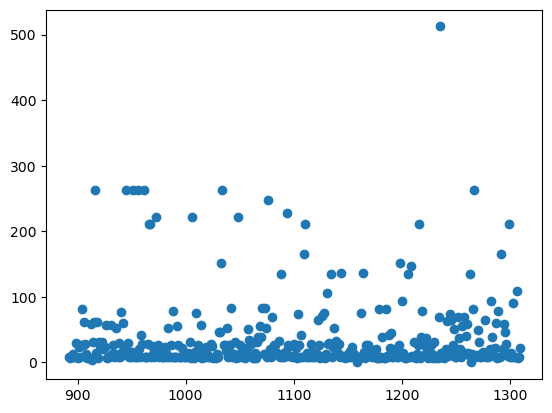

In [385]:
x_2 = data_test_id.tolist()
y_2 = data_test.Fare.tolist()
plt.scatter(x_2, y_2)

In [386]:
data_test.loc[data_test.Fare > 400, 'Fare'] = data_test[(data_test.Fare < 400) & (data_test.Embarked == 'C') & 
                                                        (data_test.Pclass == 1)].Fare.mean()

In [387]:
data_test.loc[(data_test['Fare'] == 0) & (data_test['Sex'] == 'male') & (data_test['Embarked'] == 'S') & 
              (data_test['Pclass'] == 1), 'Fare'] = data_test[(data_test['Sex'] == 'male') & 
                                                              (data_test['Embarked'] == 'S') & (data_test['Pclass'] == 1)].Fare.mean()

In [388]:
data_test['Fare_Category'] = pd.cut(data_test['Fare'], bins=[0, 40, 100, 170, 270], 
                                     labels=['Low', 'Mid', 'High_Mid', 'High'])

In [389]:
data_test.loc[data_test.Relatives > 9, 'Relatives'] = data_test[data_test.Relatives < 9].Relatives.max()

In [390]:
data_test = data_test.astype({'Age': np.int64})
data_test = data_test.astype({'Fare': np.int64})

In [391]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Pclass         418 non-null    int64   
 1   Sex            418 non-null    object  
 2   Age            418 non-null    int64   
 3   Fare           418 non-null    int64   
 4   Embarked       418 non-null    object  
 5   Relatives      418 non-null    int64   
 6   Is_Alone       418 non-null    bool    
 7   Fare_Category  418 non-null    category
dtypes: bool(1), category(1), int64(4), object(2)
memory usage: 20.7+ KB


In [392]:
real_cols_test = ['Age','Fare']
cat_cols_test = ['Pclass', 'Sex', 'Embarked', 'Relatives', 'Is_Alone', 'Fare_Category']

In [681]:
scaler_real_cols_test = pd.DataFrame(scaler.fit_transform(data_test[real_cols_test]), 
                                     columns=scaler.get_feature_names_out())
#robust_real_cols_test = pd.DataFrame(robust.fit_transform(real_cols_test), columns=robust.get_feature_names_out())

In [682]:
#one_hot_cat_cols_test = pd.DataFrame(ohe.fit_transform(cat_cols_test).toarray(), columns=ohe.get_feature_names_out())
label_cat_cols_test = data_test[cat_cols_test].apply(LabelEncoder().fit_transform)

In [683]:
X_2 = pd.concat([data_test[real_cols], label_cat_cols_test], axis='columns')

In [684]:
X_2

Age  Fare  Pclass  Sex  Embarked  Relatives
0     34     7       2    1         1          0
1     47     7       2    0         2          1
2     62     9       1    1         1          0
3     27     8       2    1         2          0
4     22    12       2    0         2          2
..   ...   ...     ...  ...       ...        ...
413   24     8       2    1         2          0
414   39   108       0    0         0          0
415   38     7       2    1         2          0
416   24     8       2    1         2          0
417   22    22       2    1         0          2

[418 rows x 6 columns]

In [685]:
data_test

Pclass     Sex  Age  Fare Embarked  Relatives
0         3    male   34     7        Q          0
1         3  female   47     7        S          1
2         2    male   62     9        Q          0
3         3    male   27     8        S          0
4         3  female   22    12        S          2
..      ...     ...  ...   ...      ...        ...
413       3    male   24     8        S          0
414       1  female   39   108        C          0
415       3    male   38     7        S          0
416       3    male   24     8        S          0
417       3    male   22    22        C          2

[418 rows x 6 columns]

In [393]:
y_pred_2 = catboost.predict(data_test)

In [394]:
y_pred_2[5:11]

array([0, 1, 0, 1, 0, 0], dtype=int64)

In [395]:
gender_submission = pd.read_csv('C:/Users/markc/Downloads/titanic/gender_submission.csv')

In [396]:
gender_submission['Survived'] = y_pred_2

In [397]:
gender_submission[5:11]

PassengerId  Survived
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0

In [398]:
gender_submission.to_csv('catboost_titanic_16.csv', index=None)